In [1698]:
import warnings
warnings.filterwarnings("ignore")
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.model_selection import KFold, train_test_split,TimeSeriesSplit
from sklearn.preprocessing import StandardScaler,MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestRegressor, StackingRegressor
from sklearn.metrics import mean_absolute_error,r2_score
from hyperopt import fmin, tpe, hp, Trials
from statsmodels.tsa.seasonal import seasonal_decompose
from prophet import Prophet
from sklearn.cluster import KMeans

from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.layers import LSTM, Dense, Dropout
from tensorflow.python.keras.optimizers import rmsprop_v2
from tensorflow.python.keras.losses import MeanAbsoluteError
from tensorflow.python.keras.callbacks import EarlyStopping



pd.set_option("display.max_rows", None)
pd.set_option("display.max_columns", None)
pd.set_option('display.max_colwidth', None)
plt.style.use("ggplot")
sns.set_palette(sns.diverging_palette(220, 20))

# DATA VALIDATION

**train.csv:**
| Sütun      | Açıklama                                       |
|------------|------------------------------------------------|
| tarih      | Kesintinin gerçekleştiği tarih                 |
| ilce       | Kesintinin gerçekleştiği il-ilçe                |
| bildirimli_sum | Planlı kesinti sayısı                        |
| bildirimsiz_sum | Plansız kesinti sayısı (Tahmin edilecek hedef değişken 🎯) |

**test.csv:**
| Sütun      | Açıklama                                       |
|------------|------------------------------------------------|
| tarih      | Kesintinin gerçekleştiği tarih                 |
| ilce       | Kesintinin gerçekleştiği il-ilçe                |
| bildirimli_sum | Planlı kesinti sayısı                        |

**weather.csv:**
| Sütun      | Açıklama                                       |
|------------|------------------------------------------------|
| date       | Saatlik zaman                                  |
| lat        | Enlem                                          |
| lon        | Boylam                                         |
| t_2m:C     | Sıcaklık, Celcius                              |
| effective_cloud_cover:p | Bulutluluk                        |
| global_rad:W | Güneşlilik değeri, Watt                     |
| relative_humidity_2m:p | Bağıl nem                       |
| wind_dir_10m:d | Rüzgar yönü                                |
| wind_speed_10m:ms | Rüzgar hızı, m/s                         |
| prob_precip_1h:p | Yağış                                      |
| t_apparent:C | Hissedilen sıcaklık                            |
| ilce       | İl-İlçe ikilisi                                |

**holidays.csv:**
| Sütun      | Açıklama                                       |
|------------|------------------------------------------------|
| Yıl        | Yıl                                            |
| Ay         | Ay                                             |
| Gün        | Gün                                            |
| Bayram_Flag | Tatil adı                                      |

**sample_submission.csv:**
| Sütun      | Açıklama                                       |
|------------|------------------------------------------------|
| unique_id  | Test dönemindeki ilce ve tarih ikililerinden oluşturulmuş tekil id. |
| bildirimsiz_sum | Tahmin edilmesi gereken toplam plansız kesinti sayısı |


In [1699]:
train = pd.read_csv("dataset/train.csv")
#train["tarih"] = pd.to_datetime(train["tarih"])
train["ilce"] = train["ilce"].str.strip().str.lower()
train["unique_id"] = train["tarih"].astype(str) +"-"+train["ilce"]
train.sort_values("tarih",inplace=True,ignore_index=True)
train.head()

tarih           ilce  bildirimsiz_sum  bildirimli_sum  \
0  2021-01-01   izmir-aliaga                5               0   
1  2021-01-01   izmir-dikili                5               0   
2  2021-01-01     izmir-urla               18               0   
3  2021-01-01     izmir-foca                8               0   
4  2021-01-01  izmir-torbali                5               0   

                  unique_id  
0   2021-01-01-izmir-aliaga  
1   2021-01-01-izmir-dikili  
2     2021-01-01-izmir-urla  
3     2021-01-01-izmir-foca  
4  2021-01-01-izmir-torbali

In [1700]:
train.shape

(48148, 5)

In [1701]:
test = pd.read_csv("dataset/test.csv")
#test["tarih"] = pd.to_datetime(test["tarih"])
train["ilce"] = train["ilce"].str.strip().str.lower()
test["bildirimsiz_sum"]=np.nan
test["unique_id"] = test["tarih"].astype(str) +"-"+test["ilce"]
test.sort_values("tarih",inplace=True,ignore_index=True)
test = test[train.columns.to_list()]
test.head()

tarih               ilce  bildirimsiz_sum  bildirimli_sum  \
0  2024-02-01       izmir-aliaga              NaN               0   
1  2024-02-01     manisa-akhisar              NaN               1   
2  2024-02-01    manisa-alasehir              NaN               0   
3  2024-02-01     manisa-demirci              NaN               1   
4  2024-02-01  manisa-golmarmara              NaN               0   

                      unique_id  
0       2024-02-01-izmir-aliaga  
1     2024-02-01-manisa-akhisar  
2    2024-02-01-manisa-alasehir  
3     2024-02-01-manisa-demirci  
4  2024-02-01-manisa-golmarmara

In [1702]:
test.shape

(1363, 5)

In [1703]:
sub = pd.read_csv("dataset/sample_submission.csv")
sub.head()

unique_id  bildirimsiz_sum
0    2024-02-01-izmir-aliaga              NaN
1  2024-02-01-izmir-bayindir              NaN
2  2024-02-01-izmir-bayrakli              NaN
3   2024-02-01-izmir-bergama              NaN
4   2024-02-01-izmir-bornova              NaN

**Train test birleştirme**

In [1704]:
train_test_concat= pd.concat([train,test],axis=0)
train_test_concat.head()

tarih           ilce  bildirimsiz_sum  bildirimli_sum  \
0  2021-01-01   izmir-aliaga              5.0               0   
1  2021-01-01   izmir-dikili              5.0               0   
2  2021-01-01     izmir-urla             18.0               0   
3  2021-01-01     izmir-foca              8.0               0   
4  2021-01-01  izmir-torbali              5.0               0   

                  unique_id  
0   2021-01-01-izmir-aliaga  
1   2021-01-01-izmir-dikili  
2     2021-01-01-izmir-urla  
3     2021-01-01-izmir-foca  
4  2021-01-01-izmir-torbali

In [1705]:
train_test_concat.shape

(49511, 5)

**Tatil verilerinin eklenmesi**

In [1706]:
holidays=pd.read_csv("dataset/holidays.csv")
holidays["tarih"]=holidays[["Yıl","Ay","Gün"]].apply(lambda x : "-".join(x.astype(str)),axis=1)
holidays["tarih"] = pd.to_datetime(holidays["tarih"]).astype(str)
train_test_concat = train_test_concat.merge(holidays,how="left",on="tarih")
train_test_concat.drop(["Yıl","Ay","Gün"],inplace=True,axis=1)
train_test_concat.rename(columns={"Tatil Adı":"flag"},inplace=True)
train_test_concat["flag"].fillna("Normal",inplace=True)
train_test_concat["flag"].replace({"Normal":"normal",
                                   "Sacrifice Feast Holiday* (*estimated)":"kurban_tatil",
                                   "Sacrifice Feast* (*estimated)":"kurban_bayram",
                                   "Ramadan Feast Holiday* (*estimated)":"ramazan_tatil",
                                   "Ramadan Feast* (*estimated)":"ramazan_bayram",
                                   "New Year's Day":"yilbasi",
                                   "Labour Day":"isci",
                                   "Democracy and National Unity Day":"dvmbgunu",
                                   "Victory Day":"zafer",
                                   "Commemoration of Ataturk, Youth and Sports Day":"spor",
                                   "Republic Day":"cumhuriyet",
                                   "National Sovereignty and Children's Day":"cocuk",
                                   "National Sovereignty and Children's Day; Ramadan Feast Holiday* (*estimated)":"ramazan_cocuk"
                                   },inplace=True)
train_test_concat[train_test_concat["flag"]=="cocuk"].head()

tarih              ilce  bildirimsiz_sum  bildirimli_sum  \
4865  2021-04-23    manisa-demirci              1.0               0   
4866  2021-04-23       manisa-kula              3.0               0   
4867  2021-04-23        izmir-tire             13.0               0   
4868  2021-04-23  izmir-guzelbahce              2.0               0   
4869  2021-04-23    manisa-sarigol              2.0               0   

                        unique_id   flag  
4865    2021-04-23-manisa-demirci  cocuk  
4866       2021-04-23-manisa-kula  cocuk  
4867        2021-04-23-izmir-tire  cocuk  
4868  2021-04-23-izmir-guzelbahce  cocuk  
4869    2021-04-23-manisa-sarigol  cocuk

In [1707]:
train_test_concat["flag"].value_counts()

flag
normal            47813
kurban_tatil        367
ramazan_tatil       197
yilbasi             154
dvmbgunu            132
isci                131
zafer               127
spor                122
ramazan_bayram      121
kurban_bayram       120
cumhuriyet          116
cocuk                78
ramazan_cocuk        33
Name: count, dtype: int64

In [1708]:
holidays["tarih"].max()

'2024-10-29'

In [1709]:
holidays["tarih"].min()

'2021-01-01'

**Hava Durumu verilerinin incelenmesi**

In [1710]:
weather=pd.read_csv("dataset/weather.csv")
weather.sort_values("date",inplace=True,ignore_index=True)
weather["name"] = weather["name"].str.strip().str.lower()
weather_columns=weather.columns.to_list()
weather_columns = ['tarih','lat','long','temp','cloud_cover','global_rad','relative_humidity','wind_dir','wind_speed','precip','temp_app','ilce']
weather.columns = weather_columns
weather["tarih"] = weather["tarih"].str[:10]
weather.head()

tarih      lat     long  temp  cloud_cover  global_rad  \
0  2021-01-01  38.6184  28.6712   7.6         10.5         0.0   
1  2021-01-01  38.3891  27.0500  13.0         28.0         0.0   
2  2021-01-01  38.4612  27.1881  12.8         29.6         0.0   
3  2021-01-01  38.5002  27.7084  11.7          9.2         0.0   
4  2021-01-01  38.3250  26.7668  13.1         58.7         0.0   

   relative_humidity  wind_dir  wind_speed  precip  temp_app             ilce  
0               86.1     173.3         2.6     1.0       5.9   manisa-ahmetli  
1               87.2     145.5         4.5     1.0      12.9    izmir-balcova  
2               84.5     142.2         3.4     1.0      12.8   izmir-bayrakli  
3               77.8     183.1         2.1     1.0      11.6  manisa-turgutlu  
4               89.7     160.2         5.7     1.0      13.1       izmir-urla

**Hava durumu sayısal değişkenlerinin incelenmesi**

In [1711]:
def single_variable_multiple_plot(data,numeric=True):
    """
    Veri setindeki tek bir sayısal değişken için histogram, boxplot grafiği ve çekirdek yoğunluk grafiği.
    Kategorik değişken için countplot grafiği ve pasta grafiği kullanarak görselleştirir.

    Parametreler:
    data : DataFrame Veri kümesi.
    type : str, opsiyonel, Sayısal değişkenlerin veri tipi. Varsayılan 'float64'tür.
    numeric : bool, opsiyonel, True ise, grafikler sayısal değişkenler için oluşturulur; False ise, grafikler kategorik değişkenler için oluşturulur. Varsayılan True'dur.

    Returns:
    None
    """
 
    if numeric: 
         numeric_columns= [col for col in data.columns if data[col].dtype in ["float64","int64","float32","int32"]]
         for i in numeric_columns:
            fig, axes = plt.subplots(nrows=1,ncols=3, figsize=(20,4))
            sns.histplot(x=data[i],bins=10,ax=axes[0])
            axes[0].set_title(i)
            sns.boxplot(x=data[i],ax=axes[1])
            axes[1].set_title(i)
            sns.kdeplot(x=data[i],ax=axes[2])
            axes[2].set_title(i)
            plt.show()
    
    else:
         categoric_columns= [col for col in data.columns if data[col].dtype in ["object","category"]]
         for i in categoric_columns:
            fig, axes = plt.subplots(nrows=1,ncols=2, figsize=(16,8))
            sns.countplot(data=data, x=i,order=data[i].value_counts().index, ax=axes[0])
            axes[0].set_title(i)
            axes[0].set_xticklabels(axes[0].get_xticklabels(), rotation=90)
            plt.pie(data[i].value_counts(), autopct='%1.1f%%',labels=data[i].value_counts().index)
            axes[1].set_title(i)
            axes[1].set_xticklabels(axes[1].get_xticklabels(), rotation=90)
            plt.tight_layout()
            plt.show()

In [1712]:
# single_variable_multiple_plot(weather,numeric=True)

In [1713]:
weather.describe().T

count        mean         std      min      25%  \
lat                1302840.0   38.535130    0.303275  37.9508  38.3250   
long               1302840.0   27.526583    0.634262  26.3032  27.0697   
temp               1302840.0   17.259831    8.752368 -12.6000  10.8000   
cloud_cover        1302840.0   29.840105   34.489809   0.0000   0.0000   
global_rad         1302840.0  200.391671  279.391289   0.0000   0.0000   
relative_humidity  1302840.0   64.028995   20.454085   5.6000  49.3000   
wind_dir           1302840.0  158.169187  120.143999   0.0000  42.4000   
wind_speed         1302840.0    2.722684    1.916292   0.0000   1.3000   
precip             1302840.0    3.097589   11.094187   1.0000   1.0000   
temp_app           1302840.0   18.452245   10.341129 -17.8000  11.4000   

                        50%       75%        max  
lat                 38.4710   38.7375    39.1881  
long                27.3818   27.9748    28.8693  
temp                16.7000   23.6000    44.8000  
cloud_cover         12.6000   53.7000   100.0000  
global_rad           0.0000  375.9000  1026.3000  
relative_humidity   66.2000   80.4000   100.0000  
wind_dir           141.4000  278.9000   360.0000  
wind_speed           2.2000    3.7000    18.4000  
precip               1.0000    1.0000    95.0000  
temp_app            17.9000   25.2000    52.0000

**Hava durumu verilerini agg ile günlük formata çevirme**

In [1714]:
#Hissedilen ve ölçülen sıcaklık farkı
weather["temp_measure_app_diff"] = weather["temp_app"] - weather["temp"]
weather_group = weather.groupby(["tarih","ilce"]).agg({"lat":"first",
                                                        "long":"first",
                                                        "temp":"max",
                                                        "cloud_cover":"max",
                                                        "global_rad":"max",
                                                        "relative_humidity":"max",
                                                        "wind_dir":"mean",
                                                        "wind_speed":"max",
                                                        "precip":"max",
                                                        "temp_app":"max",
                                                        "temp_measure_app_diff":"max"}).reset_index()
weather_group["wind_dir"] = round(weather_group["wind_dir"],1)
weather_group.head()

tarih            ilce      lat     long  temp  cloud_cover  \
0  2021-01-01    izmir-aliaga  38.7996  26.9707  15.8         97.1   
1  2021-01-01   izmir-balcova  38.3891  27.0500  15.0         92.6   
2  2021-01-01  izmir-bayindir  38.2178  27.6478  14.5         94.5   
3  2021-01-01  izmir-bayrakli  38.4612  27.1881  15.1         87.4   
4  2021-01-01   izmir-bergama  39.1214  27.1799  15.0         97.0   

   global_rad  relative_humidity  wind_dir  wind_speed  precip  temp_app  \
0       338.4               91.8     167.2         6.4     1.0      18.6   
1       291.2               93.3     145.4         4.5     7.9      17.8   
2       248.8               94.4      58.5         2.3     1.0      17.6   
3       282.1               97.1     141.8         3.5     3.7      17.9   
4       303.2               93.7     186.4         3.0     1.0      17.9   

   temp_measure_app_diff  
0                    3.0  
1                    3.0  
2                    3.4  
3                    2.9  
4                    3.2

In [1715]:
weather_group.loc[(weather_group["tarih"]=="2021-01-01")&(weather_group["ilce"]=="izmir-aliaga"),weather_group.columns.to_list()]

tarih          ilce      lat     long  temp  cloud_cover  global_rad  \
0  2021-01-01  izmir-aliaga  38.7996  26.9707  15.8         97.1       338.4   

   relative_humidity  wind_dir  wind_speed  precip  temp_app  \
0               91.8     167.2         6.4     1.0      18.6   

   temp_measure_app_diff  
0                    3.0

In [1716]:
weather_group.shape

(54285, 13)

**Train test concat tarih aralıklarına göre hava durumu verilerini alma**

In [1717]:
start_date = train_test_concat["tarih"].astype(str).min()
end_date = train_test_concat["tarih"].astype(str).max()
weather_group_date_range = weather_group[(weather_group["tarih"] >= start_date) & (weather_group["tarih"] <= end_date)]
weather_group_date_range.head()


tarih            ilce      lat     long  temp  cloud_cover  \
0  2021-01-01    izmir-aliaga  38.7996  26.9707  15.8         97.1   
1  2021-01-01   izmir-balcova  38.3891  27.0500  15.0         92.6   
2  2021-01-01  izmir-bayindir  38.2178  27.6478  14.5         94.5   
3  2021-01-01  izmir-bayrakli  38.4612  27.1881  15.1         87.4   
4  2021-01-01   izmir-bergama  39.1214  27.1799  15.0         97.0   

   global_rad  relative_humidity  wind_dir  wind_speed  precip  temp_app  \
0       338.4               91.8     167.2         6.4     1.0      18.6   
1       291.2               93.3     145.4         4.5     7.9      17.8   
2       248.8               94.4      58.5         2.3     1.0      17.6   
3       282.1               97.1     141.8         3.5     3.7      17.9   
4       303.2               93.7     186.4         3.0     1.0      17.9   

   temp_measure_app_diff  
0                    3.0  
1                    3.0  
2                    3.4  
3                    2.9  
4                    3.2

In [1718]:
weather_group_date_range["tarih"].min()

'2021-01-01'

In [1719]:
weather_group_date_range["tarih"].max()

'2024-02-29'

In [1720]:
weather_group_date_range.shape

(54285, 13)

In [1721]:
train_test_concat["tarih"].min()

'2021-01-01'

In [1722]:
train_test_concat["tarih"].max()

'2024-02-29'

In [1723]:
train_test_concat.shape

(49511, 6)

In [1724]:
weather_group_date_range.head()

tarih            ilce      lat     long  temp  cloud_cover  \
0  2021-01-01    izmir-aliaga  38.7996  26.9707  15.8         97.1   
1  2021-01-01   izmir-balcova  38.3891  27.0500  15.0         92.6   
2  2021-01-01  izmir-bayindir  38.2178  27.6478  14.5         94.5   
3  2021-01-01  izmir-bayrakli  38.4612  27.1881  15.1         87.4   
4  2021-01-01   izmir-bergama  39.1214  27.1799  15.0         97.0   

   global_rad  relative_humidity  wind_dir  wind_speed  precip  temp_app  \
0       338.4               91.8     167.2         6.4     1.0      18.6   
1       291.2               93.3     145.4         4.5     7.9      17.8   
2       248.8               94.4      58.5         2.3     1.0      17.6   
3       282.1               97.1     141.8         3.5     3.7      17.9   
4       303.2               93.7     186.4         3.0     1.0      17.9   

   temp_measure_app_diff  
0                    3.0  
1                    3.0  
2                    3.4  
3                    2.9  
4                    3.2

In [1725]:
train_test_concat.loc[(train_test_concat["tarih"]=="2021-01-01")&((train_test_concat["ilce"]=="izmir-aliaga"))]

tarih          ilce  bildirimsiz_sum  bildirimli_sum  \
0  2021-01-01  izmir-aliaga              5.0               0   

                 unique_id     flag  
0  2021-01-01-izmir-aliaga  yilbasi

In [1726]:
weather_group_date_range.loc[(weather_group_date_range["tarih"]=="2021-01-01")&(weather_group_date_range["ilce"]=="izmir-aliaga"),weather_group_date_range.columns.to_list()]

tarih          ilce      lat     long  temp  cloud_cover  global_rad  \
0  2021-01-01  izmir-aliaga  38.7996  26.9707  15.8         97.1       338.4   

   relative_humidity  wind_dir  wind_speed  precip  temp_app  \
0               91.8     167.2         6.4     1.0      18.6   

   temp_measure_app_diff  
0                    3.0

**Hava durumu verilerinin birleştirilmesi**

In [1727]:
train_test_concat = train_test_concat.merge(weather_group_date_range,how= "left", on=["tarih","ilce"])
train_test_concat.head()

tarih           ilce  bildirimsiz_sum  bildirimli_sum  \
0  2021-01-01   izmir-aliaga              5.0               0   
1  2021-01-01   izmir-dikili              5.0               0   
2  2021-01-01     izmir-urla             18.0               0   
3  2021-01-01     izmir-foca              8.0               0   
4  2021-01-01  izmir-torbali              5.0               0   

                  unique_id     flag      lat     long  temp  cloud_cover  \
0   2021-01-01-izmir-aliaga  yilbasi  38.7996  26.9707  15.8         97.1   
1   2021-01-01-izmir-dikili  yilbasi  39.0749  26.8892  15.9         99.9   
2     2021-01-01-izmir-urla  yilbasi  38.3250  26.7668  15.6         99.1   
3     2021-01-01-izmir-foca  yilbasi  38.6704  26.7579  15.8         93.0   
4  2021-01-01-izmir-torbali  yilbasi  38.1558  27.3646  15.2         97.2   

   global_rad  relative_humidity  wind_dir  wind_speed  precip  temp_app  \
0       338.4               91.8     167.2         6.4     1.0      18.6   
1       296.0               93.8     160.2         5.5    12.0      17.9   
2       355.9               95.1     172.8         5.7     1.0      19.0   
3       380.9               91.8     168.8         7.2    12.8      18.8   
4       231.7               94.1     100.3         2.2     6.2      17.9   

   temp_measure_app_diff  
0                    3.0  
1                    3.0  
2                    3.4  
3                    3.3  
4                    2.7

In [1728]:
# kontrol
train_test_concat.loc[(train_test_concat["tarih"]=="2021-01-01")&(train_test_concat["ilce"]=="izmir-aliaga"),train_test_concat.columns.to_list()]

tarih          ilce  bildirimsiz_sum  bildirimli_sum  \
0  2021-01-01  izmir-aliaga              5.0               0   

                 unique_id     flag      lat     long  temp  cloud_cover  \
0  2021-01-01-izmir-aliaga  yilbasi  38.7996  26.9707  15.8         97.1   

   global_rad  relative_humidity  wind_dir  wind_speed  precip  temp_app  \
0       338.4               91.8     167.2         6.4     1.0      18.6   

   temp_measure_app_diff  
0                    3.0

**Hava durumu verilerini agg min ile günlük formata çevirme**

In [1729]:
weather_group_min = weather.groupby(["tarih","ilce"]).agg({
                                                        "cloud_cover":"min",
                                                        "relative_humidity":"min",
                                                        "wind_speed":"min",
                                                        "precip":"min",
                                                        "temp":"min"}).reset_index()
weather_group_min.columns = ["tarih","ilce","cloud_cover_min","relative_humidity_min","wind_speed_min","precip_min","temp_min"]
weather_group_min.head()

tarih            ilce  cloud_cover_min  relative_humidity_min  \
0  2021-01-01    izmir-aliaga             24.7                   75.7   
1  2021-01-01   izmir-balcova             28.0                   81.8   
2  2021-01-01  izmir-bayindir             35.3                   83.5   
3  2021-01-01  izmir-bayrakli             29.6                   83.5   
4  2021-01-01   izmir-bergama             29.2                   72.0   

   wind_speed_min  precip_min  temp_min  
0             1.8         1.0      11.3  
1             2.3         1.0      11.8  
2             0.5         1.0       9.6  
3             1.5         1.0      11.2  
4             0.5         1.0       8.9

In [1730]:
start_date = train_test_concat["tarih"].astype(str).min()
end_date = train_test_concat["tarih"].astype(str).max()
weather_group_date_range_min = weather_group_min[(weather_group_min["tarih"] >= start_date) & (weather_group_min["tarih"] <= end_date)]
weather_group_date_range_min.head()

tarih            ilce  cloud_cover_min  relative_humidity_min  \
0  2021-01-01    izmir-aliaga             24.7                   75.7   
1  2021-01-01   izmir-balcova             28.0                   81.8   
2  2021-01-01  izmir-bayindir             35.3                   83.5   
3  2021-01-01  izmir-bayrakli             29.6                   83.5   
4  2021-01-01   izmir-bergama             29.2                   72.0   

   wind_speed_min  precip_min  temp_min  
0             1.8         1.0      11.3  
1             2.3         1.0      11.8  
2             0.5         1.0       9.6  
3             1.5         1.0      11.2  
4             0.5         1.0       8.9

In [1731]:
train_test_concat = train_test_concat.merge(weather_group_date_range_min,how= "left", on=["tarih","ilce"])
train_test_concat.head()

tarih           ilce  bildirimsiz_sum  bildirimli_sum  \
0  2021-01-01   izmir-aliaga              5.0               0   
1  2021-01-01   izmir-dikili              5.0               0   
2  2021-01-01     izmir-urla             18.0               0   
3  2021-01-01     izmir-foca              8.0               0   
4  2021-01-01  izmir-torbali              5.0               0   

                  unique_id     flag      lat     long  temp  cloud_cover  \
0   2021-01-01-izmir-aliaga  yilbasi  38.7996  26.9707  15.8         97.1   
1   2021-01-01-izmir-dikili  yilbasi  39.0749  26.8892  15.9         99.9   
2     2021-01-01-izmir-urla  yilbasi  38.3250  26.7668  15.6         99.1   
3     2021-01-01-izmir-foca  yilbasi  38.6704  26.7579  15.8         93.0   
4  2021-01-01-izmir-torbali  yilbasi  38.1558  27.3646  15.2         97.2   

   global_rad  relative_humidity  wind_dir  wind_speed  precip  temp_app  \
0       338.4               91.8     167.2         6.4     1.0      18.6   
1       296.0               93.8     160.2         5.5    12.0      17.9   
2       355.9               95.1     172.8         5.7     1.0      19.0   
3       380.9               91.8     168.8         7.2    12.8      18.8   
4       231.7               94.1     100.3         2.2     6.2      17.9   

   temp_measure_app_diff  cloud_cover_min  relative_humidity_min  \
0                    3.0             24.7                   75.7   
1                    3.0             17.1                   73.6   
2                    3.4             33.6                   80.7   
3                    3.3             24.8                   74.5   
4                    2.7             18.1                   83.2   

   wind_speed_min  precip_min  temp_min  
0             1.8         1.0      11.3  
1             1.4         1.0      11.5  
2             2.4         1.0      11.5  
3             3.9         1.0      12.6  
4             1.2         1.0       9.9

In [1732]:
train_test_concat.isnull().sum()

tarih                       0
ilce                        0
bildirimsiz_sum          1363
bildirimli_sum              0
unique_id                   0
flag                        0
lat                         0
long                        0
temp                        0
cloud_cover                 0
global_rad                  0
relative_humidity           0
wind_dir                    0
wind_speed                  0
precip                      0
temp_app                    0
temp_measure_app_diff       0
cloud_cover_min             0
relative_humidity_min       0
wind_speed_min              0
precip_min                  0
temp_min                    0
dtype: int64

In [1733]:
train_test_concat.shape

(49511, 22)

**Keşifsel Veri Analizi - EDA**

**Kategorik Değişkenlerin Analizi**

**Target değişkene göre(bildirimsiz_sum) İl ve İlçe bazlı analiz**

In [1734]:
train_test_concat.rename(columns={"ilce":"il_ilce"},inplace=True)
train_test_concat[["il","ilce"]] =  train_test_concat["il_ilce"].str.split("-",expand=True)
train_test_concat.head()

tarih        il_ilce  bildirimsiz_sum  bildirimli_sum  \
0  2021-01-01   izmir-aliaga              5.0               0   
1  2021-01-01   izmir-dikili              5.0               0   
2  2021-01-01     izmir-urla             18.0               0   
3  2021-01-01     izmir-foca              8.0               0   
4  2021-01-01  izmir-torbali              5.0               0   

                  unique_id     flag      lat     long  temp  cloud_cover  \
0   2021-01-01-izmir-aliaga  yilbasi  38.7996  26.9707  15.8         97.1   
1   2021-01-01-izmir-dikili  yilbasi  39.0749  26.8892  15.9         99.9   
2     2021-01-01-izmir-urla  yilbasi  38.3250  26.7668  15.6         99.1   
3     2021-01-01-izmir-foca  yilbasi  38.6704  26.7579  15.8         93.0   
4  2021-01-01-izmir-torbali  yilbasi  38.1558  27.3646  15.2         97.2   

   global_rad  relative_humidity  wind_dir  wind_speed  precip  temp_app  \
0       338.4               91.8     167.2         6.4     1.0      18.6   
1       296.0               93.8     160.2         5.5    12.0      17.9   
2       355.9               95.1     172.8         5.7     1.0      19.0   
3       380.9               91.8     168.8         7.2    12.8      18.8   
4       231.7               94.1     100.3         2.2     6.2      17.9   

   temp_measure_app_diff  cloud_cover_min  relative_humidity_min  \
0                    3.0             24.7                   75.7   
1                    3.0             17.1                   73.6   
2                    3.4             33.6                   80.7   
3                    3.3             24.8                   74.5   
4                    2.7             18.1                   83.2   

   wind_speed_min  precip_min  temp_min     il     ilce  
0             1.8         1.0      11.3  izmir   aliaga  
1             1.4         1.0      11.5  izmir   dikili  
2             2.4         1.0      11.5  izmir     urla  
3             3.9         1.0      12.6  izmir     foca  
4             1.2         1.0       9.9  izmir  torbali

In [1735]:
train_test_concat["il"].value_counts()

il
izmir     32088
manisa    17423
Name: count, dtype: int64

- İzmir ve Manisa ilçe sayıları

In [1736]:
train_test_concat.groupby("il").agg({"ilce":pd.Series.nunique}).reset_index()

il  ilce
0   izmir    30
1  manisa    17

- izmirde büyüklük ve nufus yoğunluğuda göz önünde bulundurulduğunda kesintiler daha fazla

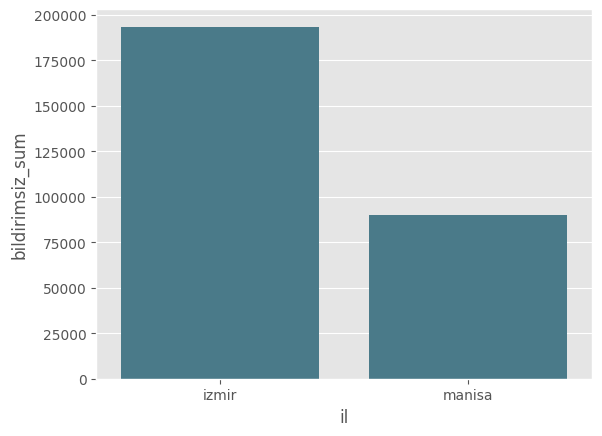

In [1737]:
il_group=train_test_concat.groupby("il")["bildirimsiz_sum"].sum().reset_index()
sns.barplot(x="il",y="bildirimsiz_sum",data=il_group)
plt.show()

**İl ve İlçe kesinti toplam sayıları**
- İzmir ilinde toplam kesinti sayısının en fazla olduğu ilk  3 ilçe çeşme, ödemiş ve konak iken en az olan 3 ilçe narlıdere, beydağ ve balçova ilçeleridir.
- Manisa ilinde toplam kesinti sayısının en fazla olduğu ilk  3 ilçe yunusemre, salihli ve akhisar iken en az olan 3 ilçe köprübaşı, ahmetli ve gölmarmara ilçeleridir.

In [1738]:
sorted_df = train_test_concat.groupby(["il", "ilce"])["bildirimsiz_sum"].sum().reset_index().sort_values(by=["il", "bildirimsiz_sum"], ascending=[True, False])
sorted_df["il_ilce"] = sorted_df["il"] + "-" + sorted_df["ilce"]
sorted_df = sorted_df.drop(columns=["il", "ilce"])
sorted_df = sorted_df[["il_ilce", "bildirimsiz_sum"]].reset_index(drop=True)
sorted_df.head()

il_ilce  bildirimsiz_sum
0    izmir-cesme          14477.0
1   izmir-odemis          11746.0
2    izmir-konak          10962.0
3  izmir-bornova          10708.0
4     izmir-urla          10356.0

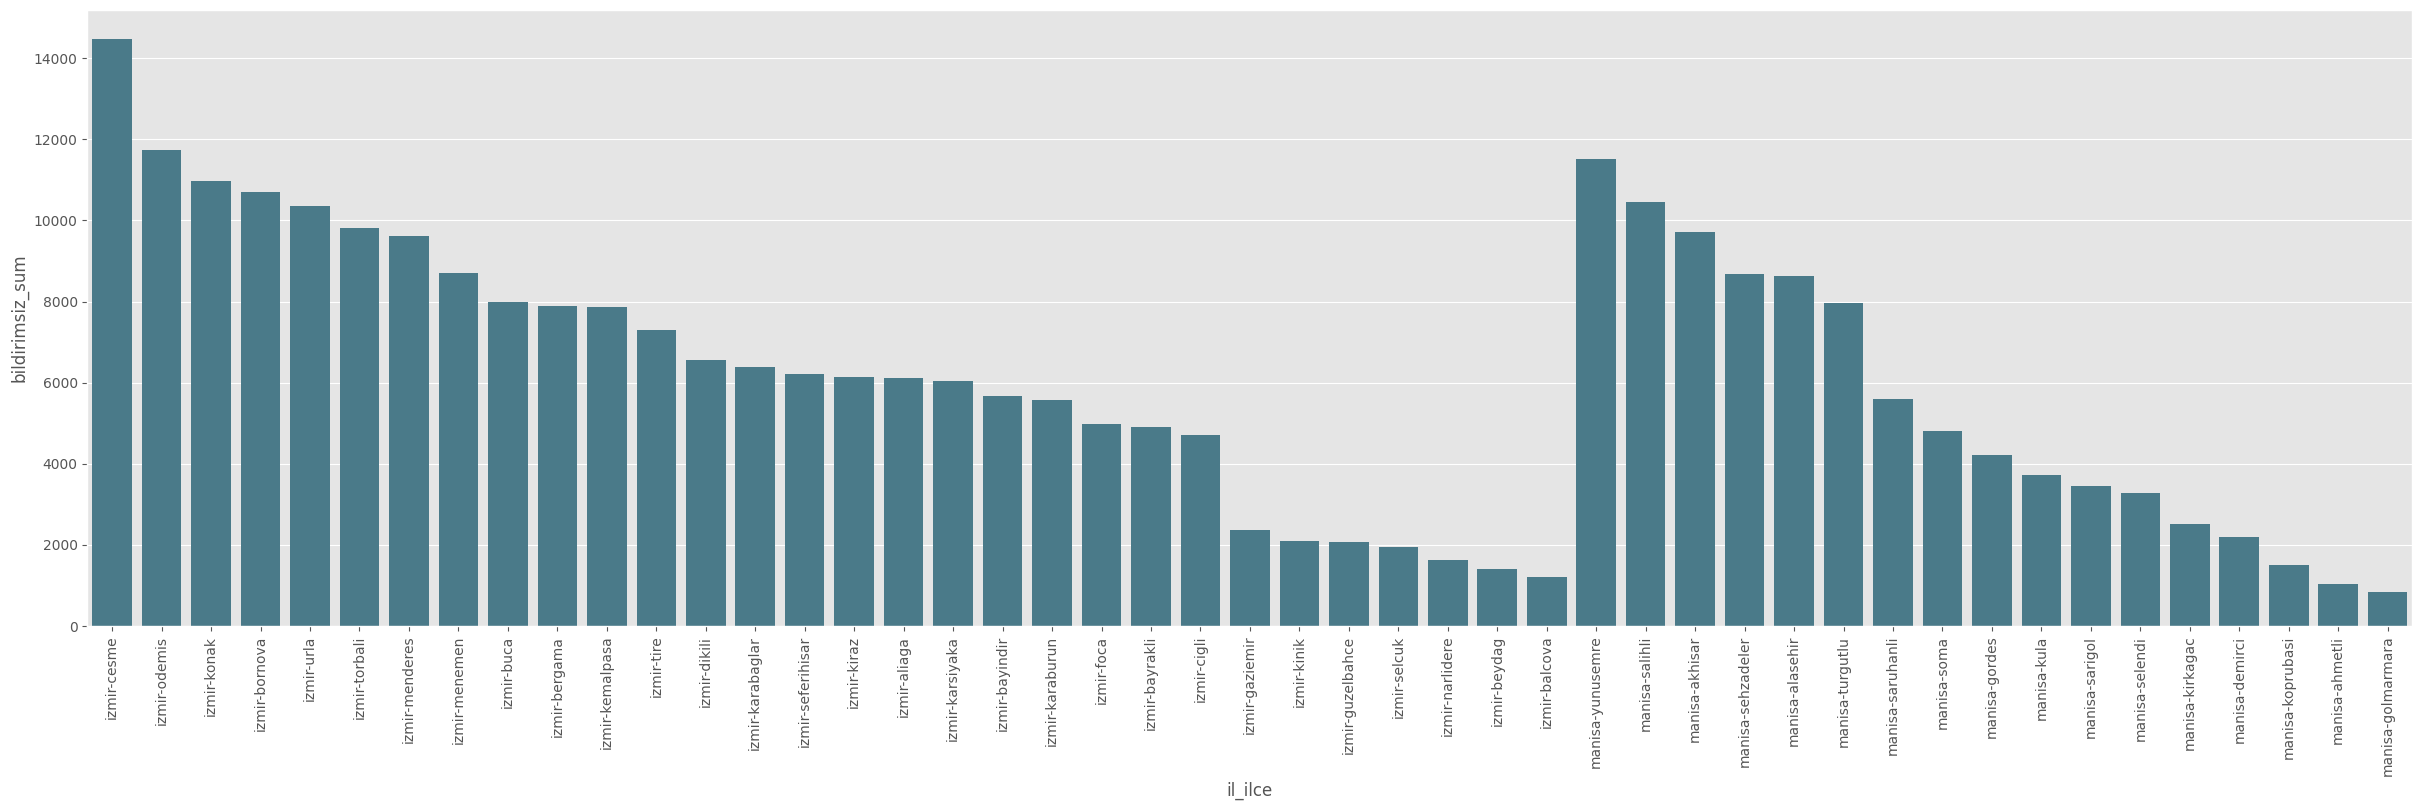

In [1739]:
plt.figure(figsize=(30, 8))
sns.barplot(x="il_ilce", y="bildirimsiz_sum", data=sorted_df)
plt.xticks(rotation=90)
plt.show()

**il ve ilçe bazlı elektrik kesintilerinin toplam kesintiye oranı değişkeninin veri setine eklenmesi**

In [1740]:
sorted_df["blackout_ratio_per_city_county"] = sorted_df["bildirimsiz_sum"] / sorted_df["bildirimsiz_sum"].sum()
sorted_df.drop("bildirimsiz_sum",inplace=True,axis=1)
sorted_series = sorted_df.set_index("il_ilce")["blackout_ratio_per_city_county"]
train_test_concat["blackout_ratio_per_city_county"] = train_test_concat["il_ilce"].map(sorted_series)
train_test_concat.head()

tarih        il_ilce  bildirimsiz_sum  bildirimli_sum  \
0  2021-01-01   izmir-aliaga              5.0               0   
1  2021-01-01   izmir-dikili              5.0               0   
2  2021-01-01     izmir-urla             18.0               0   
3  2021-01-01     izmir-foca              8.0               0   
4  2021-01-01  izmir-torbali              5.0               0   

                  unique_id     flag      lat     long  temp  cloud_cover  \
0   2021-01-01-izmir-aliaga  yilbasi  38.7996  26.9707  15.8         97.1   
1   2021-01-01-izmir-dikili  yilbasi  39.0749  26.8892  15.9         99.9   
2     2021-01-01-izmir-urla  yilbasi  38.3250  26.7668  15.6         99.1   
3     2021-01-01-izmir-foca  yilbasi  38.6704  26.7579  15.8         93.0   
4  2021-01-01-izmir-torbali  yilbasi  38.1558  27.3646  15.2         97.2   

   global_rad  relative_humidity  wind_dir  wind_speed  precip  temp_app  \
0       338.4               91.8     167.2         6.4     1.0      18.6   
1       296.0               93.8     160.2         5.5    12.0      17.9   
2       355.9               95.1     172.8         5.7     1.0      19.0   
3       380.9               91.8     168.8         7.2    12.8      18.8   
4       231.7               94.1     100.3         2.2     6.2      17.9   

   temp_measure_app_diff  cloud_cover_min  relative_humidity_min  \
0                    3.0             24.7                   75.7   
1                    3.0             17.1                   73.6   
2                    3.4             33.6                   80.7   
3                    3.3             24.8                   74.5   
4                    2.7             18.1                   83.2   

   wind_speed_min  precip_min  temp_min     il     ilce  \
0             1.8         1.0      11.3  izmir   aliaga   
1             1.4         1.0      11.5  izmir   dikili   
2             2.4         1.0      11.5  izmir     urla   
3             3.9         1.0      12.6  izmir     foca   
4             1.2         1.0       9.9  izmir  torbali   

   blackout_ratio_per_city_county  
0                        0.021574  
1                        0.023165  
2                        0.036536  
3                        0.017549  
4                        0.034582

- Kontrol

In [1741]:
sorted_df.head(1)

il_ilce  blackout_ratio_per_city_county
0  izmir-cesme                        0.051076

In [1742]:
train_test_concat.loc[train_test_concat["il_ilce"]=="izmir-cesme","blackout_ratio_per_city_county"].head(1)

30    0.051076
Name: blackout_ratio_per_city_county, dtype: float64

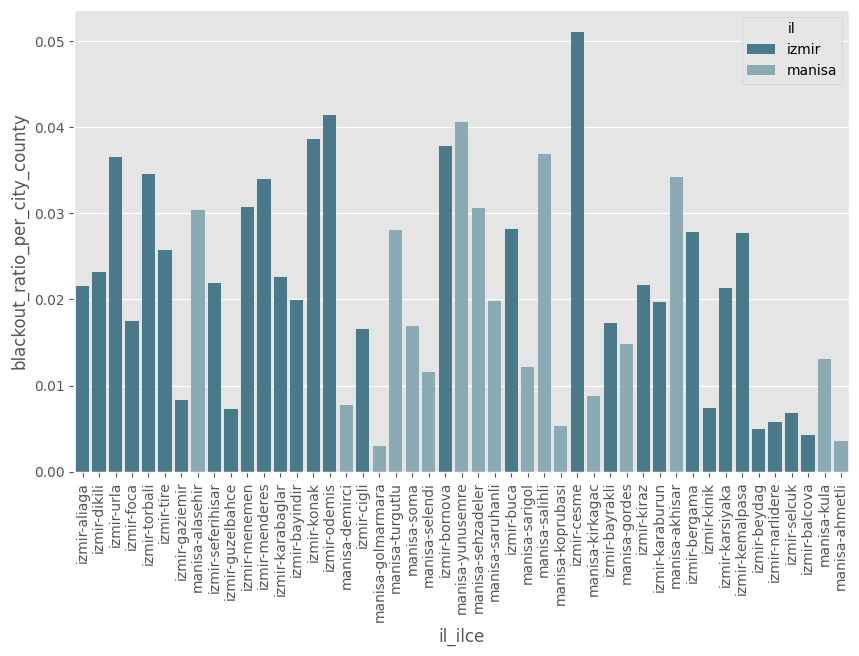

In [1743]:
plt.figure(figsize=(10, 6))
sns.barplot(x="il_ilce", y="blackout_ratio_per_city_county",data=train_test_concat,hue="il")
plt.xticks(rotation=90)
plt.show()

**Planlı kesintiye göre (bildirimli_sum) İl ve İlçe bazlı analiz**

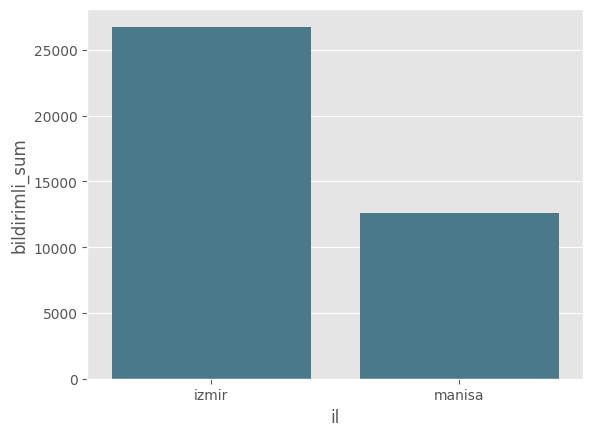

In [1744]:
il_group=train_test_concat.groupby("il")["bildirimli_sum"].sum().reset_index()
sns.barplot(x="il",y="bildirimli_sum",data=il_group)
plt.show()

**İl ve İlçe planlı kesinti toplam sayıları**
- İzmir ilinde toplam planlı kesinti sayısının en fazla olduğu ilk  3 ilçe bornova, ödemiş ve buca iken en az olan 3 ilçe güzelbahçe, balçova ve beydağ ilçeleridir. Planlı kesintide bornova ilk sıraya gelmiştir.
- Manisa ilinde toplam planlı kesinti sayısının en fazla olduğu ilk  3 ilçe akhisar, yunusemre, salihli iken en az olan 3 ilçe selendi, ahmetli ve gölmarmara ilçeleridir. Burdada ilk sıraya akhisar gelmiştir.
- Planlı kesintinin olduğu yerlerde altyapı çalışmaları olabilir.

In [1745]:
sorted_df_planli = train_test_concat.groupby(["il", "ilce"])["bildirimli_sum"].sum().reset_index().sort_values(by=["il", "bildirimli_sum"], ascending=[True, False])
sorted_df_planli["il_ilce"] = sorted_df_planli["il"] + "-" + sorted_df_planli["ilce"]
sorted_df_planli = sorted_df_planli.drop(columns=["il", "ilce"])
sorted_df_planli = sorted_df_planli[["il_ilce", "bildirimli_sum"]].reset_index(drop=True)
sorted_df_planli.head()

il_ilce  bildirimli_sum
0  izmir-bornova            2027
1   izmir-odemis            1844
2     izmir-buca            1402
3    izmir-konak            1389
4  izmir-menemen            1293

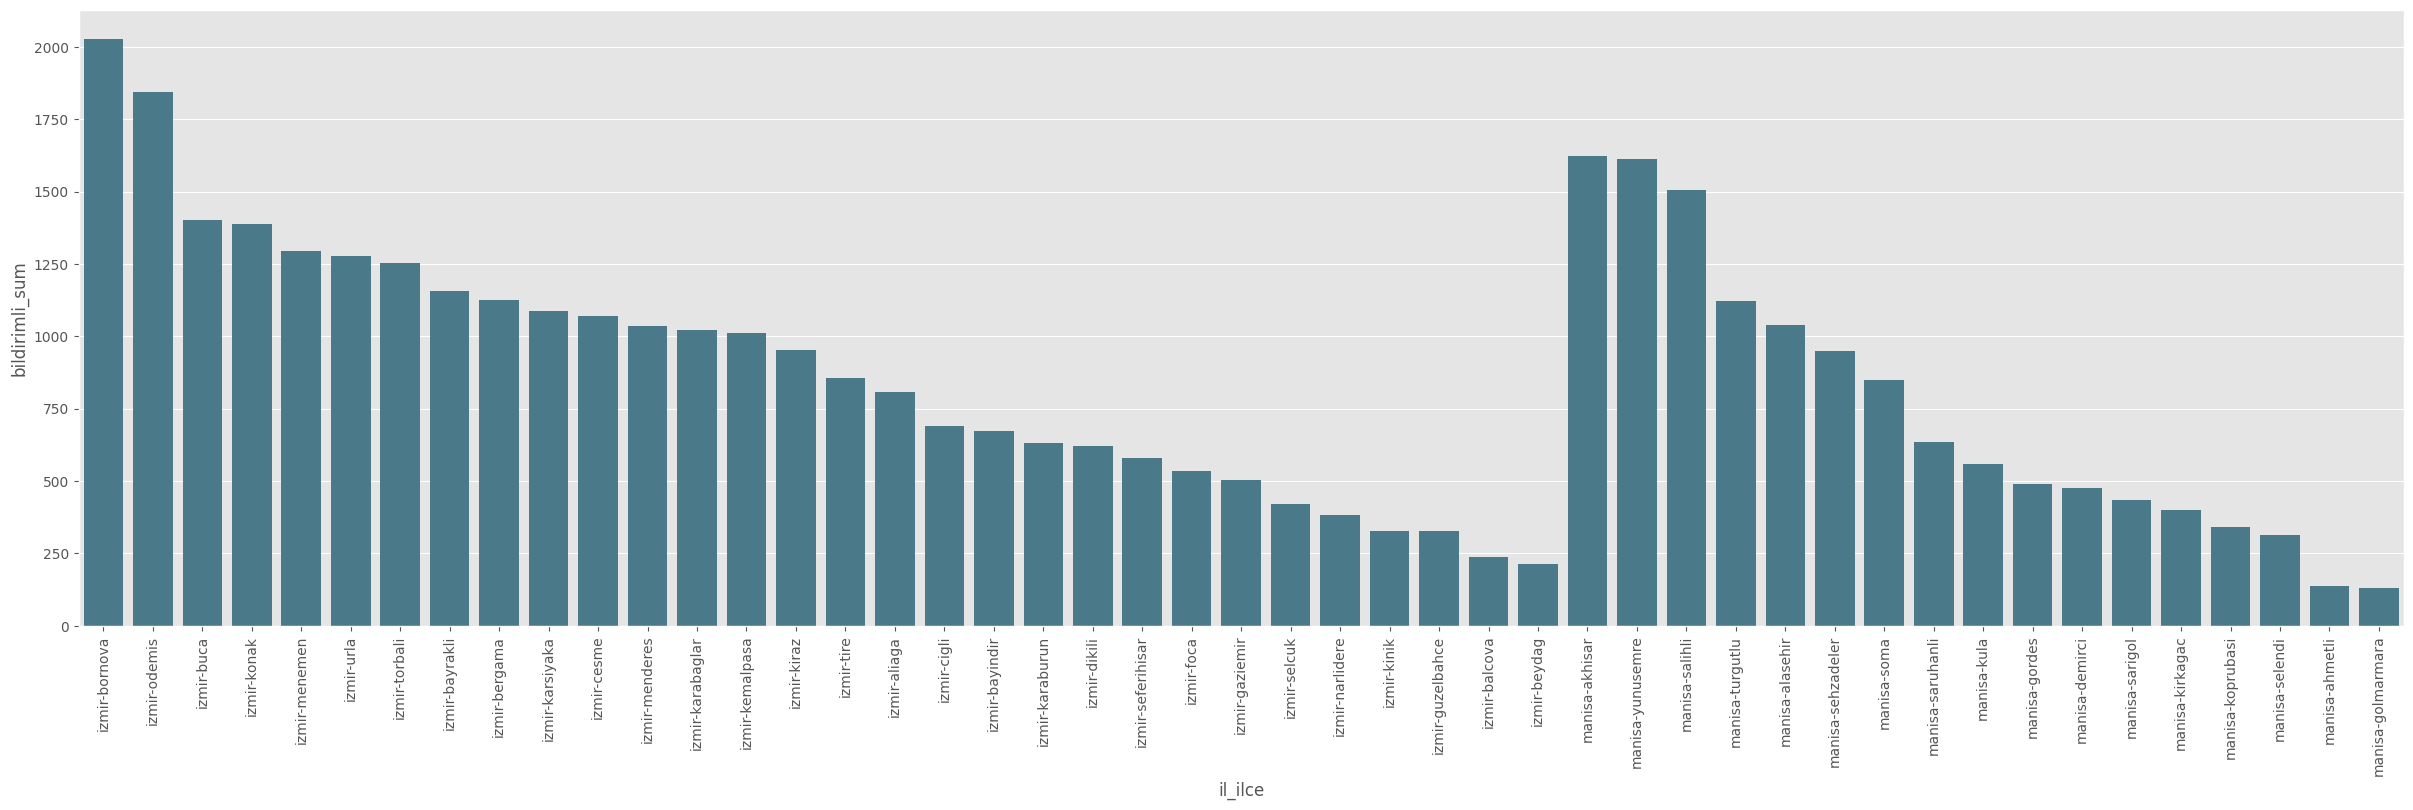

In [1746]:
plt.figure(figsize=(30, 8))
sns.barplot(x="il_ilce", y="bildirimli_sum", data=sorted_df_planli)
plt.xticks(rotation=90)
plt.show()

**il ve ilçe bazlı planlı elektrik kesintilerinin toplam planlı kesintiye oranı değişkeninin veri setine eklenmesi**

In [1747]:
sorted_df_planli["planned_blackout_ratio_per_city_county"] = sorted_df_planli["bildirimli_sum"] / sorted_df_planli["bildirimli_sum"].sum()
sorted_df_planli.drop("bildirimli_sum",inplace=True,axis=1)
sorted_series_planli = sorted_df_planli.set_index("il_ilce")["planned_blackout_ratio_per_city_county"]
train_test_concat["planned_blackout_ratio_per_city_county"] = train_test_concat["il_ilce"].map(sorted_series_planli)


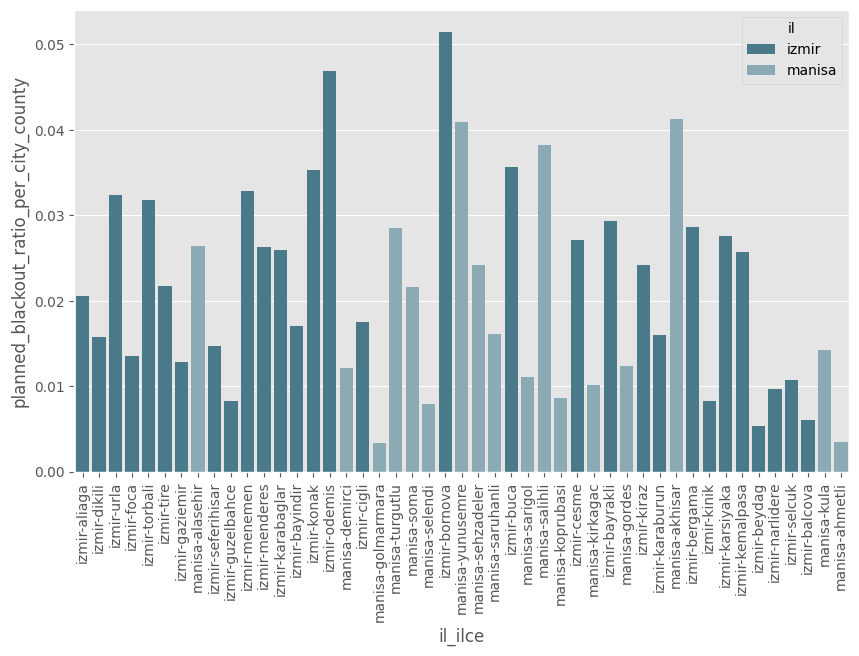

In [1748]:
plt.figure(figsize=(10, 6))
sns.barplot(x="il_ilce", y="planned_blackout_ratio_per_city_county",data=train_test_concat,hue="il")
plt.xticks(rotation=90)
plt.show()

**Train set bilgisi kullanılarak bildirimli ratio eklenme**

In [1749]:
train_test_concat[["year","month","day"]] = train_test_concat["tarih"].str.split("-",expand=True).astype(int)

In [1750]:
temp_train=train_test_concat[train_test_concat["unique_id"].isin(train["unique_id"])]
temp_test=train_test_concat[train_test_concat["unique_id"].isin(test["unique_id"])]

In [1751]:
sorted_df_planli_train = temp_train.groupby(["il", "ilce"])["bildirimli_sum"].sum().reset_index().sort_values(by=["il", "bildirimli_sum"], ascending=[True, False])
sorted_df_planli_train["il_ilce"] = sorted_df_planli_train["il"] + "-" + sorted_df_planli_train["ilce"]
sorted_df_planli_train = sorted_df_planli_train.drop(columns=["il", "ilce"])
sorted_df_planli_train = sorted_df_planli_train[["il_ilce", "bildirimli_sum"]].reset_index(drop=True)
sorted_df_planli_train.head()

il_ilce  bildirimli_sum
0  izmir-bornova            1952
1   izmir-odemis            1822
2    izmir-konak            1357
3     izmir-buca            1344
4  izmir-torbali            1236

In [1752]:
sorted_df_planli_train["bildirimli_sum_ratio_per_city_county"] = sorted_df_planli_train["bildirimli_sum"] / sorted_df_planli_train["bildirimli_sum"].sum()
sorted_df_planli_train.drop("bildirimli_sum",inplace=True,axis=1)
sorted_series_planli_bildirim = sorted_df_planli_train.set_index("il_ilce")["bildirimli_sum_ratio_per_city_county"]
train_test_concat["bildirimli_sum_ratio_per_city_county"] = train_test_concat["il_ilce"].map(sorted_series_planli_bildirim)
train_test_concat.head()

tarih        il_ilce  bildirimsiz_sum  bildirimli_sum  \
0  2021-01-01   izmir-aliaga              5.0               0   
1  2021-01-01   izmir-dikili              5.0               0   
2  2021-01-01     izmir-urla             18.0               0   
3  2021-01-01     izmir-foca              8.0               0   
4  2021-01-01  izmir-torbali              5.0               0   

                  unique_id     flag      lat     long  temp  cloud_cover  \
0   2021-01-01-izmir-aliaga  yilbasi  38.7996  26.9707  15.8         97.1   
1   2021-01-01-izmir-dikili  yilbasi  39.0749  26.8892  15.9         99.9   
2     2021-01-01-izmir-urla  yilbasi  38.3250  26.7668  15.6         99.1   
3     2021-01-01-izmir-foca  yilbasi  38.6704  26.7579  15.8         93.0   
4  2021-01-01-izmir-torbali  yilbasi  38.1558  27.3646  15.2         97.2   

   global_rad  relative_humidity  wind_dir  wind_speed  precip  temp_app  \
0       338.4               91.8     167.2         6.4     1.0      18.6   
1       296.0               93.8     160.2         5.5    12.0      17.9   
2       355.9               95.1     172.8         5.7     1.0      19.0   
3       380.9               91.8     168.8         7.2    12.8      18.8   
4       231.7               94.1     100.3         2.2     6.2      17.9   

   temp_measure_app_diff  cloud_cover_min  relative_humidity_min  \
0                    3.0             24.7                   75.7   
1                    3.0             17.1                   73.6   
2                    3.4             33.6                   80.7   
3                    3.3             24.8                   74.5   
4                    2.7             18.1                   83.2   

   wind_speed_min  precip_min  temp_min     il     ilce  \
0             1.8         1.0      11.3  izmir   aliaga   
1             1.4         1.0      11.5  izmir   dikili   
2             2.4         1.0      11.5  izmir     urla   
3             3.9         1.0      12.6  izmir     foca   
4             1.2         1.0       9.9  izmir  torbali   

   blackout_ratio_per_city_county  planned_blackout_ratio_per_city_county  \
0                        0.021574                                0.020552   
1                        0.023165                                0.015801   
2                        0.036536                                0.032415   
3                        0.017549                                0.013591   
4                        0.034582                                0.031806   

   year  month  day  bildirimli_sum_ratio_per_city_county  
0  2021      1    1                              0.020877  
1  2021      1    1                              0.015729  
2  2021      1    1                              0.032135  
3  2021      1    1                              0.013805  
4  2021      1    1                              0.032135

In [1753]:
sorted_df_planli_train.head()

il_ilce  bildirimli_sum_ratio_per_city_county
0  izmir-bornova                              0.050750
1   izmir-odemis                              0.047370
2    izmir-konak                              0.035281
3     izmir-buca                              0.034943
4  izmir-torbali                              0.032135

In [1754]:
train_test_concat.loc[train_test_concat["il_ilce"]=="izmir-bornova","bildirimli_sum_ratio_per_city_county"].head(1)

22    0.05075
Name: bildirimli_sum_ratio_per_city_county, dtype: float64

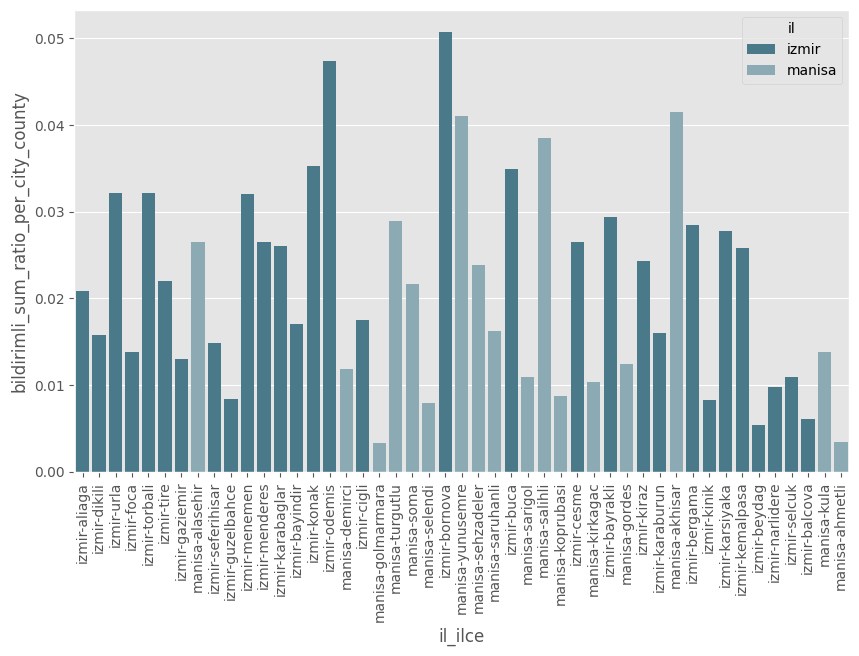

In [1755]:
plt.figure(figsize=(10, 6))
sns.barplot(x="il_ilce", y="bildirimli_sum_ratio_per_city_county",data=train_test_concat,hue="il")
plt.xticks(rotation=90)
plt.show()

**Tatil günleri bazlı analiz**
- Tatil günlerinden en fazla kesinti kurban bayramı ve demokrasi ve milli birlik gününde meydana gelmiş

Özel günlerin sayısı

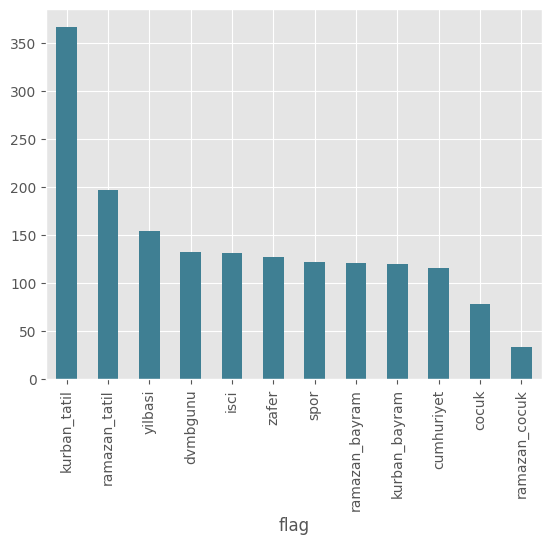

In [1756]:
train_test_concat[train_test_concat["flag"]!="normal"]["flag"].value_counts().plot(kind="bar")
plt.show()

Özel günlere göre kesinti toplamları

In [1757]:
holidays=train_test_concat.groupby("flag")["bildirimsiz_sum"].sum().reset_index().sort_values(by=["bildirimsiz_sum"], ascending=[False])
holidays_except_normal=holidays[holidays["flag"]!="normal"]

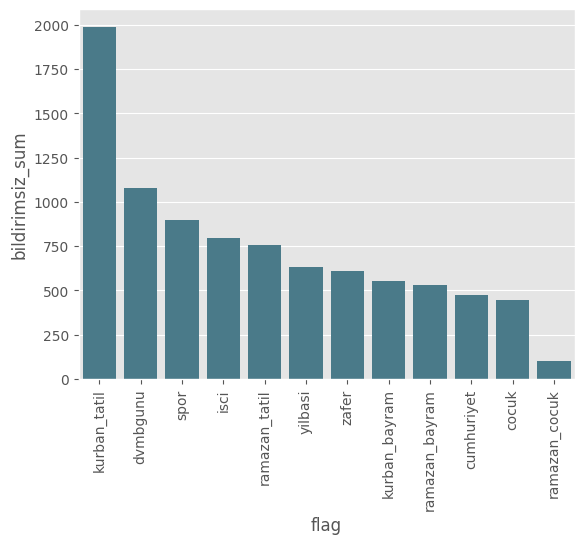

In [1758]:
sns.barplot(x="flag",y="bildirimsiz_sum",data=holidays_except_normal)
plt.xticks(rotation=90)
plt.show()

**Sayısal Değişkenlerin Analizi**

In [1759]:
train_test_concat.describe().T

count         mean         std  \
bildirimsiz_sum                         48148.0     5.886911    5.425645   
bildirimli_sum                          49511.0     0.795056    1.309763   
lat                                     49511.0    38.535126    0.301920   
long                                    49511.0    27.502125    0.625106   
temp                                    49511.0    22.656125    8.893033   
cloud_cover                             49511.0    59.598253   37.431510   
global_rad                              49511.0   669.067932  223.410178   
relative_humidity                       49511.0    83.483355   12.293861   
wind_dir                                49511.0   156.199457   75.806460   
wind_speed                              49511.0     4.496383    2.006146   
precip                                  49511.0    13.700402   27.236393   
temp_app                                49511.0    27.108089   10.247455   
temp_measure_app_diff                   49511.0     5.281558    1.986155   
cloud_cover_min                         49511.0     7.235140   16.334423   
relative_humidity_min                   49511.0    42.699608   16.320206   
wind_speed_min                          49511.0     1.322419    1.399209   
precip_min                              49511.0     1.001931    0.122985   
temp_min                                49511.0    12.815320    7.241180   
blackout_ratio_per_city_county          49511.0     0.022600    0.011715   
planned_blackout_ratio_per_city_county  49511.0     0.022464    0.011557   
year                                    49511.0  2022.105714    0.916452   
month                                   49511.0     6.263840    3.538062   
day                                     49511.0    15.697784    8.782340   
bildirimli_sum_ratio_per_city_county    49511.0     0.022460    0.011520   

                                                min          25%          50%  \
bildirimsiz_sum                            0.000000     2.000000     4.000000   
bildirimli_sum                             0.000000     0.000000     0.000000   
lat                                       37.950800    38.325000    38.471000   
long                                      26.303200    27.069700    27.381800   
temp                                      -2.700000    15.800000    21.900000   
cloud_cover                                0.000000    24.900000    64.800000   
global_rad                                27.600000   491.500000   691.100000   
relative_humidity                         30.300000    75.500000    85.700000   
wind_dir                                   5.000000   106.500000   155.800000   
wind_speed                                 0.700000     3.000000     4.200000   
precip                                     1.000000     1.000000     1.000000   
temp_app                                  -5.300000    19.100000    26.000000   
temp_measure_app_diff                     -4.400000     3.900000     5.400000   
cloud_cover_min                            0.000000     0.000000     0.000000   
relative_humidity_min                      5.600000    29.700000    42.400000   
wind_speed_min                             0.000000     0.400000     0.800000   
precip_min                                 1.000000     1.000000     1.000000   
temp_min                                 -12.600000     7.400000    12.800000   
blackout_ratio_per_city_county             0.002971     0.013103     0.021645   
planned_blackout_ratio_per_city_county     0.003303     0.012804     0.021771   
year                                    2021.000000  2021.000000  2022.000000   
month                                      1.000000     3.000000     6.000000   
day                                        1.000000     8.000000    16.000000   
bildirimli_sum_ratio_per_city_county       0.003328     0.013026     0.021943   

                                                75%          max  
bildirimsiz_sum                            8.000

In [1760]:
train_test_concat.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49511 entries, 0 to 49510
Data columns (total 30 columns):
 #   Column                                  Non-Null Count  Dtype  
---  ------                                  --------------  -----  
 0   tarih                                   49511 non-null  object 
 1   il_ilce                                 49511 non-null  object 
 2   bildirimsiz_sum                         48148 non-null  float64
 3   bildirimli_sum                          49511 non-null  int64  
 4   unique_id                               49511 non-null  object 
 5   flag                                    49511 non-null  object 
 6   lat                                     49511 non-null  float64
 7   long                                    49511 non-null  float64
 8   temp                                    49511 non-null  float64
 9   cloud_cover                             49511 non-null  float64
 10  global_rad                              49511 non-null  fl

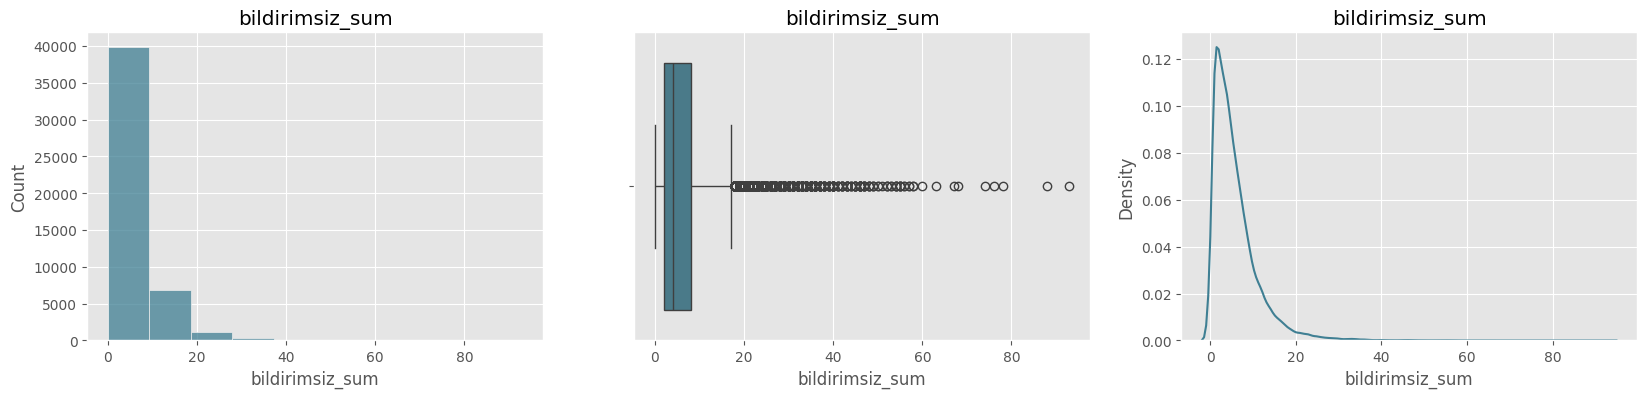

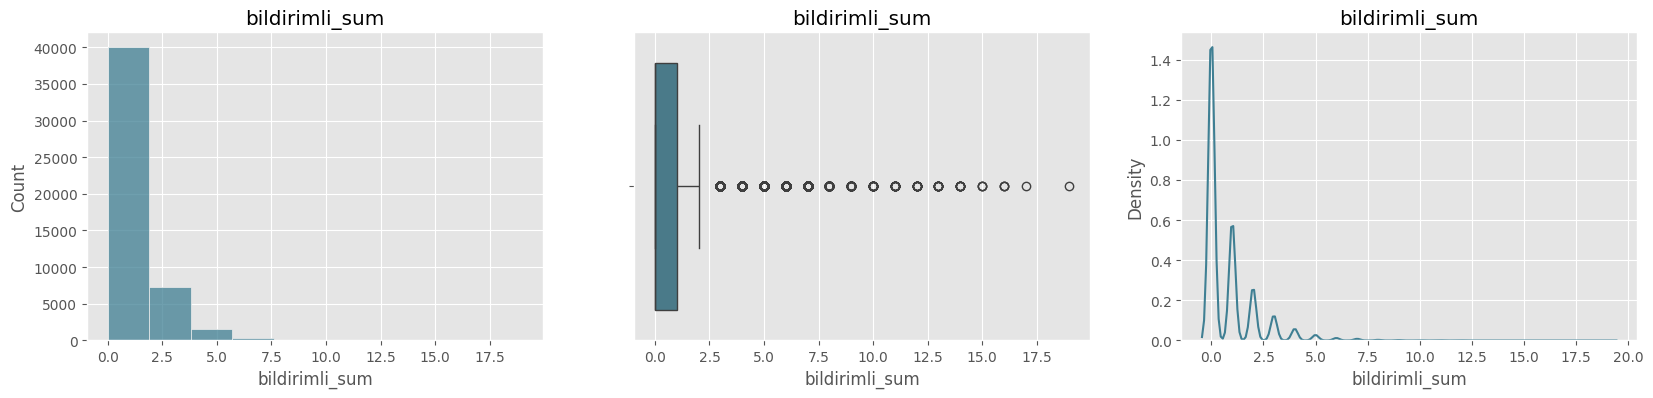

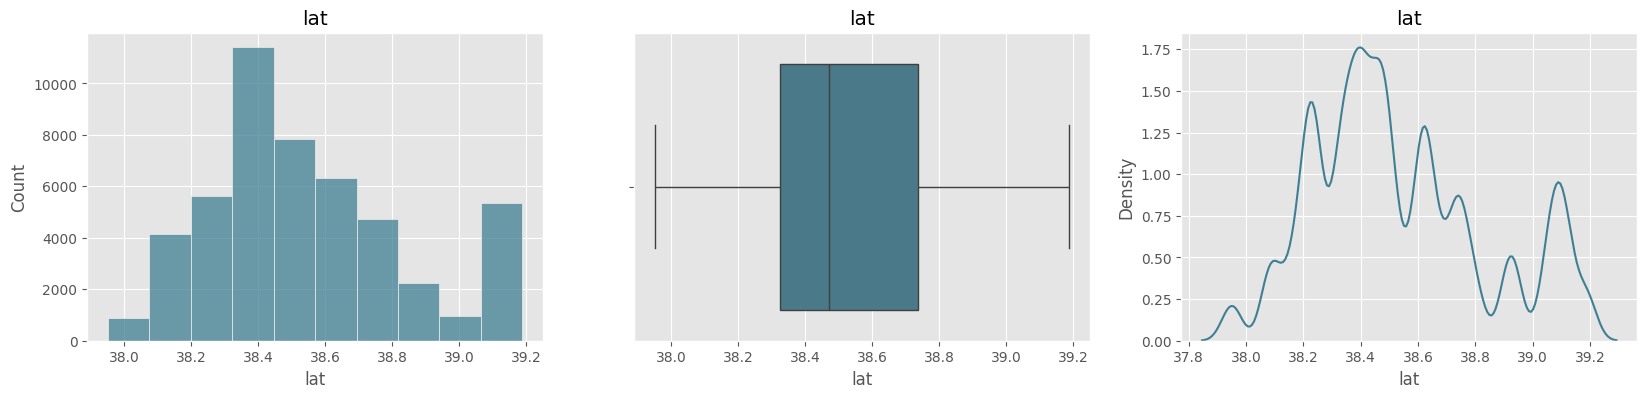

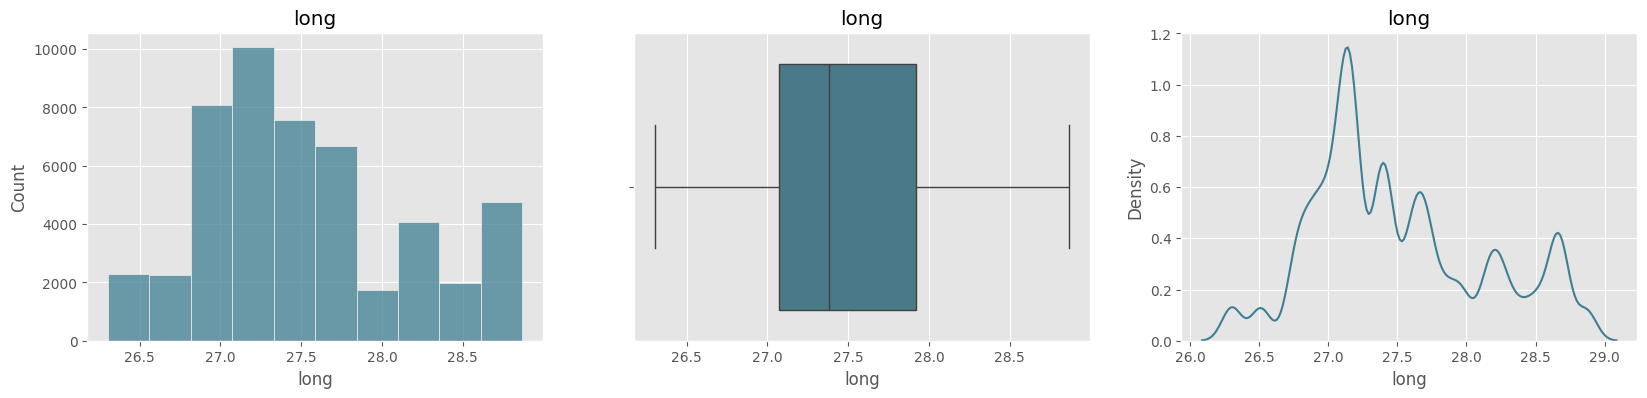

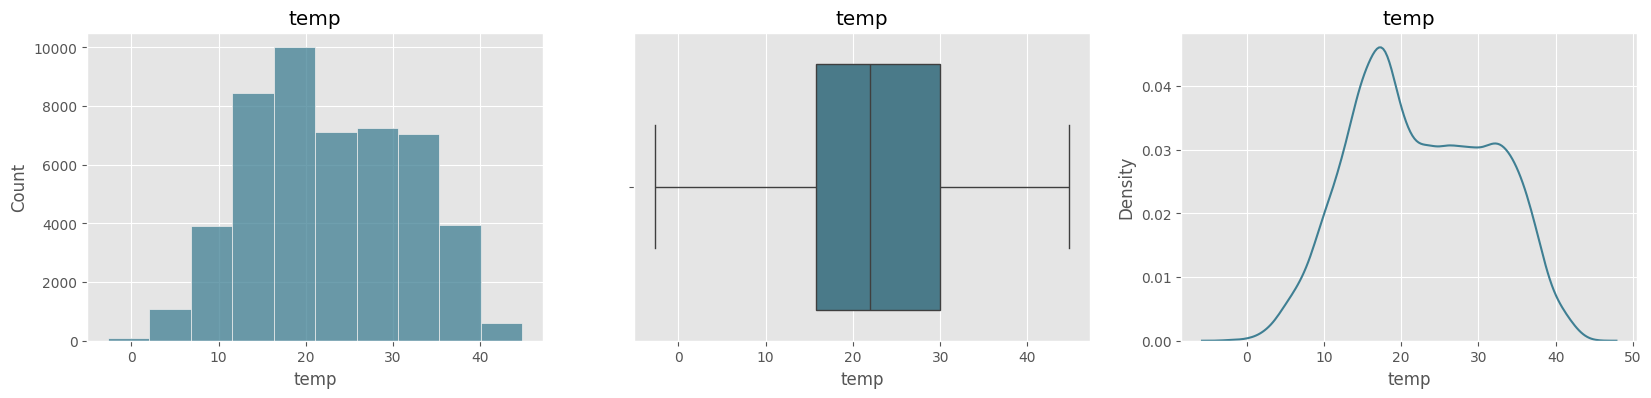

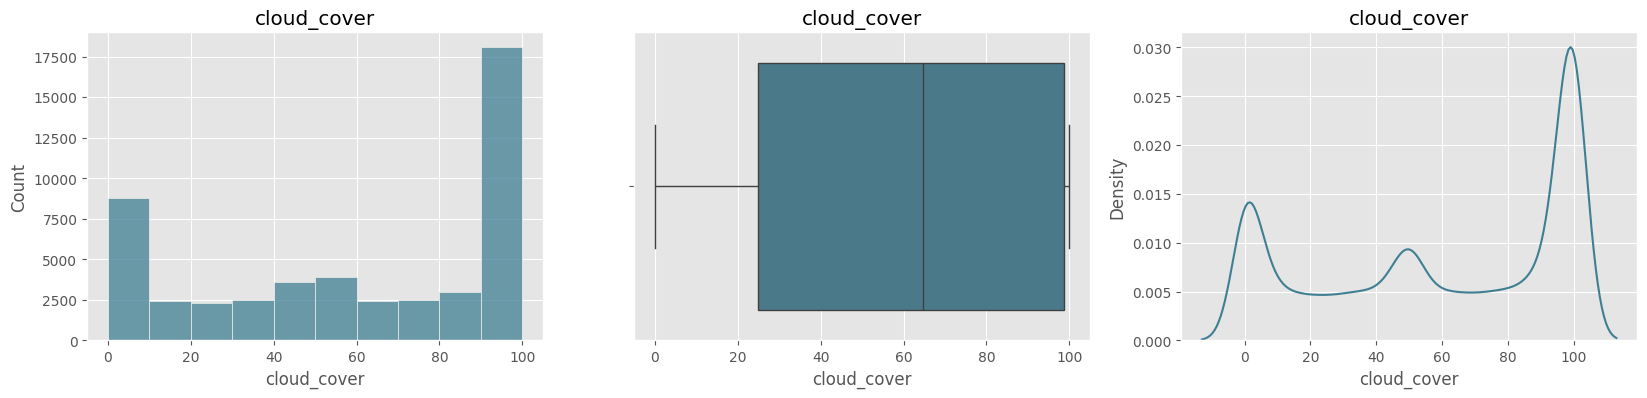

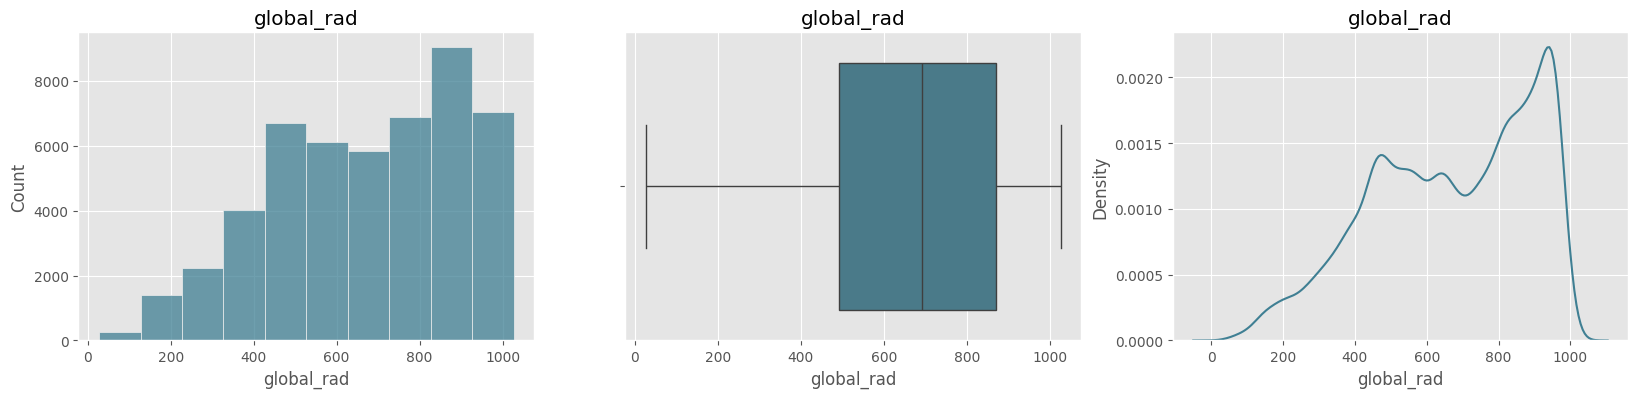

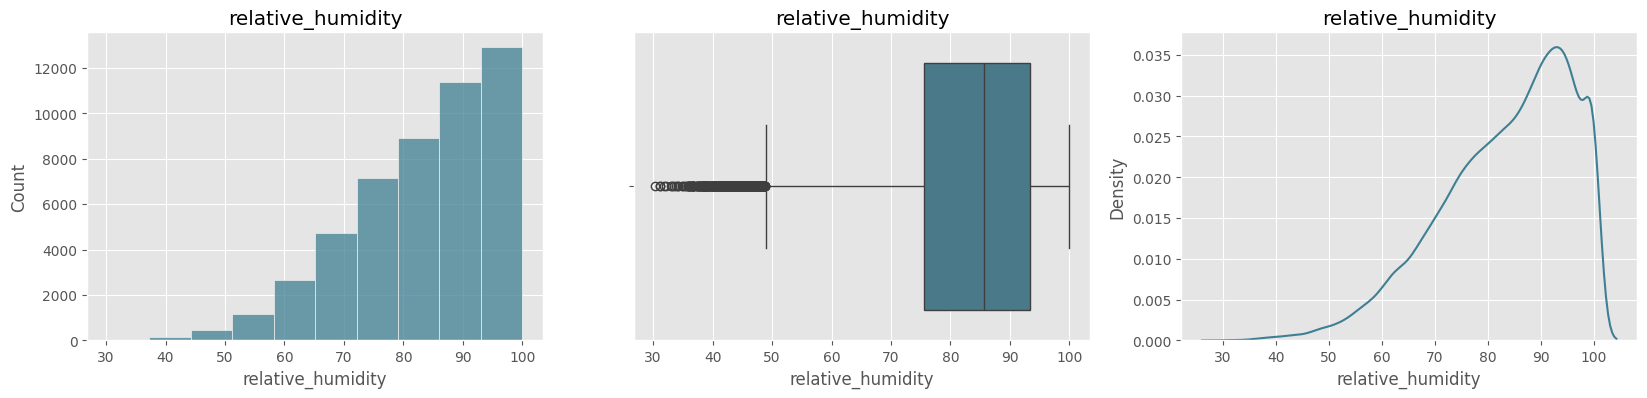

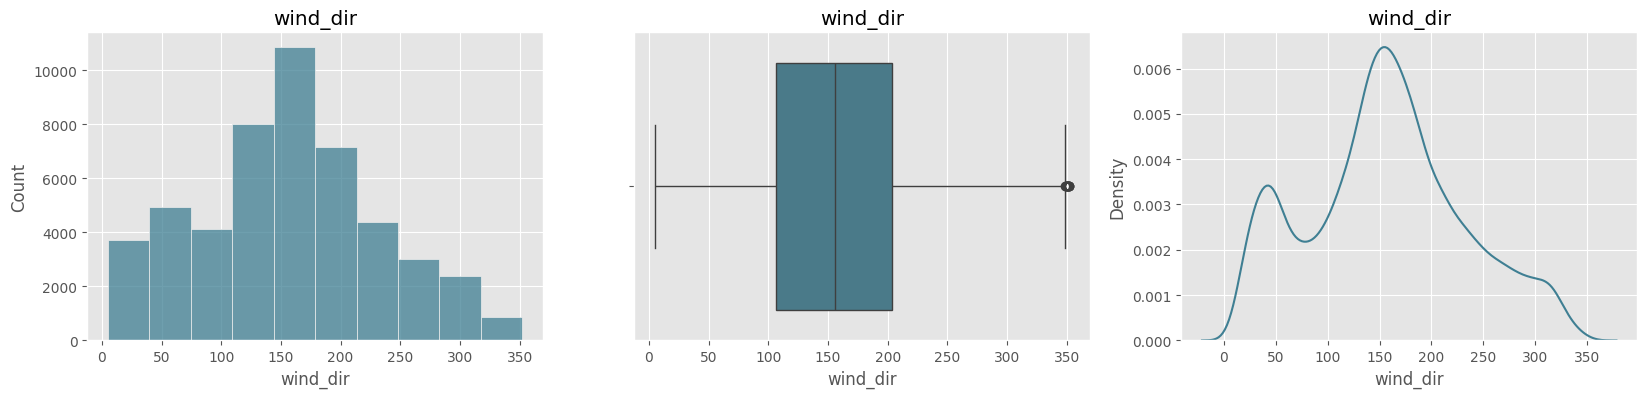

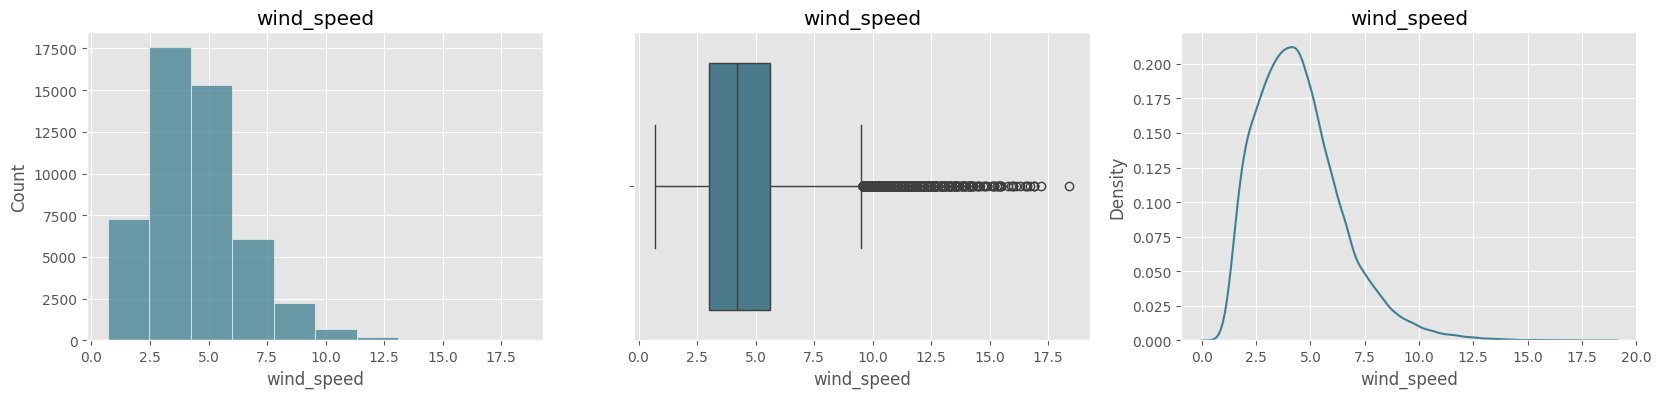

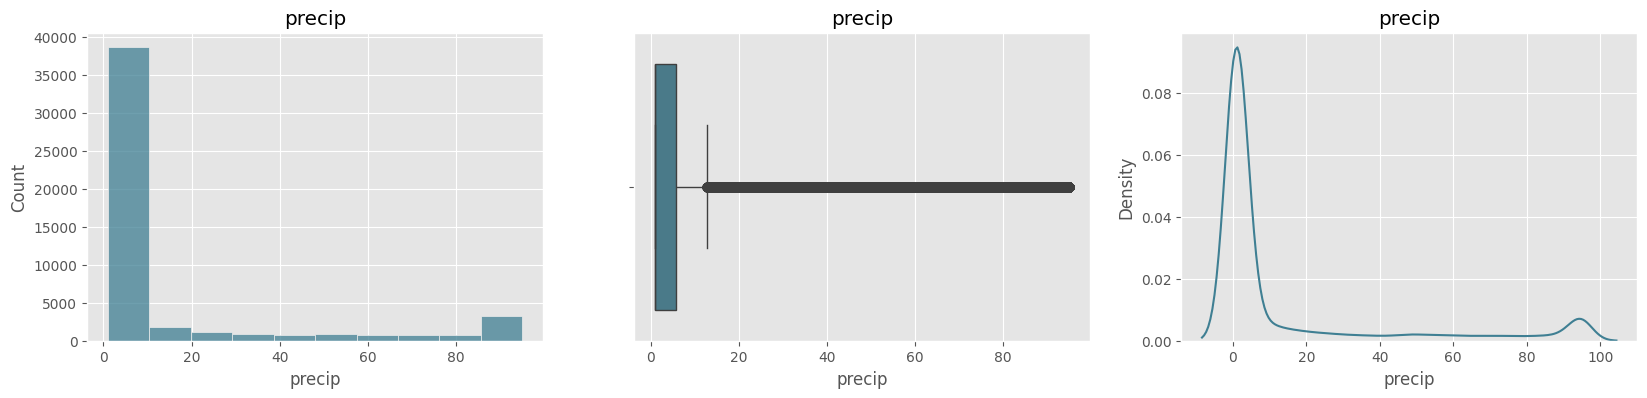

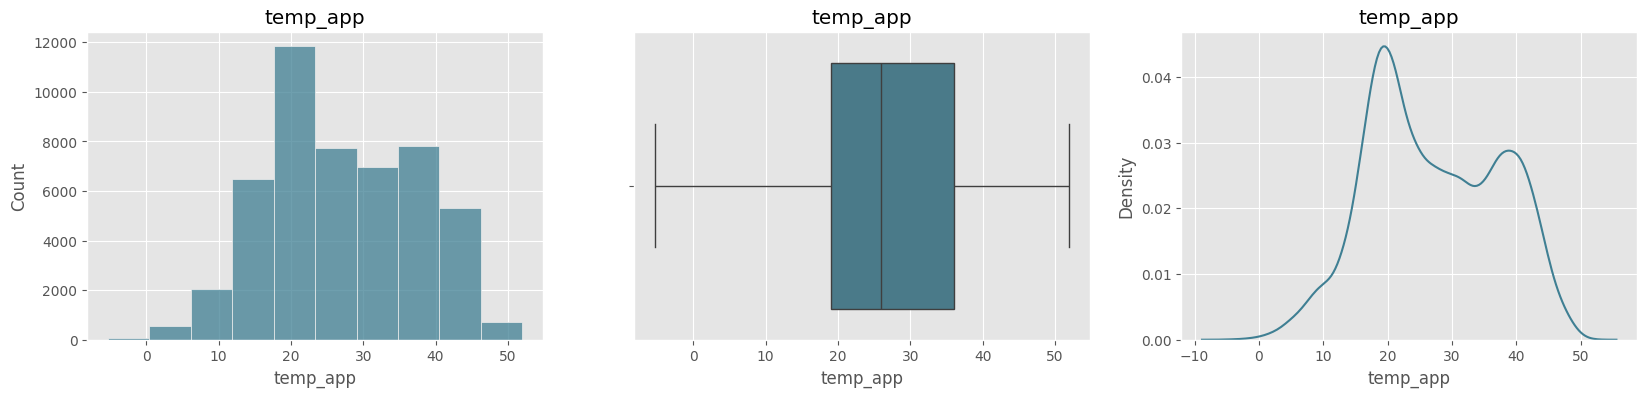

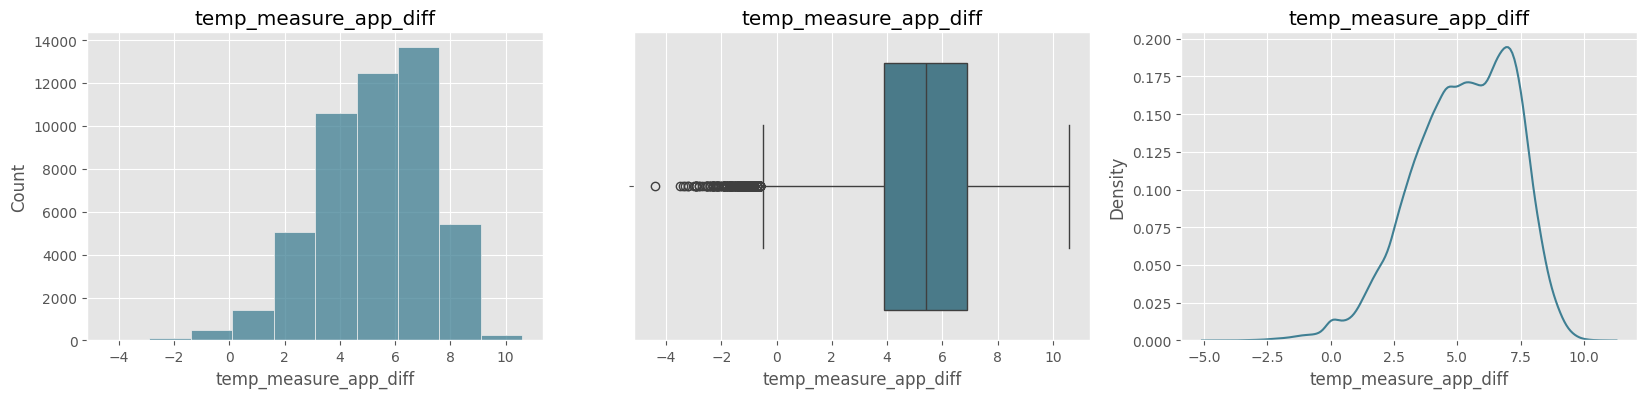

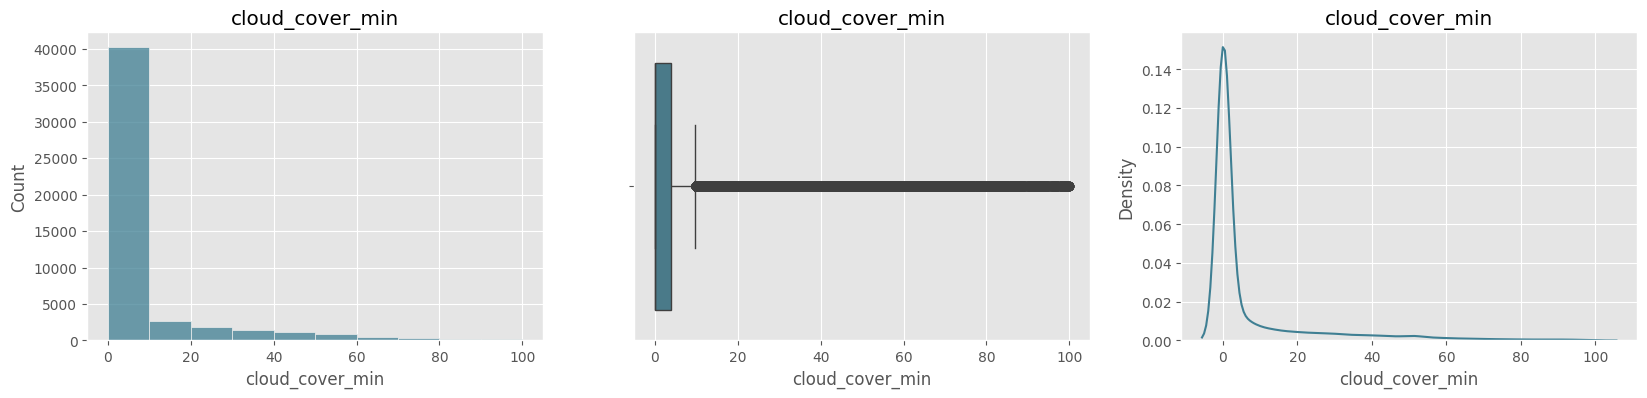

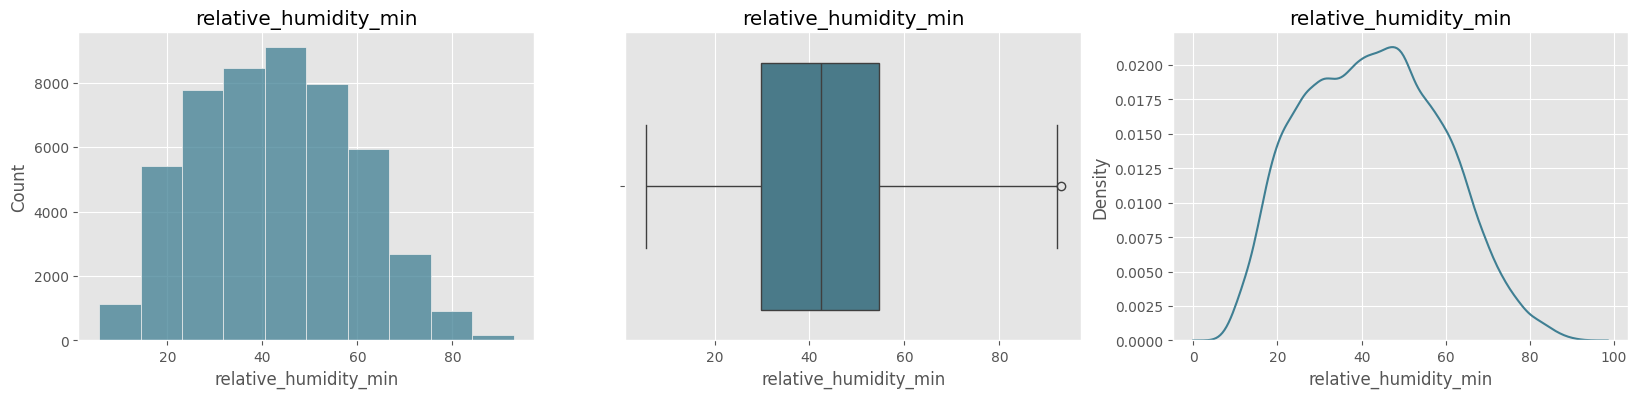

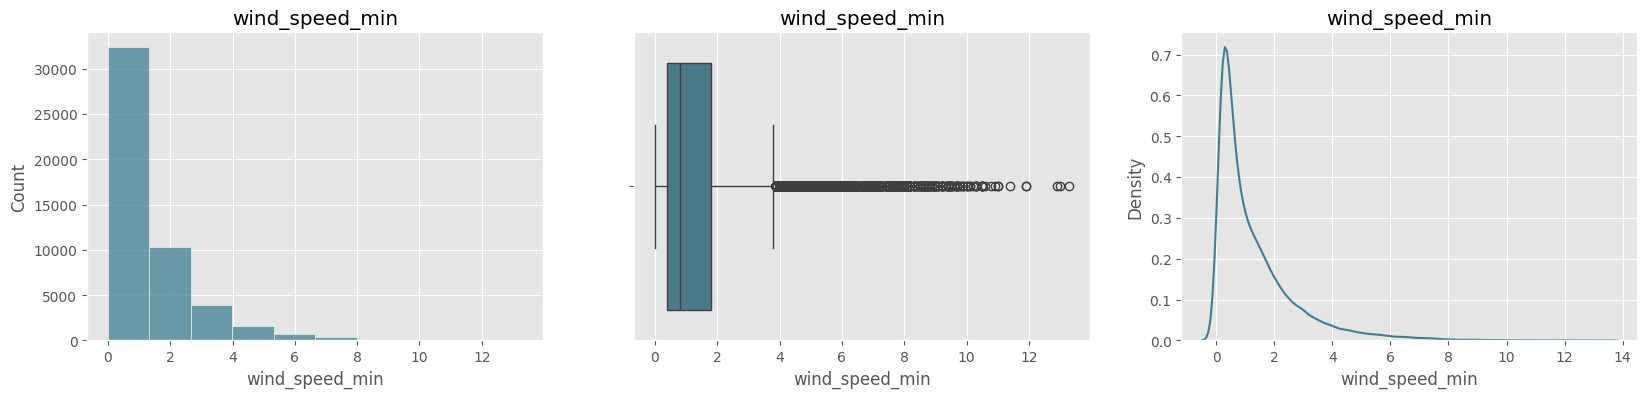

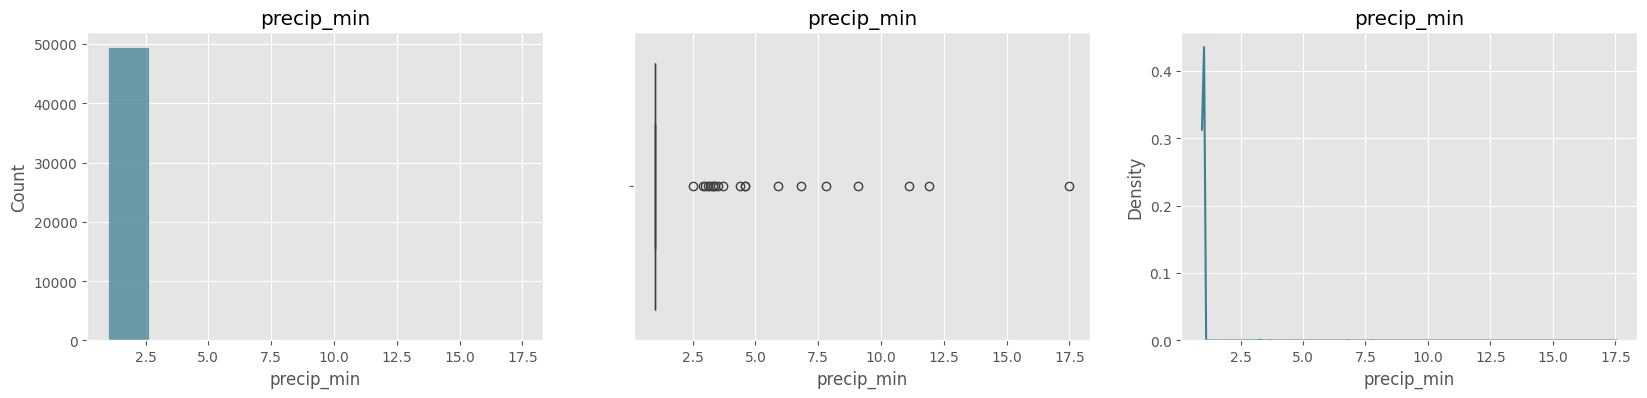

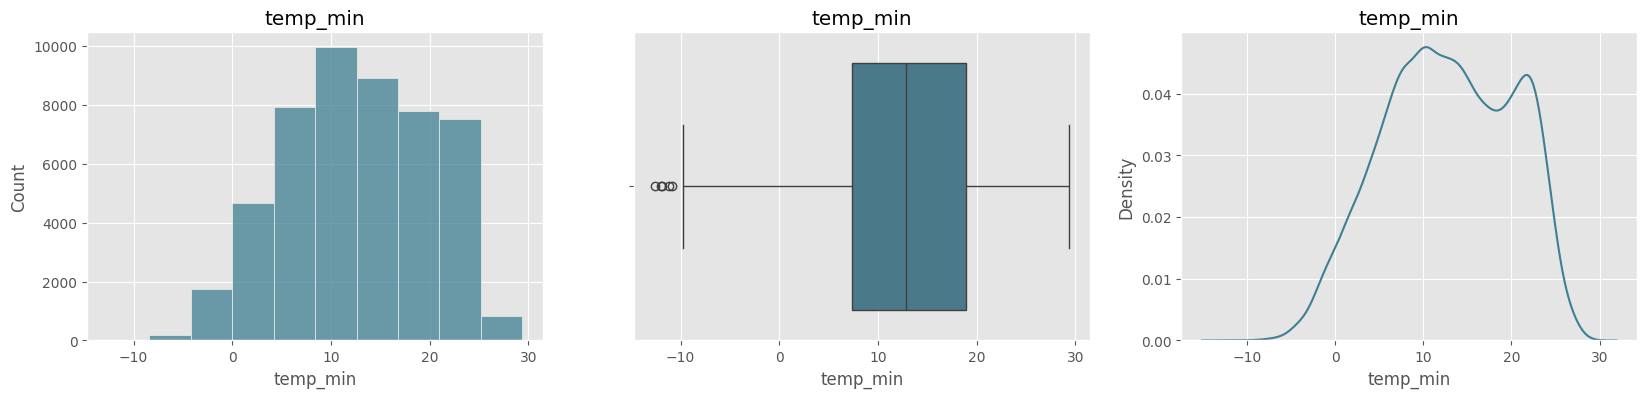

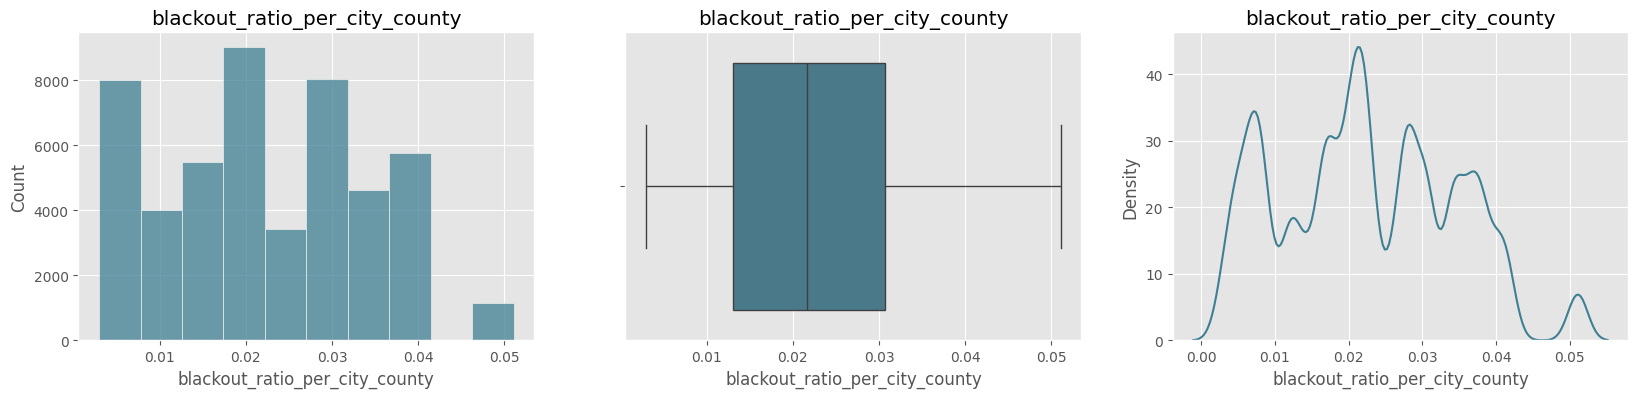

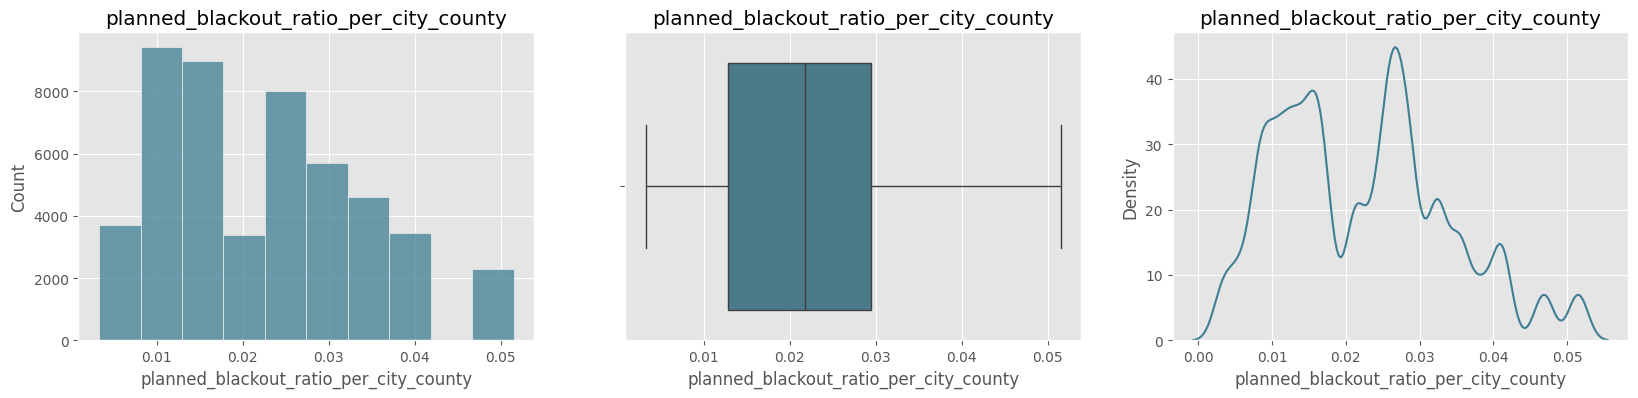

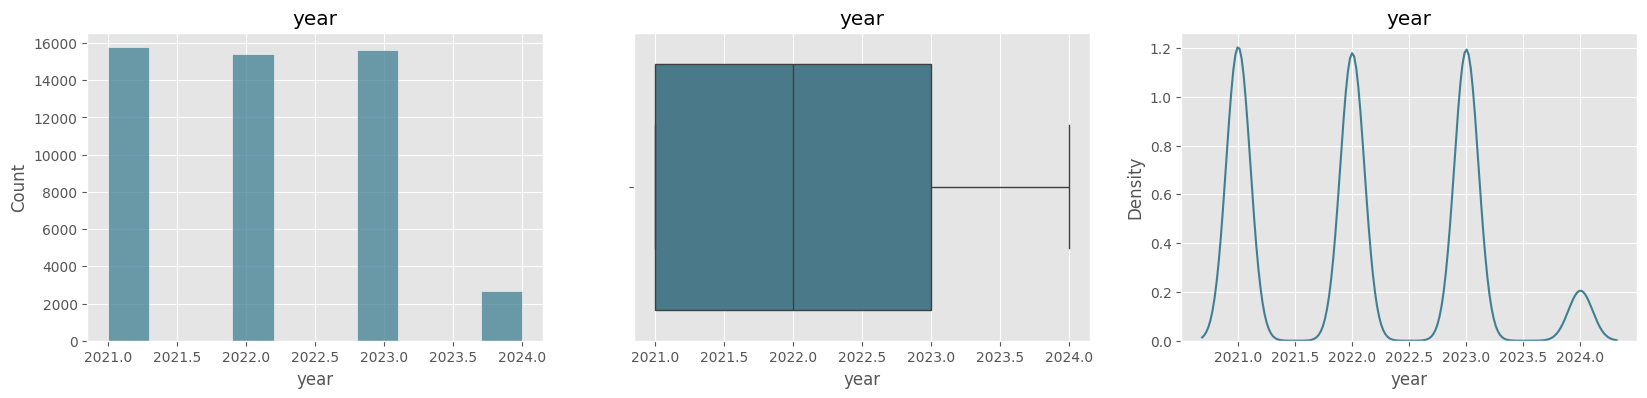

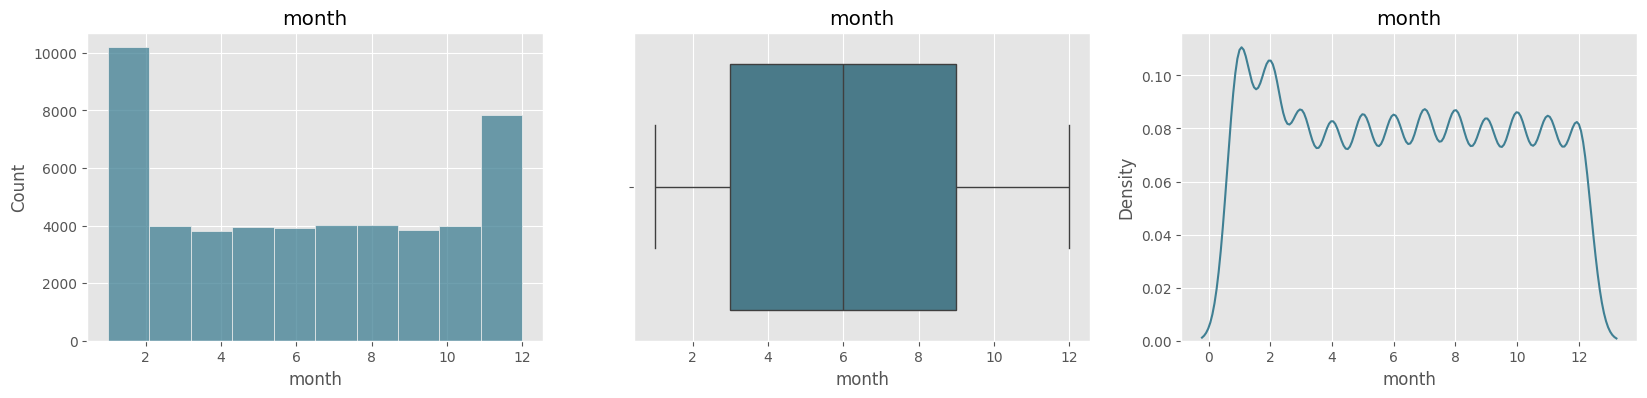

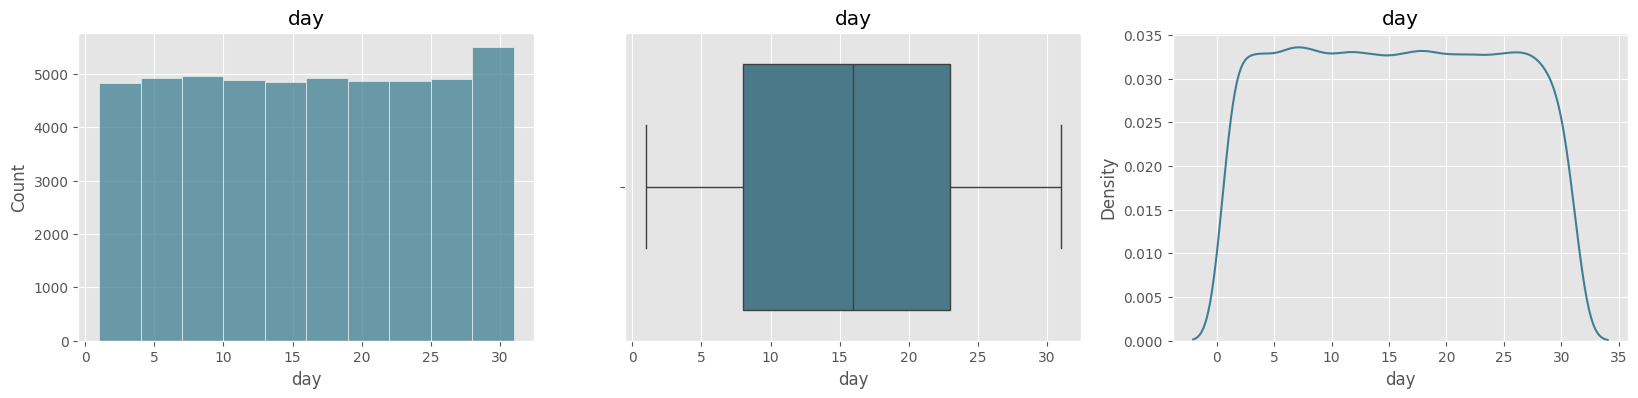

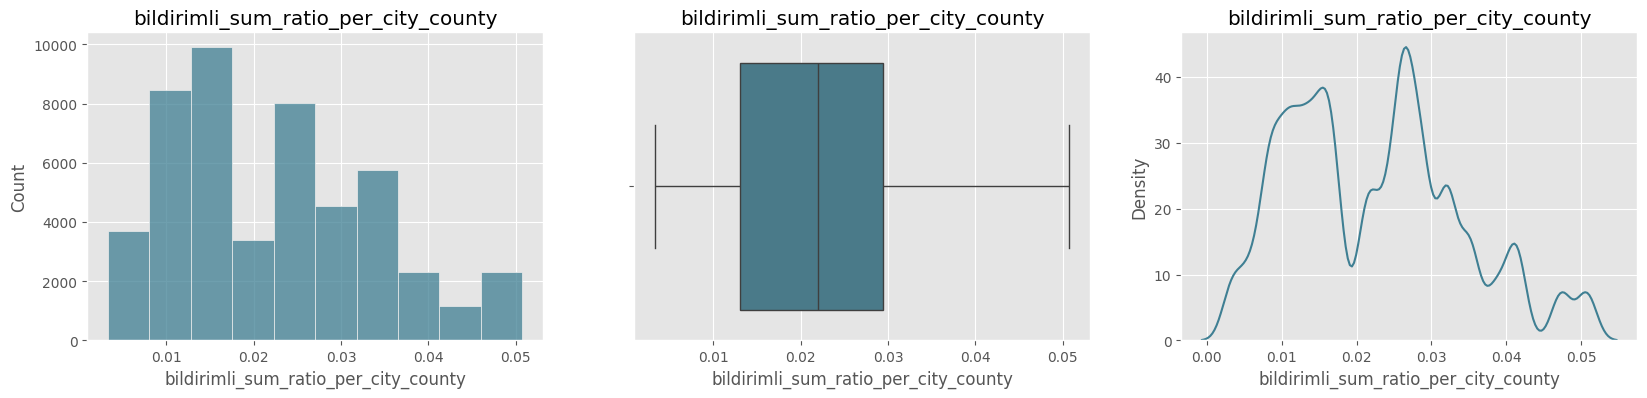

In [1761]:
single_variable_multiple_plot(train_test_concat,numeric=True)

**Bildirmli - Bildirimsiz sum aykırı değerler**

**Bildirimsiz**

In [1762]:
def outlier_thresholds(dataframe, variable, q1_thr=0.25, q3_thr=0.75):
    """
    Calculate the lower and upper bounds to cap outliers in a variable.

    Parameters
    ----------
    dataframe : pandas.DataFrame
        The DataFrame containing the variable.
    variable : str
        The name of the variable for which to calculate the outlier thresholds.
    q1_thr : float, optional
        The quantile value for the lower quartile. Default is 0.25.
    q3_thr : float, optional
        The quantile value for the upper quartile. Default is 0.75.

    Returns
    -------
    low_limit : float
        The lower bound threshold for capping outliers.
    up_limit : float
        The upper bound threshold for capping outliers.
    """
    quartile1 = dataframe[variable].quantile(q1_thr)
    quartile3 = dataframe[variable].quantile(q3_thr)
    interquantile_range = quartile3 - quartile1
    up_limit = quartile3 + 1.5 * interquantile_range
    low_limit = quartile1 - 1.5 * interquantile_range
    return low_limit, up_limit

In [1763]:
train_test_concat[["bildirimsiz_sum"]].describe([0.02,0.05,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,0.95,0.98]).T

count      mean       std  min   2%   5%  10%  20%  30%  \
bildirimsiz_sum  48148.0  5.886911  5.425645  0.0  0.0  1.0  1.0  2.0  3.0   

                 40%  50%  60%  70%  80%   90%   95%   98%   max  
bildirimsiz_sum  4.0  4.0  6.0  7.0  9.0  12.0  16.0  21.0  93.0

In [1764]:
train_test_concat.loc[train_test_concat["bildirimsiz_sum"]> 21, ["il_ilce","bildirimli_sum","bildirimsiz_sum"]].shape

(954, 3)

In [1765]:
low_limit, up_limit = outlier_thresholds(train_test_concat,"bildirimsiz_sum",q1_thr=0.10, q3_thr=0.90)
train_test_concat[(train_test_concat["bildirimsiz_sum"] < low_limit) | (train_test_concat["bildirimsiz_sum"] > up_limit)].shape

(349, 30)

In [1766]:
train_test_concat.loc[(train_test_concat["bildirimsiz_sum"] > up_limit), "bildirimsiz_sum"] = up_limit

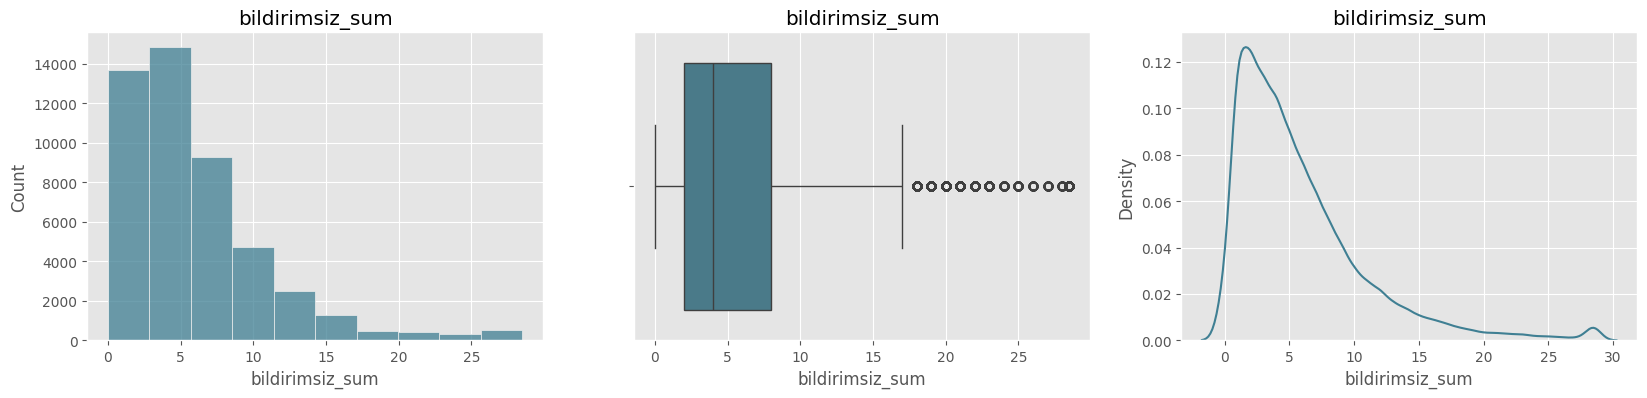

In [1767]:
single_variable_multiple_plot(train_test_concat[["bildirimsiz_sum"]],numeric=True)

**Bildirimli**

In [1768]:
train_test_concat[["bildirimli_sum"]].describe([0.02,0.05,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,0.95,0.98]).T

count      mean       std  min   2%   5%  10%  20%  30%  \
bildirimli_sum  49511.0  0.795056  1.309763  0.0  0.0  0.0  0.0  0.0  0.0   

                40%  50%  60%  70%  80%  90%  95%  98%   max  
bildirimli_sum  0.0  0.0  1.0  1.0  1.0  2.0  3.0  5.0  19.0

In [1769]:
train_test_concat.loc[train_test_concat["bildirimli_sum"]> 5, ["il_ilce","bildirimli_sum","bildirimli_sum"]].shape

(550, 3)

In [1770]:
low_limit, up_limit = outlier_thresholds(train_test_concat,"bildirimli_sum",q1_thr=0.10, q3_thr=0.90)
train_test_concat[(train_test_concat["bildirimli_sum"] < low_limit) | (train_test_concat["bildirimli_sum"] > up_limit)].shape

(550, 30)

In [1771]:
train_test_concat.loc[(train_test_concat["bildirimli_sum"] > up_limit), "bildirimli_sum"] = up_limit

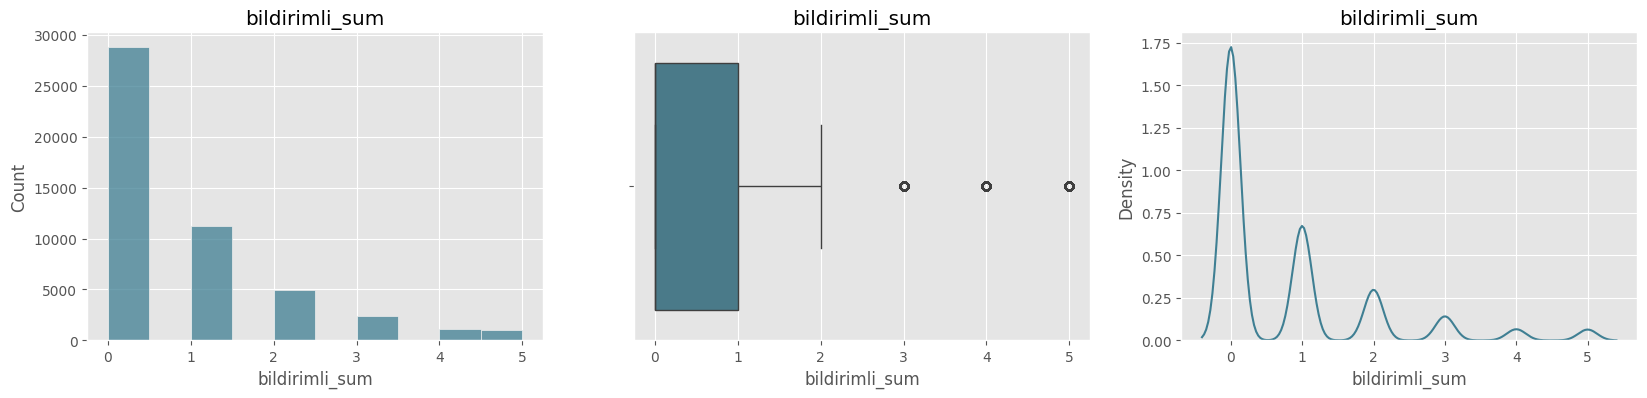

In [1772]:
single_variable_multiple_plot(train_test_concat[["bildirimli_sum"]],numeric=True)

**Tarih Değişkenlerinin Eklenmesi**
- Yıl ve ay etkili olabileceği için oranlar yıl ve aya göre oluşturuldu.

In [1773]:
train_test_concat[["year","month","day"]] = train_test_concat["tarih"].str.split("-",expand=True).astype(int)

**Yıl değişkeni**

**Bildirimsiz**

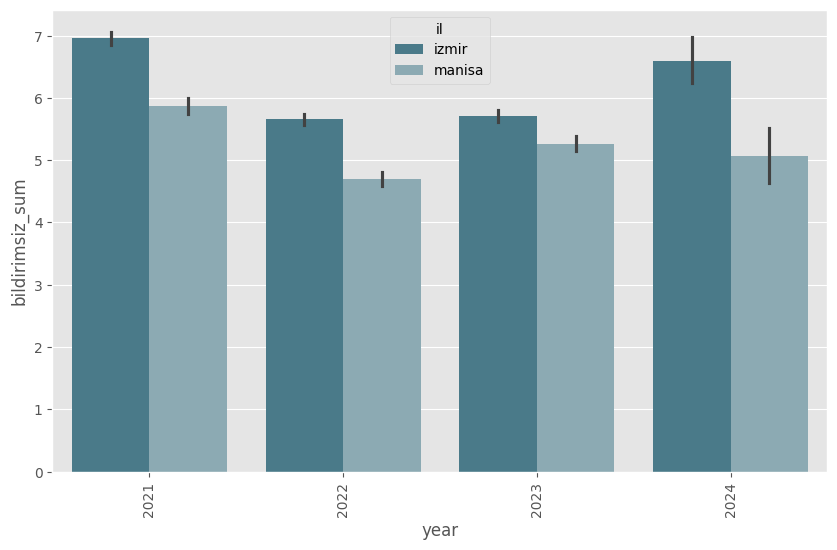

In [1774]:
plt.figure(figsize=(10, 6))
sns.barplot(x="year", y="bildirimsiz_sum",hue="il",data=train_test_concat)
plt.xticks(rotation=90)
plt.show()

In [1775]:
def add_ratio_by_category(df:pd.DataFrame, category:str, target:str):
    new_ratio_feature_name = f"{category}_{target}_ratio"
    temp_df = df.groupby(category)[target].sum().reset_index()
    temp_df[new_ratio_feature_name] = temp_df[target] / temp_df[target].sum()
    temp_df.drop(target, axis=1, inplace=True)
    temp_series=temp_df.set_index(category)[new_ratio_feature_name]
    df[new_ratio_feature_name] = df[category].map(temp_series)
    print(f"New {new_ratio_feature_name} has been added to dataframe.")
    print("-------------------------------------------------")
    print(df.groupby(category)[new_ratio_feature_name].mean().reset_index().head())

In [1776]:
add_ratio_by_category(train_test_concat, "year", "bildirimsiz_sum")

New year_bildirimsiz_sum_ratio has been added to dataframe.
-------------------------------------------------
   year  year_bildirimsiz_sum_ratio
0  2021                    0.369362
1  2022                    0.292872
2  2023                    0.309214
3  2024                    0.028551


**Bildirimli**

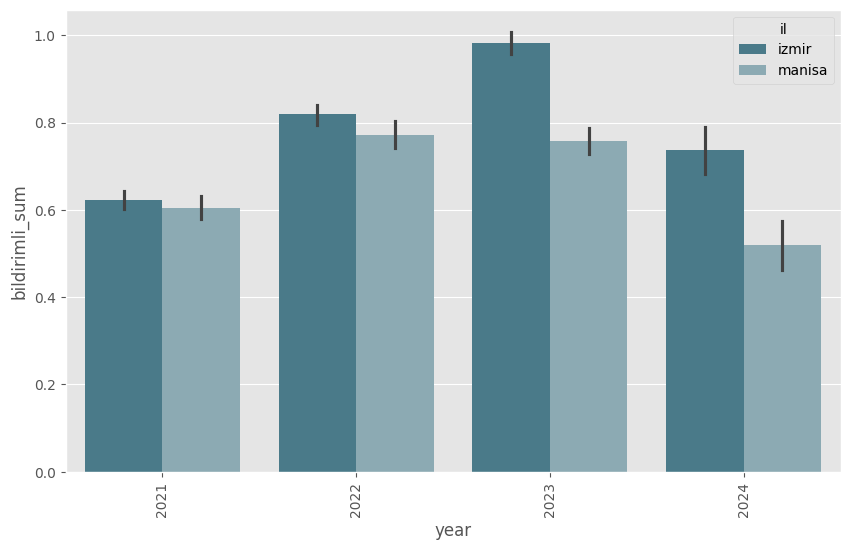

In [1777]:
plt.figure(figsize=(10, 6))
sns.barplot(x="year", y="bildirimli_sum",hue="il",data=train_test_concat)
plt.xticks(rotation=90)
plt.show()

In [1778]:
add_ratio_by_category(train_test_concat, "year", "bildirimli_sum")

New year_bildirimli_sum_ratio has been added to dataframe.
-------------------------------------------------
   year  year_bildirimli_sum_ratio
0  2021                   0.255514
1  2022                   0.326078
2  2023                   0.371822
3  2024                   0.046586


**Ay Değişkeni**

**Bildirimsiz**

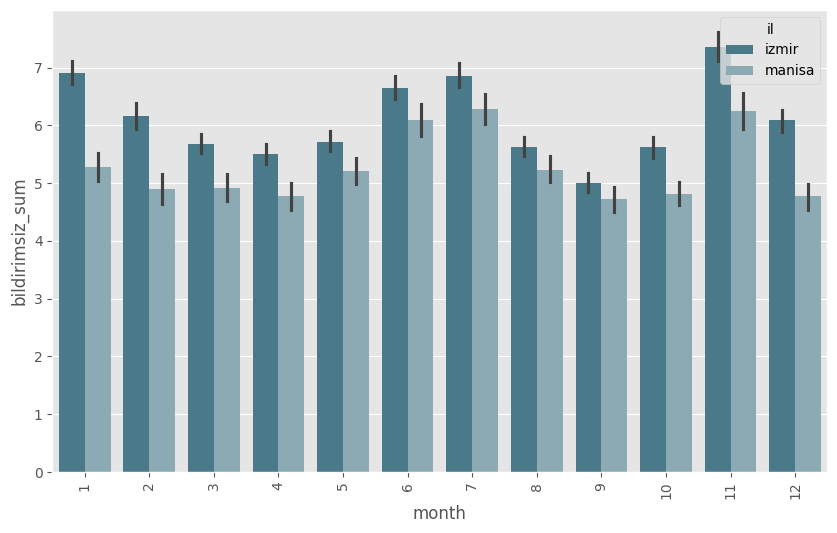

In [1779]:
plt.figure(figsize=(10, 6))
sns.barplot(x="month", y="bildirimsiz_sum",data=train_test_concat,hue="il")
plt.xticks(rotation=90)
plt.show()

In [1780]:
add_ratio_by_category(train_test_concat, "month", "bildirimsiz_sum")

New month_bildirimsiz_sum_ratio has been added to dataframe.
-------------------------------------------------
   month  month_bildirimsiz_sum_ratio
0      1                     0.120049
1      2                     0.071914
2      3                     0.076820
3      4                     0.071030
4      5                     0.077777


**Bildirimli**

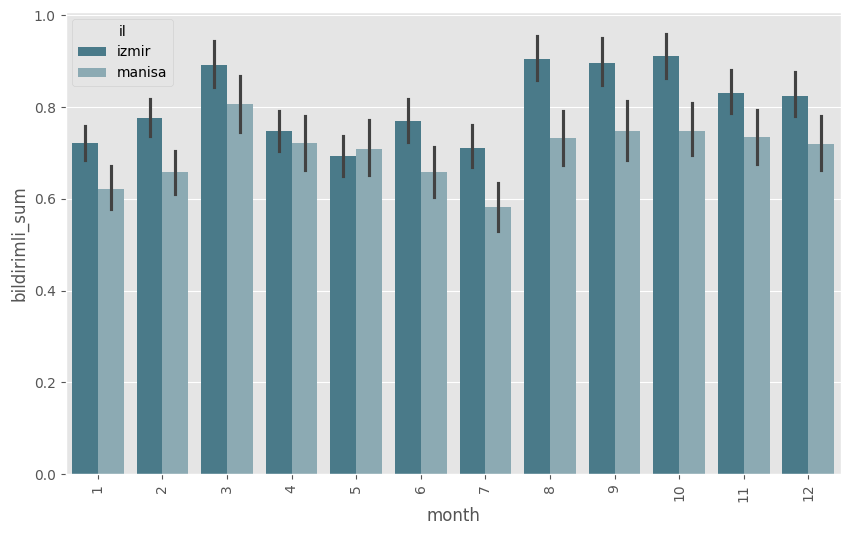

In [1781]:
plt.figure(figsize=(10, 6))
sns.barplot(x="month", y="bildirimli_sum",data=train_test_concat,hue="il")
plt.xticks(rotation=90)
plt.show()

In [1782]:
add_ratio_by_category(train_test_concat, "month", "bildirimli_sum")

New month_bildirimli_sum_ratio has been added to dataframe.
-------------------------------------------------
   month  month_bildirimli_sum_ratio
0      1                    0.095936
1      2                    0.094489
2      3                    0.090330
3      4                    0.073827
4      5                    0.072459


**Gün Değişkeni**

**Bildirimsiz**

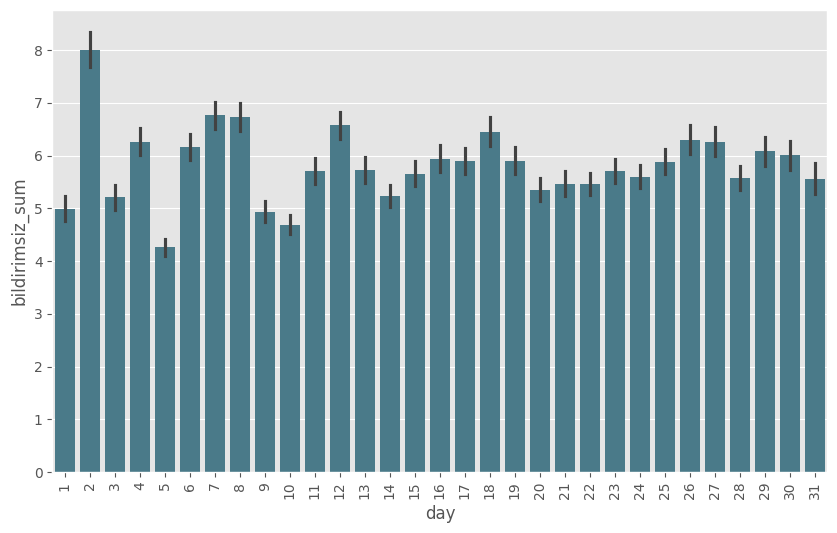

In [1783]:
plt.figure(figsize=(10, 6))
sns.barplot(x="day", y="bildirimsiz_sum",data=train_test_concat)
plt.xticks(rotation=90)
plt.show()

In [1784]:
add_ratio_by_category(train_test_concat, "day", "bildirimsiz_sum")

New day_bildirimsiz_sum_ratio has been added to dataframe.
-------------------------------------------------
   day  day_bildirimsiz_sum_ratio
0    1                   0.027443
1    2                   0.045909
2    3                   0.028616
3    4                   0.036236
4    5                   0.023282


**Bildirimli**

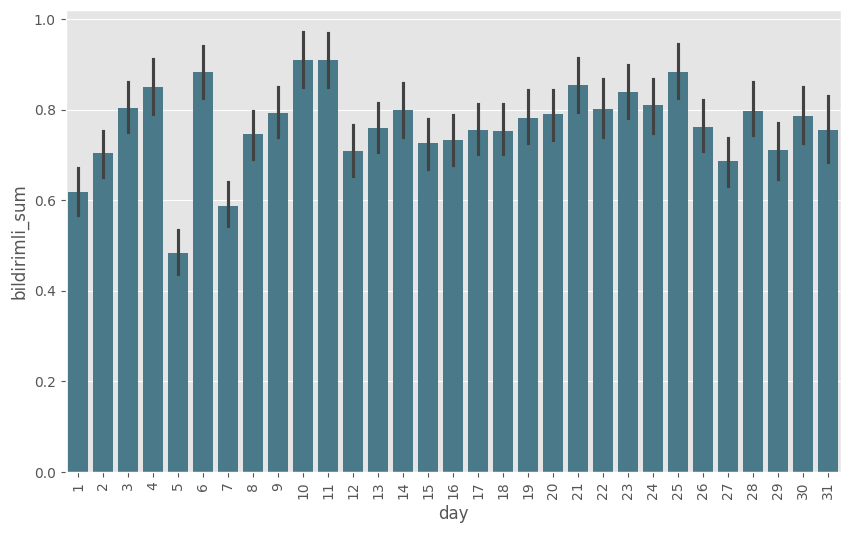

In [1785]:
plt.figure(figsize=(10, 6))
sns.barplot(x="day", y="bildirimli_sum",data=train_test_concat)
plt.xticks(rotation=90)
plt.show()

In [1786]:
add_ratio_by_category(train_test_concat, "day", "bildirimli_sum")

New day_bildirimli_sum_ratio has been added to dataframe.
-------------------------------------------------
   day  day_bildirimli_sum_ratio
0    1                  0.025873
1    2                  0.030689
2    3                  0.033584
3    4                  0.037348
4    5                  0.020056


**Diğer weekday(haftanın hangi günü) ve dayofyear(yılın kaçıncı günü) değişkenlerinin eklenmesi**

In [1787]:
train_test_concat["tarih"] = pd.to_datetime(train_test_concat["tarih"])
train_test_concat["weekday"] = train_test_concat["tarih"].dt.weekday
train_test_concat["dayofyear"] = train_test_concat["tarih"].dt.dayofyear
train_test_concat["tarih"] = train_test_concat["tarih"].dt.strftime("%Y-%m-%d") 


**Weekday bildirimsiz**

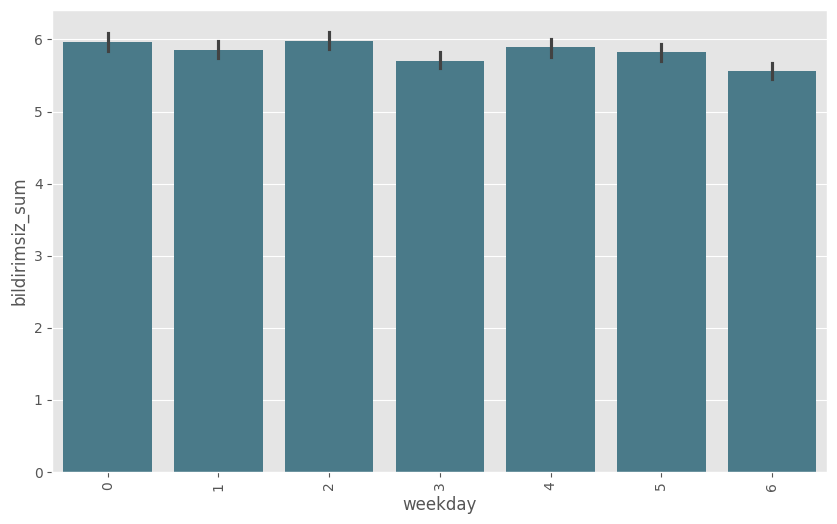

In [1788]:
plt.figure(figsize=(10, 6))
sns.barplot(x="weekday", y="bildirimsiz_sum",data=train_test_concat)
plt.xticks(rotation=90)
plt.show()

In [1789]:
add_ratio_by_category(train_test_concat, "weekday", "bildirimsiz_sum")

New weekday_bildirimsiz_sum_ratio has been added to dataframe.
-------------------------------------------------
   weekday  weekday_bildirimsiz_sum_ratio
0        0                       0.146972
1        1                       0.144904
2        2                       0.147667
3        3                       0.140103
4        4                       0.144248


**Weekday bildirimli**

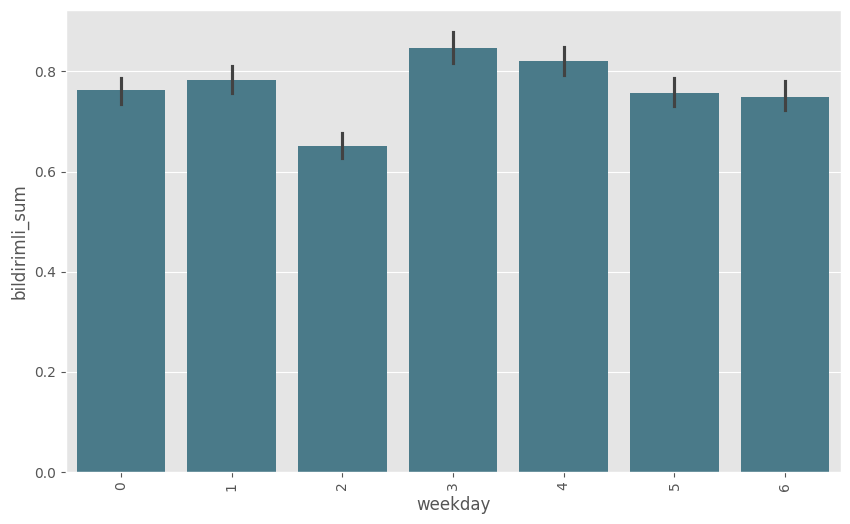

In [1790]:
plt.figure(figsize=(10, 6))
sns.barplot(x="weekday", y="bildirimli_sum",data=train_test_concat)
plt.xticks(rotation=90)
plt.show()

In [1791]:
add_ratio_by_category(train_test_concat, "weekday", "bildirimli_sum")

New weekday_bildirimli_sum_ratio has been added to dataframe.
-------------------------------------------------
   weekday  weekday_bildirimli_sum_ratio
0        0                      0.142549
1        1                      0.147050
2        2                      0.121914
3        3                      0.158762
4        4                      0.152445


**Day of year bildirimsiz**

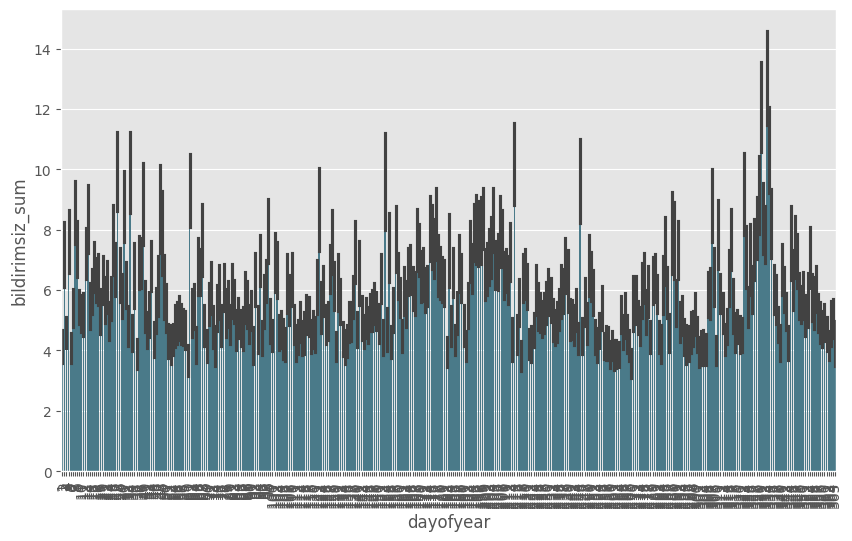

In [1792]:
plt.figure(figsize=(10, 6))
sns.barplot(x="dayofyear", y="bildirimsiz_sum",data=train_test_concat)
plt.xticks(rotation=90)
plt.show()

In [1793]:
add_ratio_by_category(train_test_concat, "dayofyear", "bildirimsiz_sum")

New dayofyear_bildirimsiz_sum_ratio has been added to dataframe.
-------------------------------------------------
   dayofyear  dayofyear_bildirimsiz_sum_ratio
0          1                         0.002253
1          2                         0.004389
2          3                         0.002616
3          4                         0.004851
4          5                         0.002367


**Day of year bildirimli**

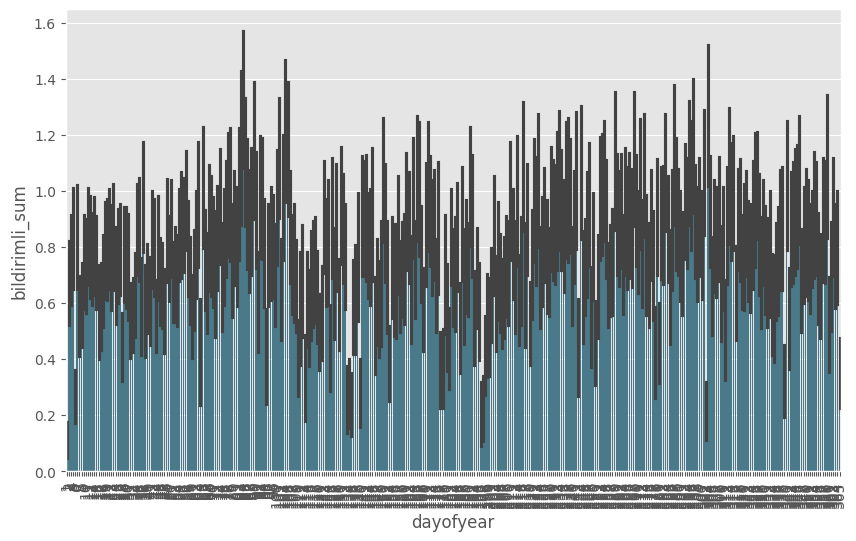

In [1794]:
plt.figure(figsize=(10, 6))
sns.barplot(x="dayofyear", y="bildirimli_sum",data=train_test_concat)
plt.xticks(rotation=90)
plt.show()

In [1795]:
add_ratio_by_category(train_test_concat, "dayofyear", "bildirimli_sum")

New dayofyear_bildirimli_sum_ratio has been added to dataframe.
-------------------------------------------------
   dayofyear  dayofyear_bildirimli_sum_ratio
0          1                        0.000421
1          2                        0.003053
2          3                        0.003185
3          4                        0.003922
4          5                        0.001105


**Kategorik Değişken Oluşturulması**

**Yıllık kesinti toplamları**

**Yıllık toplam kesinti sayıları değerlendirilerek performansı yıllık bazda azalan yani iyileşen ilçelere 1 kötüleşen ilçelere 0 verilmiştir**

In [1796]:
performansi_iyilesen_ilceler = ["izmir-cesme",
                                "izmir-odemis",
                                "manisa-yunusemre",
                                "izmir-urla",
                                "izmir-menderes",
                                "manisa-akhisar",
                                "izmir-buca",
                                "izmir-kiraz",
                                "izmir-seferihisar",
                                "izmir-karaburun",
                                "izmir-bayindir",
                                "manisa-saruhanli",
                                "izmir-bayrakli",
                                "manisa-soma",
                                "izmir-cigli",
                                "izmir-gaziemir",
                                "izmir-beydag"]
train_test_concat["il_ilce_performans"] = np.where(train_test_concat["il_ilce"].isin(performansi_iyilesen_ilceler),1,0).astype(int)

In [1797]:
pivot_table = train_test_concat.pivot_table(index="il_ilce",columns="year",values="bildirimsiz_sum",aggfunc="sum")
pivot_table.sort_values(2021,ascending=False,inplace=True)


In [1798]:
# plt.figure(figsize=(6,16))
# cmap = sns.diverging_palette(220, 20, as_cmap=True)
# sns.heatmap(pivot_table,annot=True,fmt=".2f",cmap = cmap)
# plt.title("İzmir ve Manisa İlçelerinin Yıllık Toplam Kesinti Grafiği")
# plt.show()

**2021, 2022 ve 2023 yıllarında meydana gelen toplam kesinti sayıları belirli aralıklara göre gruplandırılmış önem düzeyleri belirlenmiştir.**

In [1799]:
def create_yearly_cat_feature_with_bins(df:pd.DataFrame, year:int, group_category:str, target:str, bins:list, labels:list ):
    new_category_name=f"{target}_category_{year}"
    year_df= df[df["year"]==year].groupby(group_category)[target].sum().reset_index()
    year_df[new_category_name] = pd.cut(year_df[target],bins=bins, labels=labels, ordered=True)
    year_df.drop(target,axis=1, inplace=True)
    df = df.merge(year_df, on=group_category, how="left")
    print(f"{new_category_name} feature has been added to main dataframe")
    print("--------------------------------------")
    print(df[new_category_name].value_counts())
    return df

In [1800]:
bins=[-np.inf, 1000, 2000, 3000, 4000, np.inf]
labels = ["level_1","level_2","level_3","level_4","level_5"]
years = [2021, 2022, 2023]

for year in years:
    train_test_concat=create_yearly_cat_feature_with_bins(train_test_concat,year, "il_ilce", "bildirimsiz_sum", bins, labels)

bildirimsiz_sum_category_2021 feature has been added to main dataframe
--------------------------------------
bildirimsiz_sum_category_2021
level_3    13656
level_2    10928
level_4    10370
level_1     9945
level_5     4612
Name: count, dtype: int64
bildirimsiz_sum_category_2022 feature has been added to main dataframe
--------------------------------------
bildirimsiz_sum_category_2022
level_2    16775
level_3    14946
level_1    12023
level_4     4613
level_5     1154
Name: count, dtype: int64
bildirimsiz_sum_category_2023 feature has been added to main dataframe
--------------------------------------
bildirimsiz_sum_category_2023
level_2    16574
level_3    13769
level_1     9945
level_4     9223
level_5        0
Name: count, dtype: int64


In [1801]:
# train_test_concat[train_test_concat["year"]==2021].groupby("il_ilce")["bildirimli_sum"].sum().reset_index().sort_values("bildirimli_sum",ascending=False)

**Hava durumu kategorik değişkenlerinin oluşturulması**
- Kesintiye en çok etki eden temp, wind_speed, precip(1 saat içinde yağmur yağma olasılığı) değişkenleri seçilmiştir.

In [1802]:
temp_train = train_test_concat[train_test_concat["unique_id"].isin(train["unique_id"])]
temp_test = train_test_concat[train_test_concat["unique_id"].isin(test["unique_id"])]
temp_train[["temp","wind_speed","precip"]].describe().T

count       mean        std  min   25%   50%   75%   max
temp        48148.0  22.850380   8.925280 -2.7  15.9  22.3  30.3  44.8
wind_speed  48148.0   4.513714   2.001840  0.7   3.1   4.3   5.6  18.4
precip      48148.0  13.589458  27.171025  1.0   1.0   1.0   5.2  95.0

In [1803]:
temp_test[["temp","wind_speed","precip"]].describe().T

count       mean        std  min   25%   50%   75%   max
temp        1363.0  15.794057   3.221163  5.8  13.3  15.9  18.3  23.6
wind_speed  1363.0   3.884153   2.062040  0.9   2.3   3.3   4.9  15.9
precip      1363.0  17.619516  29.193861  1.0   1.0   1.0  19.5  95.0

In [1804]:
def create_categorical(whole_df:pd.DataFrame, train_df:pd.DataFrame, test_df:pd.DataFrame,unique_id:str, num_var_name:str, bins:list, labels:list, ordered:bool=True ):
        
    temp_train_df = whole_df[whole_df[unique_id].isin(train_df[unique_id])]
    temp_test_df = train_test_concat[train_test_concat[unique_id].isin(test_df[unique_id])]

    temp_train_df[f"{num_var_name}_category"] = pd.cut(temp_train_df[num_var_name],bins=bins,labels=labels,ordered=ordered)
    temp_test_df[f"{num_var_name}_category"] = pd.cut(temp_test_df[num_var_name],bins=bins,labels=labels,ordered=ordered)

    whole_df = pd.concat([temp_train_df,temp_test_df],axis=0)
    print("Feature created.")
    print("***************")
    print("Whole df value counts:")
    print(whole_df[[f"{num_var_name}_category"]].value_counts())
    print("***************")
    print("Train df value counts:")
    print(temp_train_df[[f"{num_var_name}_category"]].value_counts())
    print("***************")
    print("Test df value counts:")
    print(temp_test_df[[f"{num_var_name}_category"]].value_counts())
    print("***************")
    return whole_df

**Sıcaklık kategorik değişkeninin eklenmesi**
- Aralıklar literatür araştırması ile belirlenmiştir.

In [1805]:
bins_temp =[-np.inf, 5, 10, 15, 25, np.inf]
labels_temp = ["cold","cool", "mild", "warm", "high"]
train_test_concat = create_categorical(train_test_concat,train, test, "unique_id", "temp", bins_temp, labels_temp )

Feature created.
***************
Whole df value counts:
temp_category
high             19937
warm             18653
mild              7491
cool              2871
cold               559
Name: count, dtype: int64
***************
Train df value counts:
temp_category
high             19937
warm             17858
mild              6967
cool              2827
cold               559
Name: count, dtype: int64
***************
Test df value counts:
temp_category
warm             795
mild             524
cool              44
cold               0
high               0
Name: count, dtype: int64
***************


**Rüzgar hızı kategorisinin eklenmesi**
- Aralıklar beaufort rüzgar skalasına göre belirlenmiştir.(m/sn)

In [1806]:
bins_wind_speed =[-np.inf, 0.2, 1.5, 3.3, 5.4, 7.9, 10.7, 13.8, 17.1, np.inf]
labels_wind = ["sakin","esinti", "hafif_rizgar", "tatli_ruzgar", "orta_ruzgar","sert_ruzgar", "kuvvetli_ruzgar", "firtinamsi_ruzgar","firtina"  ]
train_test_concat = create_categorical(train_test_concat,train, test, "unique_id", "wind_speed", bins_wind_speed, labels_wind )

Feature created.
***************
Whole df value counts:
wind_speed_category
tatli_ruzgar           20649
hafif_rizgar           14324
orta_ruzgar            10479
sert_ruzgar             2438
esinti                  1152
kuvvetli_ruzgar          412
firtinamsi_ruzgar         55
firtina                    2
sakin                      0
Name: count, dtype: int64
***************
Train df value counts:
wind_speed_category
tatli_ruzgar           20254
hafif_rizgar           13681
orta_ruzgar            10277
sert_ruzgar             2375
esinti                  1100
kuvvetli_ruzgar          406
firtinamsi_ruzgar         53
firtina                    2
sakin                      0
Name: count, dtype: int64
***************
Test df value counts:
wind_speed_category
hafif_rizgar           643
tatli_ruzgar           395
orta_ruzgar            202
sert_ruzgar             63
esinti                  52
kuvvetli_ruzgar          6
firtinamsi_ruzgar        2
sakin                    0
firtina          

**1 saat içinde yağmur yağma olasılığı kategorisinin eklenmesi**

In [1807]:
bins_precip =[-np.inf, 2, 5, 10, 20, np.inf]
labels_precip = ["very_low","low", "medium", "high", "very_high"]
train_test_concat = create_categorical(train_test_concat,train, test, "unique_id", "precip", bins_precip, labels_precip )

Feature created.
***************
Whole df value counts:
precip_category
very_low           35681
very_high           9090
high                1926
medium              1591
low                 1223
Name: count, dtype: int64
***************
Train df value counts:
precip_category
very_low           34875
very_high           8755
high                1830
medium              1498
low                 1190
Name: count, dtype: int64
***************
Test df value counts:
precip_category
very_low           806
very_high          335
high                96
medium              93
low                 33
Name: count, dtype: int64
***************


**KMeans ile ilçelerin havadurumu segmentlerinin çıkarılması**

In [1808]:
temp_train = train_test_concat[train_test_concat["unique_id"].isin(train["unique_id"])]
temp_test = train_test_concat[train_test_concat["unique_id"].isin(test["unique_id"])]

In [1809]:
weather_features_df = temp_train.groupby("il_ilce")[["temp","cloud_cover","global_rad","relative_humidity","wind_dir","wind_speed","precip","cloud_cover_min","relative_humidity_min","wind_speed_min","precip_min","temp_min"]].mean().reset_index()
weather_features_df.head()

il_ilce       temp  cloud_cover  global_rad  relative_humidity  \
0    izmir-aliaga  22.200090    57.369078  672.771067          83.316908   
1   izmir-balcova  21.688825    58.494556  661.738252          82.843123   
2  izmir-bayindir  24.329050    58.990860  677.091403          80.683348   
3  izmir-bayrakli  23.963168    57.425046  671.323481          82.844383   
4   izmir-bergama  22.755179    63.777232  655.931161          84.056518   

     wind_dir  wind_speed     precip  cloud_cover_min  relative_humidity_min  \
0  121.555515    6.225588  13.535714         6.592134              48.385714   
1  202.944269    5.074928  14.715330         6.940401              50.492980   
2  110.109412    4.358009  13.459548         7.567421              38.918733   
3  129.462615    4.504236  13.323481         6.933057              40.984991   
4  107.660893    4.788393  13.354286         9.001429              42.958661   

   wind_speed_min  precip_min   temp_min  
0        2.398282    1.001899  14.131736  
1        1.418481    1.000000  14.839255  
2        1.250226    1.000000  13.476561  
3        1.465285    1.010037  14.225967  
4        1.544464    1.000000  12.095893

**Elbow**

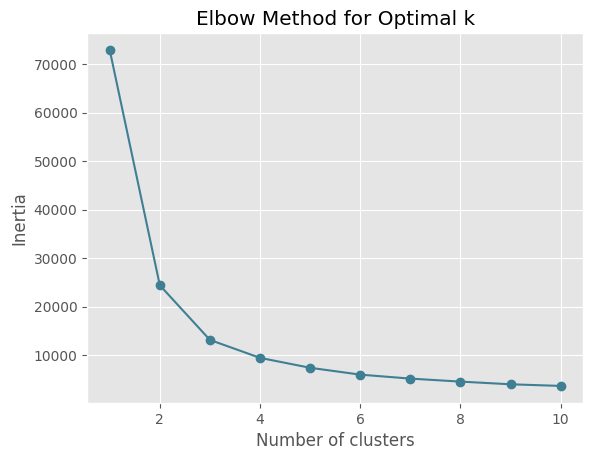

In [1810]:
inertia = []
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, random_state=42,n_init=100)
    kmeans.fit(weather_features_df.select_dtypes(exclude="object"))
    inertia.append(kmeans.inertia_)

# Elbow yöntemi ile belirlenen küme sayısını görselleştirin
plt.plot(range(1, 11), inertia, marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')
plt.title('Elbow Method for Optimal k')
plt.show()

In [1811]:
pipeline = Pipeline([("scaler",StandardScaler()),
                    ("kmeans",KMeans(n_clusters=3,random_state=42,n_init=100))])
pipeline.fit(weather_features_df.select_dtypes(exclude="object"))
weather_features_df["weather_profile_of_county"] = pipeline.predict(weather_features_df.select_dtypes(exclude="object"))
weather_features_df.head()

il_ilce       temp  cloud_cover  global_rad  relative_humidity  \
0    izmir-aliaga  22.200090    57.369078  672.771067          83.316908   
1   izmir-balcova  21.688825    58.494556  661.738252          82.843123   
2  izmir-bayindir  24.329050    58.990860  677.091403          80.683348   
3  izmir-bayrakli  23.963168    57.425046  671.323481          82.844383   
4   izmir-bergama  22.755179    63.777232  655.931161          84.056518   

     wind_dir  wind_speed     precip  cloud_cover_min  relative_humidity_min  \
0  121.555515    6.225588  13.535714         6.592134              48.385714   
1  202.944269    5.074928  14.715330         6.940401              50.492980   
2  110.109412    4.358009  13.459548         7.567421              38.918733   
3  129.462615    4.504236  13.323481         6.933057              40.984991   
4  107.660893    4.788393  13.354286         9.001429              42.958661   

   wind_speed_min  precip_min   temp_min  weather_profile_of_county  
0        2.398282    1.001899  14.131736                          1  
1        1.418481    1.000000  14.839255                          1  
2        1.250226    1.000000  13.476561                          0  
3        1.465285    1.010037  14.225967                          0  
4        1.544464    1.000000  12.095893                          2

In [1812]:
weather_series = weather_features_df[["il_ilce","weather_profile_of_county"]].set_index("il_ilce")["weather_profile_of_county"]
train_test_concat["weather_profile_of_county"] = train_test_concat["il_ilce"].map(weather_series)
train_test_concat.groupby(["il_ilce","weather_profile_of_county"])["bildirimsiz_sum"].sum().reset_index().head()

il_ilce  weather_profile_of_county  bildirimsiz_sum
0    izmir-aliaga                          1           6107.5
1   izmir-balcova                          1           1210.0
2  izmir-bayindir                          0           5663.5
3  izmir-bayrakli                          0           4830.0
4   izmir-bergama                          2           7826.5

In [1813]:
weather_kmeans_df = train_test_concat.groupby(["il", "ilce","weather_profile_of_county"])["bildirimsiz_sum"].sum().reset_index().sort_values(by=["il", "bildirimsiz_sum"], ascending=[True, False])
weather_kmeans_df["il_ilce"] = weather_kmeans_df["il"] + "-" + weather_kmeans_df["ilce"]
weather_kmeans_df = weather_kmeans_df.drop(columns=["il", "ilce"])
weather_kmeans_df = weather_kmeans_df[["il_ilce", "bildirimsiz_sum","weather_profile_of_county"]].reset_index(drop=True)

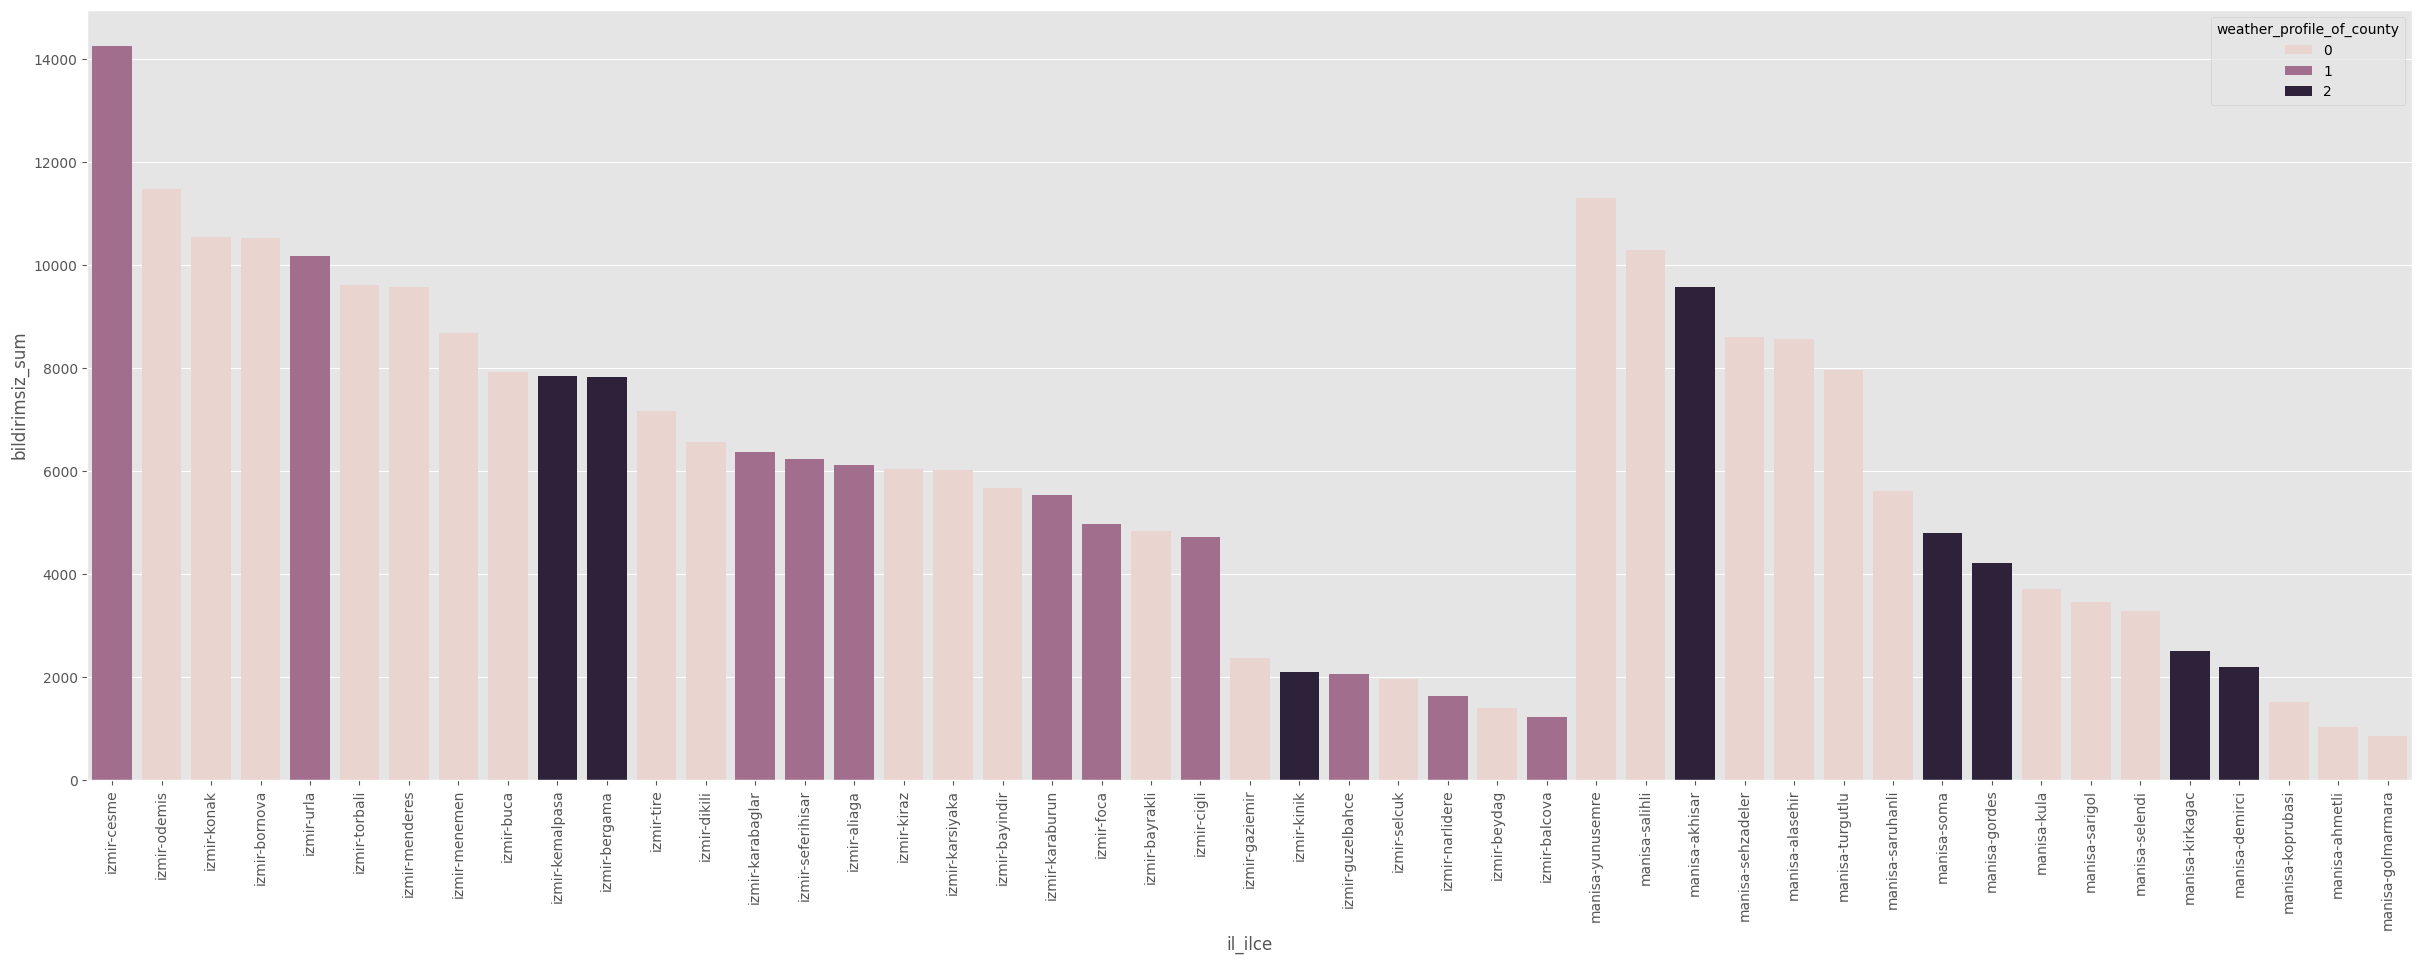

In [1814]:
plt.figure(figsize=(30,10))
sns.barplot(x="il_ilce",y="bildirimsiz_sum",data=weather_kmeans_df,hue="weather_profile_of_county")
plt.xticks(rotation=90)
plt.show()

In [1815]:
train_test_concat.groupby("weather_profile_of_county")["bildirimsiz_sum"].sum().reset_index()

weather_profile_of_county  bildirimsiz_sum
0                          0         176361.0
1                          1          63205.5
2                          2          40998.0

**Koordinat Özellikleri**
* Konum kümesi

In [1816]:
coord_features_df = train_test_concat.groupby("il_ilce")[["lat","long"]].mean().reset_index()
coord_features_df.head()

il_ilce      lat     long
0    izmir-aliaga  38.7996  26.9707
1   izmir-balcova  38.3891  27.0500
2  izmir-bayindir  38.2178  27.6478
3  izmir-bayrakli  38.4612  27.1881
4   izmir-bergama  39.1214  27.1799

In [1817]:
# inertia_coords = []
# for k in range(1, 11):
#     kmeans_coord = KMeans(n_clusters=k, random_state=42,n_init=100)
#     kmeans_coord.fit(coord_features_df[["lat","long"]])
#     inertia_coords.append(kmeans_coord.inertia_)

# # Elbow yöntemi ile belirlenen küme sayısını görselleştirin
# plt.plot(range(1, 11), inertia_coords, marker='o')
# plt.xlabel('Number of clusters')
# plt.ylabel('Inertia')
# plt.title('Elbow Method for Optimal k')
# plt.show()

In [1818]:
pipeline_coord = Pipeline([("scaler",StandardScaler()),
                    ("kmeans",KMeans(n_clusters=3,random_state=42,n_init=100))])
pipeline_coord.fit(coord_features_df.select_dtypes(exclude="object"))
coord_features_df["coords_clusters"] = pipeline_coord.predict(coord_features_df.select_dtypes(exclude="object"))
coord_features_df.head()

il_ilce      lat     long  coords_clusters
0    izmir-aliaga  38.7996  26.9707                2
1   izmir-balcova  38.3891  27.0500                0
2  izmir-bayindir  38.2178  27.6478                0
3  izmir-bayrakli  38.4612  27.1881                0
4   izmir-bergama  39.1214  27.1799                2

In [1819]:
coord_series = coord_features_df[["il_ilce","coords_clusters"]].set_index("il_ilce")["coords_clusters"]
train_test_concat["coords_clusters"] = train_test_concat["il_ilce"].map(coord_series)
train_test_concat.groupby(["il_ilce","coords_clusters"])["bildirimsiz_sum"].sum().reset_index().head()

il_ilce  coords_clusters  bildirimsiz_sum
0    izmir-aliaga                2           6107.5
1   izmir-balcova                0           1210.0
2  izmir-bayindir                0           5663.5
3  izmir-bayrakli                0           4830.0
4   izmir-bergama                2           7826.5

In [1820]:
coord_kmeans_df = train_test_concat.groupby(["il", "ilce","coords_clusters"])["bildirimsiz_sum"].sum().reset_index().sort_values(by=["il", "bildirimsiz_sum"], ascending=[True, False])
coord_kmeans_df["il_ilce"] = coord_kmeans_df["il"] + "-" + coord_kmeans_df["ilce"]
coord_kmeans_df = coord_kmeans_df.drop(columns=["il", "ilce"])
coord_kmeans_df = coord_kmeans_df[["il_ilce", "bildirimsiz_sum","coords_clusters"]].reset_index(drop=True)
coord_kmeans_df.head()

il_ilce  bildirimsiz_sum  coords_clusters
0    izmir-cesme          14242.0                0
1   izmir-odemis          11465.0                1
2    izmir-konak          10537.5                0
3  izmir-bornova          10511.5                0
4     izmir-urla          10162.0                0

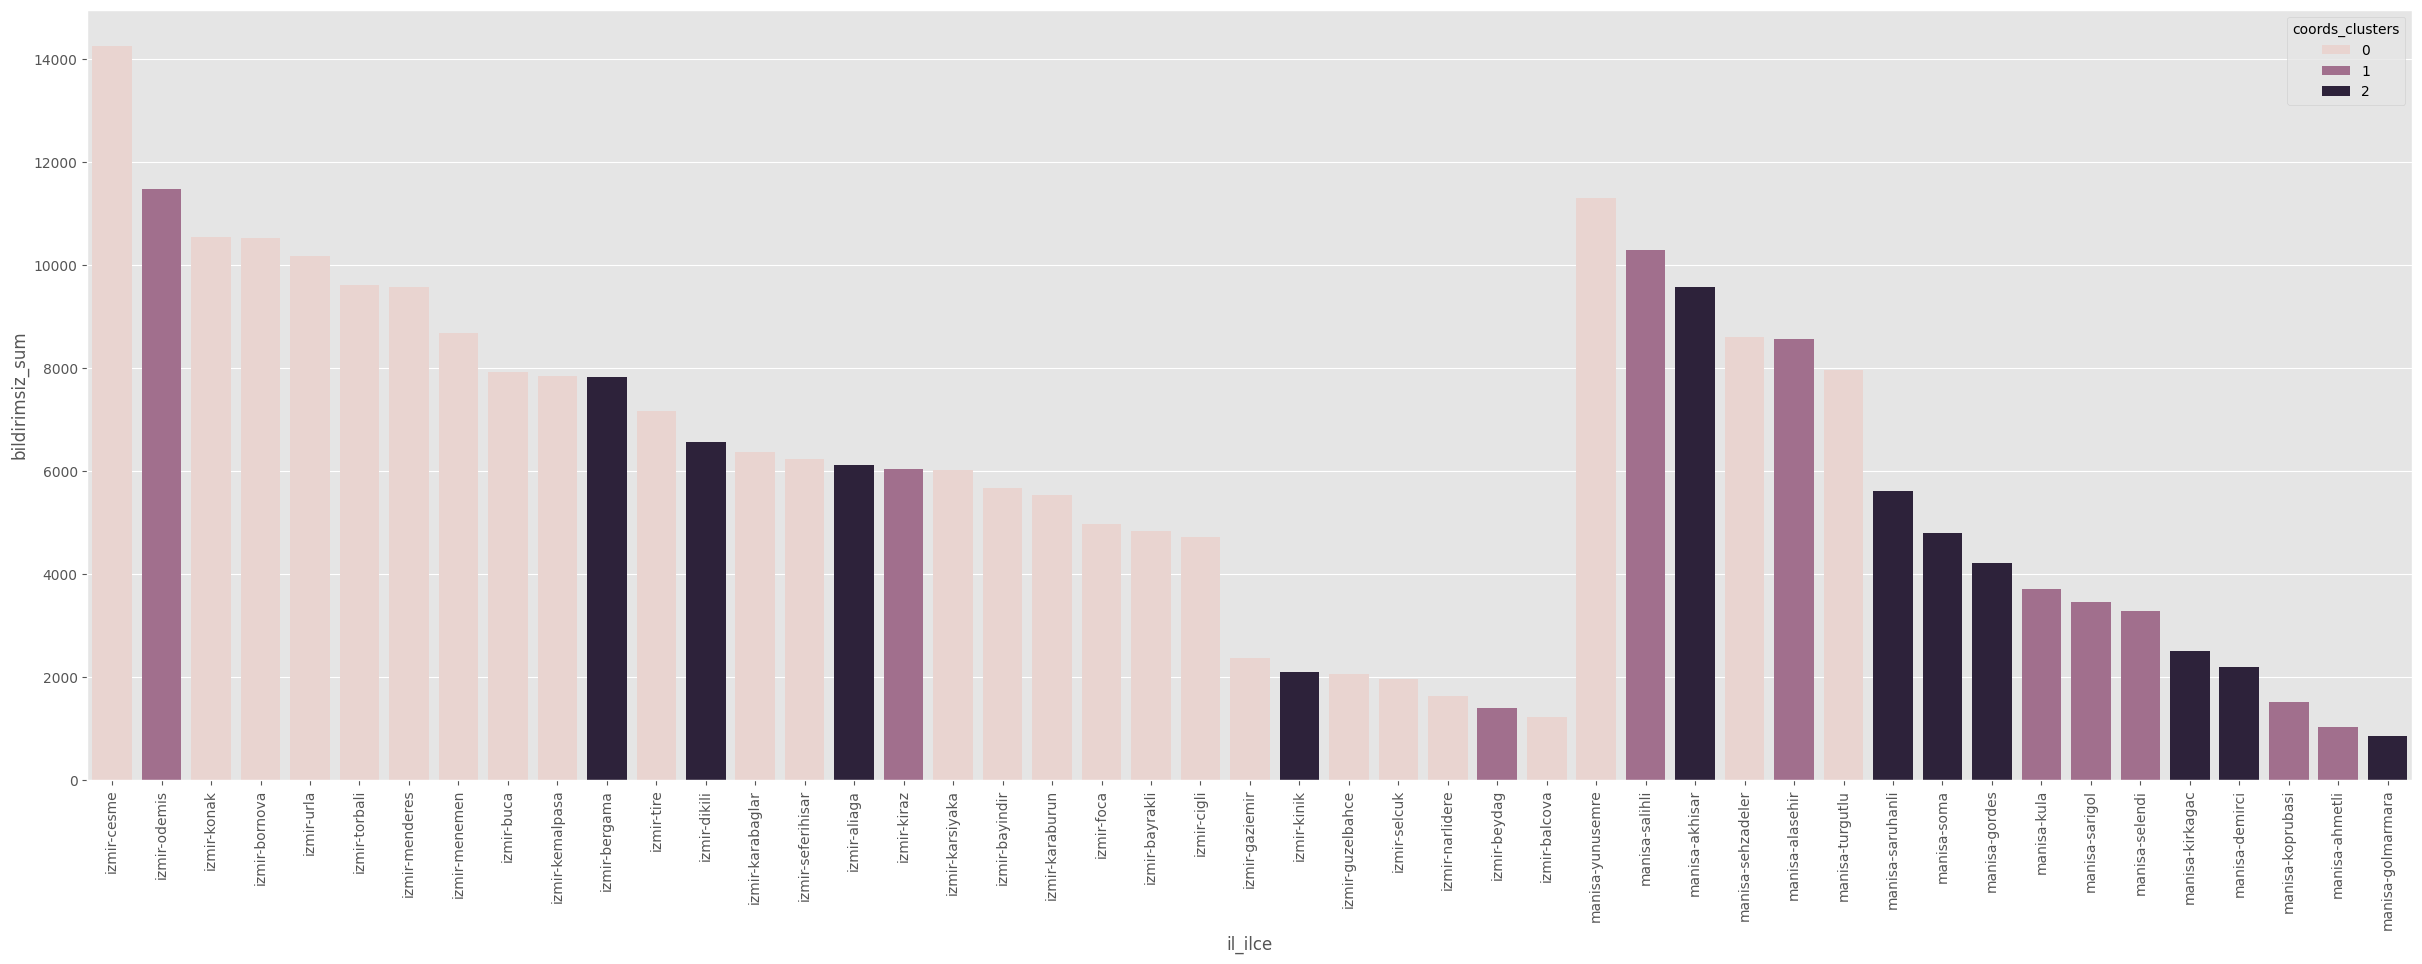

In [1821]:
plt.figure(figsize=(30,10))
sns.barplot(x="il_ilce",y="bildirimsiz_sum",data=coord_kmeans_df,hue="coords_clusters")
plt.xticks(rotation=90)
plt.show()

**Time series özellikleri**

In [1822]:
temp_train = train_test_concat[train_test_concat["unique_id"].isin(train["unique_id"])]
temp_test = train_test_concat[train_test_concat["unique_id"].isin(test["unique_id"])]

time_series_train_group = temp_train.groupby("tarih")[["bildirimsiz_sum","bildirimli_sum"]].sum().reset_index()
time_series_train_group["tarih"] = pd.to_datetime(time_series_train_group["tarih"])
time_series_train_group.head()

tarih  bildirimsiz_sum  bildirimli_sum
0 2021-01-01            220.0               4
1 2021-01-02            631.5              31
2 2021-01-03            212.0              44
3 2021-01-04            236.0              25
4 2021-01-05            190.0               4

In [1823]:
time_series_train_group["bildirimsiz_rolling_1_year"] = time_series_train_group["bildirimsiz_sum"].rolling(window=365).mean()
time_series_train_group["bildirimsiz_pct_change_1_year"] = time_series_train_group["bildirimsiz_sum"].pct_change(periods=365)
time_series_train_group["bildirimsiz_diff_1_year"] = time_series_train_group["bildirimsiz_sum"].diff(periods=365)
seasonal_decomposed = seasonal_decompose(time_series_train_group["bildirimsiz_sum"], period=365)
time_series_train_group["bildirimsiz_seasonal_1_year"] = seasonal_decomposed.seasonal


time_series_train_group["bildirimli_rolling_1_year"] = time_series_train_group["bildirimli_sum"].rolling(window=365).mean()
time_series_train_group["bildirimli_diff_1_year"] = time_series_train_group["bildirimli_sum"].diff(periods=365)
seasonal_decomposed = seasonal_decompose(time_series_train_group["bildirimli_sum"], period=365)
time_series_train_group["bildirimli_seasonal_1_year"] = seasonal_decomposed.seasonal


time_series_train_group.bfill(inplace=True)
time_series_train_group.ffill(inplace=True)
time_series_train_group.drop(["bildirimsiz_sum","bildirimli_sum"],inplace=True,axis=1)
time_series_train_group.head()

tarih  bildirimsiz_rolling_1_year  bildirimsiz_pct_change_1_year  \
0 2021-01-01                  283.917808                      -0.127273   
1 2021-01-02                  283.917808                      -0.127273   
2 2021-01-03                  283.917808                      -0.127273   
3 2021-01-04                  283.917808                      -0.127273   
4 2021-01-05                  283.917808                      -0.127273   

   bildirimsiz_diff_1_year  bildirimsiz_seasonal_1_year  \
0                    -28.0                   -82.201439   
1                    -28.0                   -27.102809   
2                    -28.0                   -67.456918   
3                    -28.0                   228.156781   
4                    -28.0                   -78.387055   

   bildirimli_rolling_1_year  bildirimli_diff_1_year  \
0                   26.59726                    -2.0   
1                   26.59726                    -2.0   
2                   26.59726                    -2.0   
3                   26.59726                    -2.0   
4                   26.59726                    -2.0   

   bildirimli_seasonal_1_year  
0                  -27.422881  
1                   -9.422881  
2                   -4.444799  
3                   19.030544  
4                  -27.995484

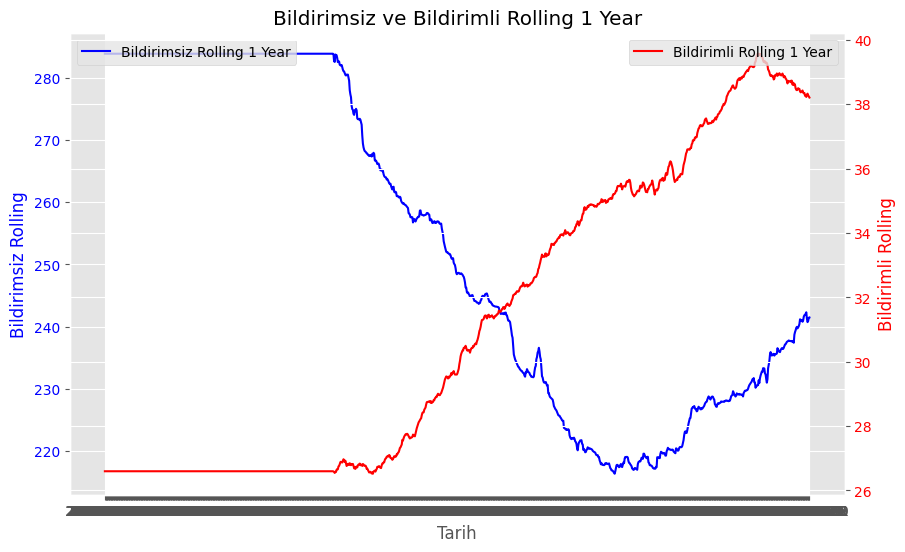

In [1879]:
fig, ax1 = plt.subplots(figsize=(10, 6))

ax1.plot(time_series_train_group["tarih"], time_series_train_group["bildirimsiz_rolling_1_year"], label="Bildirimsiz Rolling 1 Year", color="blue")
ax1.set_xlabel("Tarih")
ax1.set_ylabel("Bildirimsiz Rolling", color="blue")
ax1.tick_params(axis='y', labelcolor="blue")
ax1.legend(loc="upper left")

ax2 = ax1.twinx()
ax2.plot(time_series_train_group["tarih"], time_series_train_group["bildirimli_rolling_1_year"], label="Bildirimli Rolling 1 Year", color="red")
ax2.set_ylabel("Bildirimli Rolling", color="red")
ax2.tick_params(axis='y', labelcolor="red")
ax2.legend(loc="upper right")

plt.title("Bildirimsiz ve Bildirimli Rolling 1 Year")

plt.show()

**Test grup oluşturulması ve tahminlerin test setine eklenmesi**

In [1825]:
train_feature_list=time_series_train_group.loc[:,time_series_train_group.columns.str.contains("bildirimsiz|bildirimli")].columns.to_list()
train_feature_list

['bildirimsiz_rolling_1_year',
 'bildirimsiz_pct_change_1_year',
 'bildirimsiz_diff_1_year',
 'bildirimsiz_seasonal_1_year',
 'bildirimli_rolling_1_year',
 'bildirimli_diff_1_year',
 'bildirimli_seasonal_1_year']

In [1826]:
time_series_test_group = temp_test.groupby("tarih")[["bildirimsiz_sum","bildirimli_sum"]].sum().reset_index()
for feature in train_feature_list:
    time_series_test_group[feature] = np.nan
time_series_test_group["tarih"] = pd.to_datetime(time_series_test_group["tarih"])
time_series_test_group.drop(["bildirimsiz_sum","bildirimli_sum"],inplace=True,axis=1)
time_series_test_group.head()

tarih  bildirimsiz_rolling_1_year  bildirimsiz_pct_change_1_year  \
0 2024-02-01                         NaN                            NaN   
1 2024-02-02                         NaN                            NaN   
2 2024-02-03                         NaN                            NaN   
3 2024-02-04                         NaN                            NaN   
4 2024-02-05                         NaN                            NaN   

   bildirimsiz_diff_1_year  bildirimsiz_seasonal_1_year  \
0                      NaN                          NaN   
1                      NaN                          NaN   
2                      NaN                          NaN   
3                      NaN                          NaN   
4                      NaN                          NaN   

   bildirimli_rolling_1_year  bildirimli_diff_1_year  \
0                        NaN                     NaN   
1                        NaN                     NaN   
2                        NaN                     NaN   
3                        NaN                     NaN   
4                        NaN                     NaN   

   bildirimli_seasonal_1_year  
0                         NaN  
1                         NaN  
2                         NaN  
3                         NaN  
4                         NaN

In [1827]:
def predict_ts_features_and_write_to_test_df(test_df: pd.DataFrame, train_df: pd.DataFrame, feature_list: list, date_col_name: str):
    
    test_df_copy = test_df.copy()
    for feature in feature_list:
        df = train_df[[date_col_name, feature]].copy()
        df.rename(columns={date_col_name: "ds", feature: "y"}, inplace=True)
        model = Prophet(
            changepoint_prior_scale=0.01,   # Trendin esnekliği (artırabilirsiniz)
            seasonality_prior_scale=20.0,  # Mevsimsellik esnekliği
            holidays_prior_scale=10.0,     # Tatil etkilerinin esnekliği
            seasonality_mode='additive',   # Mevsimsellik modu
            n_changepoints=25,             # Trend değişim noktaları (artırabilirsiniz)
            yearly_seasonality=True,       # Yıllık mevsimsellik
        )
        model.fit(df)
        future = model.make_future_dataframe(periods=len(test_df))
        forecast = model.predict(future)
        #hareketli ortalamasını alarak pürüzsüzleştiriyoruz. Bu şekilde, ani düşüşlerin etkisini azaltıyoruz ve tahminlerimizin daha istikrarlı hale gelmesini sağlıyoruz.
        forecast['yhat'] = forecast['yhat'].rolling(window=1, min_periods=1).mean()
        test_df_copy.loc[:, feature] = forecast["yhat"].values[-len(test_df):]
    print("Features have been predicted and written to the test DataFrame!")
    print("---------------------")
    return test_df_copy

In [1828]:
time_series_test_group = predict_ts_features_and_write_to_test_df(time_series_test_group,time_series_train_group,train_feature_list, "tarih")
time_series_test_group.head()


11:13:23 - cmdstanpy - INFO - Chain [1] start processing


11:13:24 - cmdstanpy - INFO - Chain [1] done processing
11:13:24 - cmdstanpy - INFO - Chain [1] start processing
11:13:24 - cmdstanpy - INFO - Chain [1] done processing
11:13:24 - cmdstanpy - INFO - Chain [1] start processing
11:13:25 - cmdstanpy - INFO - Chain [1] done processing
11:13:25 - cmdstanpy - INFO - Chain [1] start processing
11:13:25 - cmdstanpy - INFO - Chain [1] done processing
11:13:25 - cmdstanpy - INFO - Chain [1] start processing
11:13:26 - cmdstanpy - INFO - Chain [1] done processing
11:13:26 - cmdstanpy - INFO - Chain [1] start processing
11:13:26 - cmdstanpy - INFO - Chain [1] done processing
11:13:27 - cmdstanpy - INFO - Chain [1] start processing
11:13:27 - cmdstanpy - INFO - Chain [1] done processing


Features have been predicted and written to the test DataFrame!
---------------------


tarih  bildirimsiz_rolling_1_year  bildirimsiz_pct_change_1_year  \
0 2024-02-01                  240.412373                       0.154397   
1 2024-02-02                  240.393732                       0.171194   
2 2024-02-03                  240.335111                       0.137927   
3 2024-02-04                  240.278699                       0.129313   
4 2024-02-05                  240.289669                       0.234711   

   bildirimsiz_diff_1_year  bildirimsiz_seasonal_1_year  \
0               -20.313488                     6.011349   
1               -14.835789                    -1.603683   
2               -27.440860                   -10.888732   
3               -26.638981                   -14.958246   
4                -2.400773                   -15.452427   

   bildirimli_rolling_1_year  bildirimli_diff_1_year  \
0                  38.279450               11.338538   
1                  38.266496                5.474532   
2                  38.249520                4.082188   
3                  38.238391                6.416556   
4                  38.226036                6.204806   

   bildirimli_seasonal_1_year  
0                   -1.255010  
1                   -2.027364  
2                   -1.242539  
3                   -1.682497  
4                   -1.638472

In [1829]:
def plot_all_feature_predictions(train_df:pd.DataFrame, test_df:pd.DataFrame, feature_list:list, date_col:str):
    for feature in feature_list:
        plt.figure(figsize=(10, 6))
        plt.plot(train_df[date_col], train_df[feature], label=feature)
        plt.plot(test_df[date_col], test_df[feature], label=feature)
        plt.title("Train ve Tahmin Edilen Değerlerin Grafiksel Karşılaştırması")
        plt.xlabel(date_col)
        plt.ylabel(feature)
        plt.legend()
        plt.grid(True)
        plt.show()

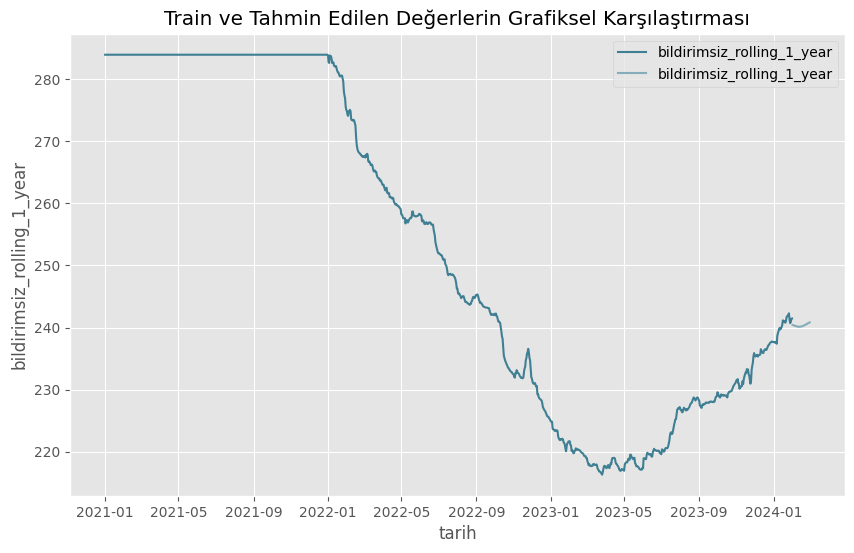

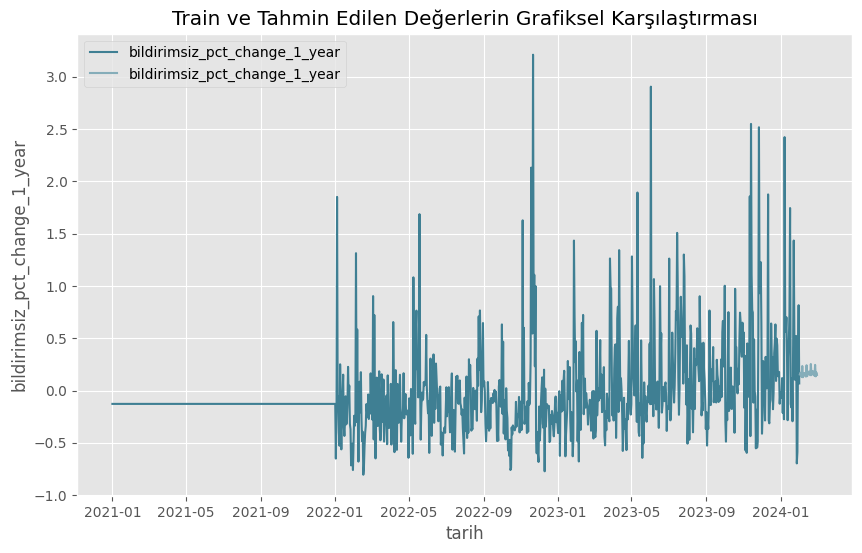

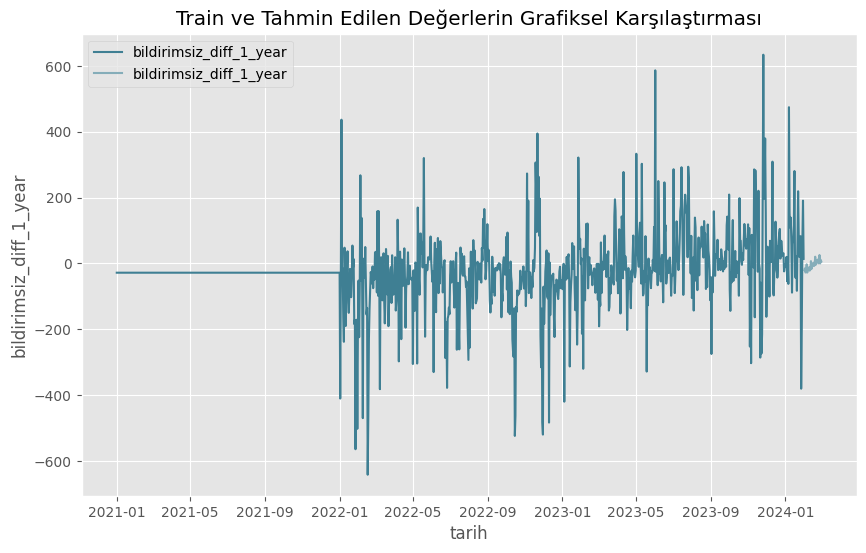

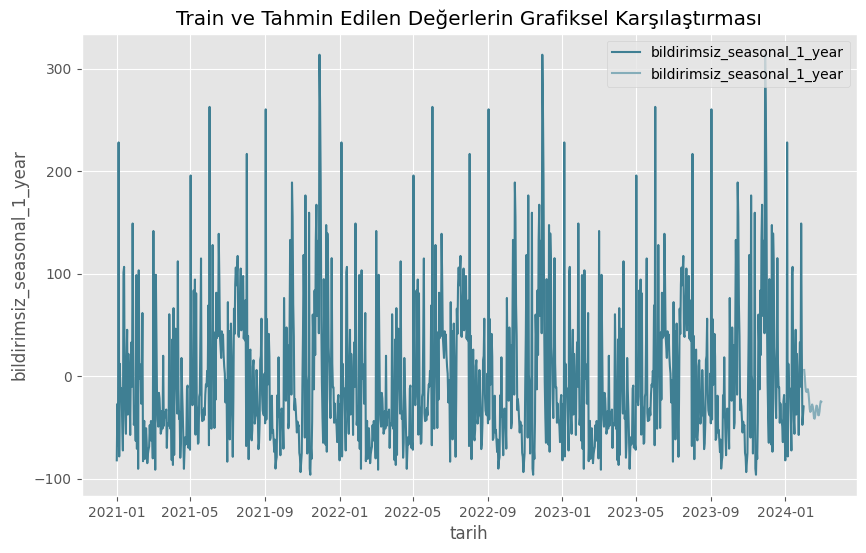

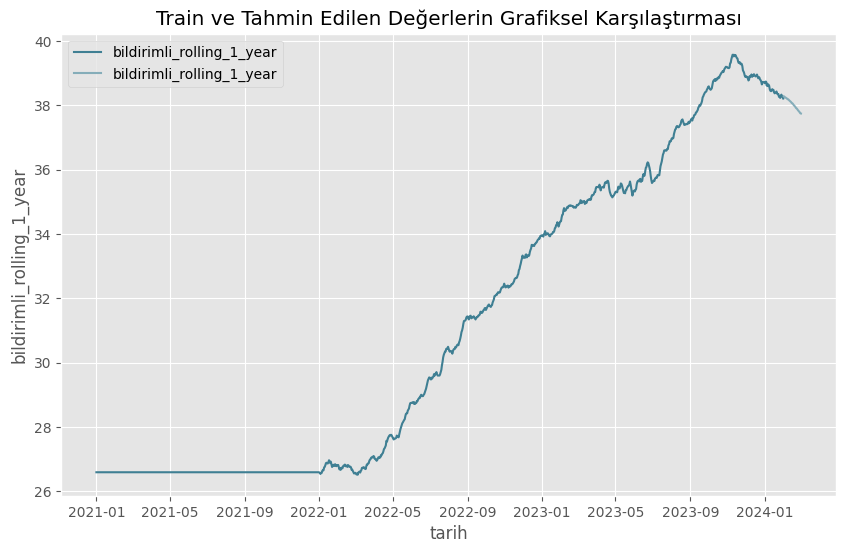

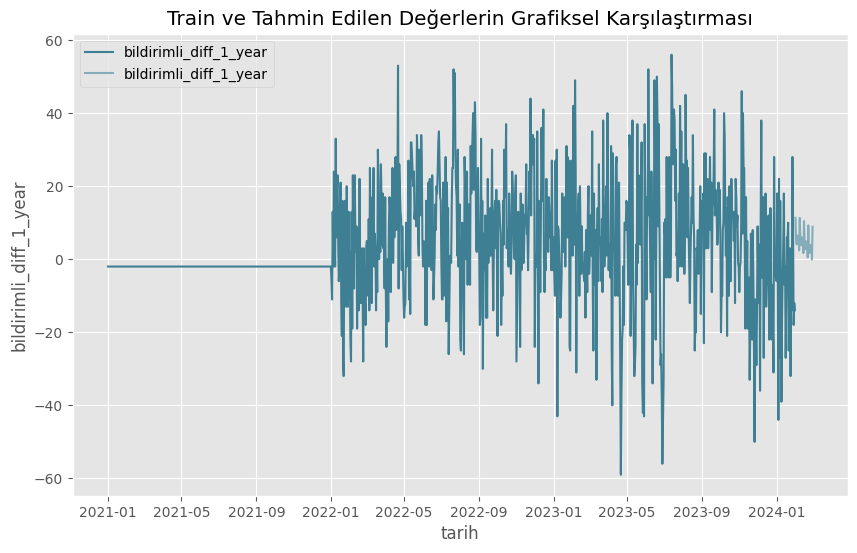

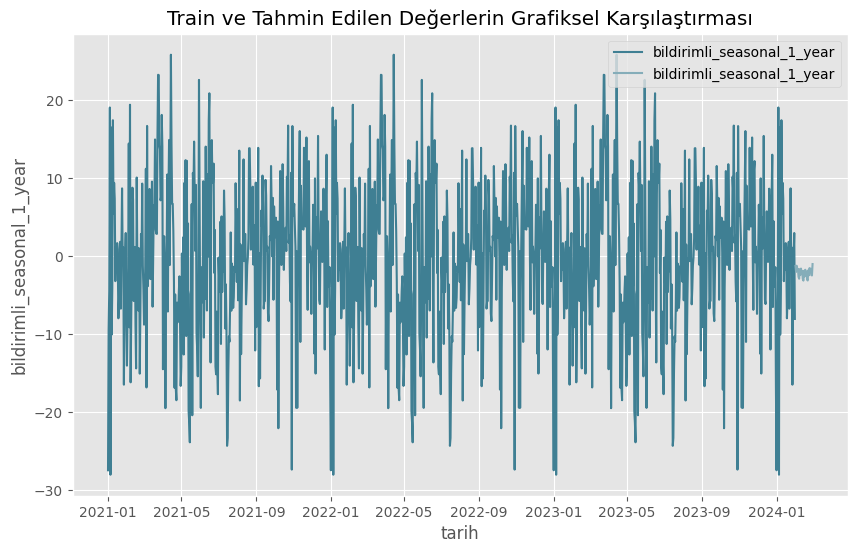

In [1830]:
plot_all_feature_predictions(time_series_train_group,time_series_test_group,train_feature_list,"tarih")

**Verilerin tekrar birleştirilmesi**

In [1831]:
time_series_train_group["tarih"] = time_series_train_group["tarih"].dt.strftime("%Y-%m-%d")
time_series_test_group["tarih"] = time_series_test_group["tarih"].dt.strftime("%Y-%m-%d")
temp_train = pd.merge(temp_train,time_series_train_group,how="left",on="tarih")
temp_test = pd.merge(temp_test,time_series_test_group,how="left",on="tarih")
train_test_concat=pd.concat([temp_train,temp_test],axis=0)

In [1832]:
def plot_features(df:pd.DataFrame,feature_list:list, date_col:str):
    for feature in feature_list:
        plt.figure(figsize=(10, 6))
        plt.plot(df[date_col], df[feature], label=feature)
        plt.title(f"{feature} Grafiği")
        plt.xlabel(date_col)
        plt.ylabel(feature)
        plt.legend()
        plt.grid(True)
        plt.show()

**Kontrol**

In [1833]:
# plot_features(train_test_concat,train_feature_list,"tarih")

In [1834]:
train_test_concat.describe().T

count         mean         std  \
bildirimsiz_sum                         48148.0     5.827127    5.059967   
bildirimli_sum                          49511.0     0.767385    1.167630   
lat                                     49511.0    38.535126    0.301920   
long                                    49511.0    27.502125    0.625106   
temp                                    49511.0    22.656125    8.893033   
cloud_cover                             49511.0    59.598253   37.431510   
global_rad                              49511.0   669.067932  223.410178   
relative_humidity                       49511.0    83.483355   12.293861   
wind_dir                                49511.0   156.199457   75.806460   
wind_speed                              49511.0     4.496383    2.006146   
precip                                  49511.0    13.700402   27.236393   
temp_app                                49511.0    27.108089   10.247455   
temp_measure_app_diff                   49511.0     5.281558    1.986155   
cloud_cover_min                         49511.0     7.235140   16.334423   
relative_humidity_min                   49511.0    42.699608   16.320206   
wind_speed_min                          49511.0     1.322419    1.399209   
precip_min                              49511.0     1.001931    0.122985   
temp_min                                49511.0    12.815320    7.241180   
blackout_ratio_per_city_county          49511.0     0.022600    0.011715   
planned_blackout_ratio_per_city_county  49511.0     0.022464    0.011557   
year                                    49511.0  2022.105714    0.916452   
month                                   49511.0     6.263840    3.538062   
day                                     49511.0    15.697784    8.782340   
bildirimli_sum_ratio_per_city_county    49511.0     0.022460    0.011520   
year_bildirimsiz_sum_ratio              49511.0     0.308046    0.074212   
year_bildirimli_sum_ratio               49511.0     0.302885    0.077110   
month_bildirimsiz_sum_ratio             49511.0     0.084183    0.015233   
month_bildirimli_sum_ratio              49511.0     0.083918    0.008615   
day_bildirimsiz_sum_ratio               49511.0     0.032506    0.004762   
day_bildirimli_sum_ratio                49511.0     0.032483    0.004481   
weekday                                 49511.0     2.985256    1.995426   
dayofyear                               49511.0   175.060653  108.028738   
weekday_bildirimsiz_sum_ratio           49511.0     0.142891    0.004492   
weekday_bildirimli_sum_ratio            49511.0     0.142878    0.011014   
dayofyear_bildirimsiz_sum_ratio         49511.0     0.002779    0.000831   
dayofyear_bildirimli_sum_ratio          49511.0     0.002771    0.000706   
il_ilce_performans                      49511.0     0.377653    0.484805   
weather_profile_of_county               49511.0     0.576680    0.767611   
coords_clusters                         49511.0     0.661085    0.827582   
bildirimsiz_rolling_1_year              49511.0   252.942508   25.606892   
bildirimsiz_pct_change_1_year           49511.0    -0.016949    0.410679   
bildirimsiz_diff_1_year                 49511.0   -20.617985  107.136611   
bildirimsiz_seasonal_1_year             49511.0     0.468205   69.910221   
bildirimli_rolling_1_year               49511.0    31.328071    4.717557   
bildirimli_diff_1_year                  49511.0     3.265127   15.053525   
bildirimli_seasonal_1_year              49511.0    -0.017165    9.526116   

                                                min          25%          50%  \
bildirimsiz_sum                            0.000000     2.000000     4.000000   
bildirimli_sum                             0.000000     0.000000     0.000000   
lat                                       37.950800    38.325000    38.471000   
long                                      26.303200    27.069700    27.381800   
temp                                      -2.700000    15.800000

**Coğrafik Özellikler**

In [1835]:
# from geopy.distance import geodesic

# izmir_base_coords = (38.4192, 27.1287)  
# manisa_base_coords = (38.6191, 27.4286)  

# def calculate_distance(row):
#     coords = (row["lat"], row["long"])  
#     distance = geodesic(izmir_coords, coords).kilometers
#     return distance

# train_test_concat[["izmir_center_distance", "manisa_center_distance"]] = train_test_concat.apply(calculate_distance, axis=1)
# train_test_concat.head()

**Max - Min sıcaklık ve rüzgar hızı farkı farkı**

In [1836]:
train_test_concat ["temp_max_min_diff"] = train_test_concat ["temp"] - train_test_concat ["temp_min"]
train_test_concat ["wind_speed_max_min_diff"] = train_test_concat ["wind_speed"] - train_test_concat ["wind_speed_min"]

**Korelasyon Analizi**

In [1837]:
# sns.pairplot(data=train_test_concat,vars=["bildirimsiz_sum",
#                                           "bildirimli_sum",
#                                           "temp", 
#                                           "cloud_cover", 
#                                           "global_rad", 
#                                           "relative_humidity", 
#                                           "wind_dir", 
#                                           "wind_speed",
#                                           "precip",
#                                           "blackout_ratio_per_city_county","planned_blackout_ratio_per_city_county"])
# plt.show()

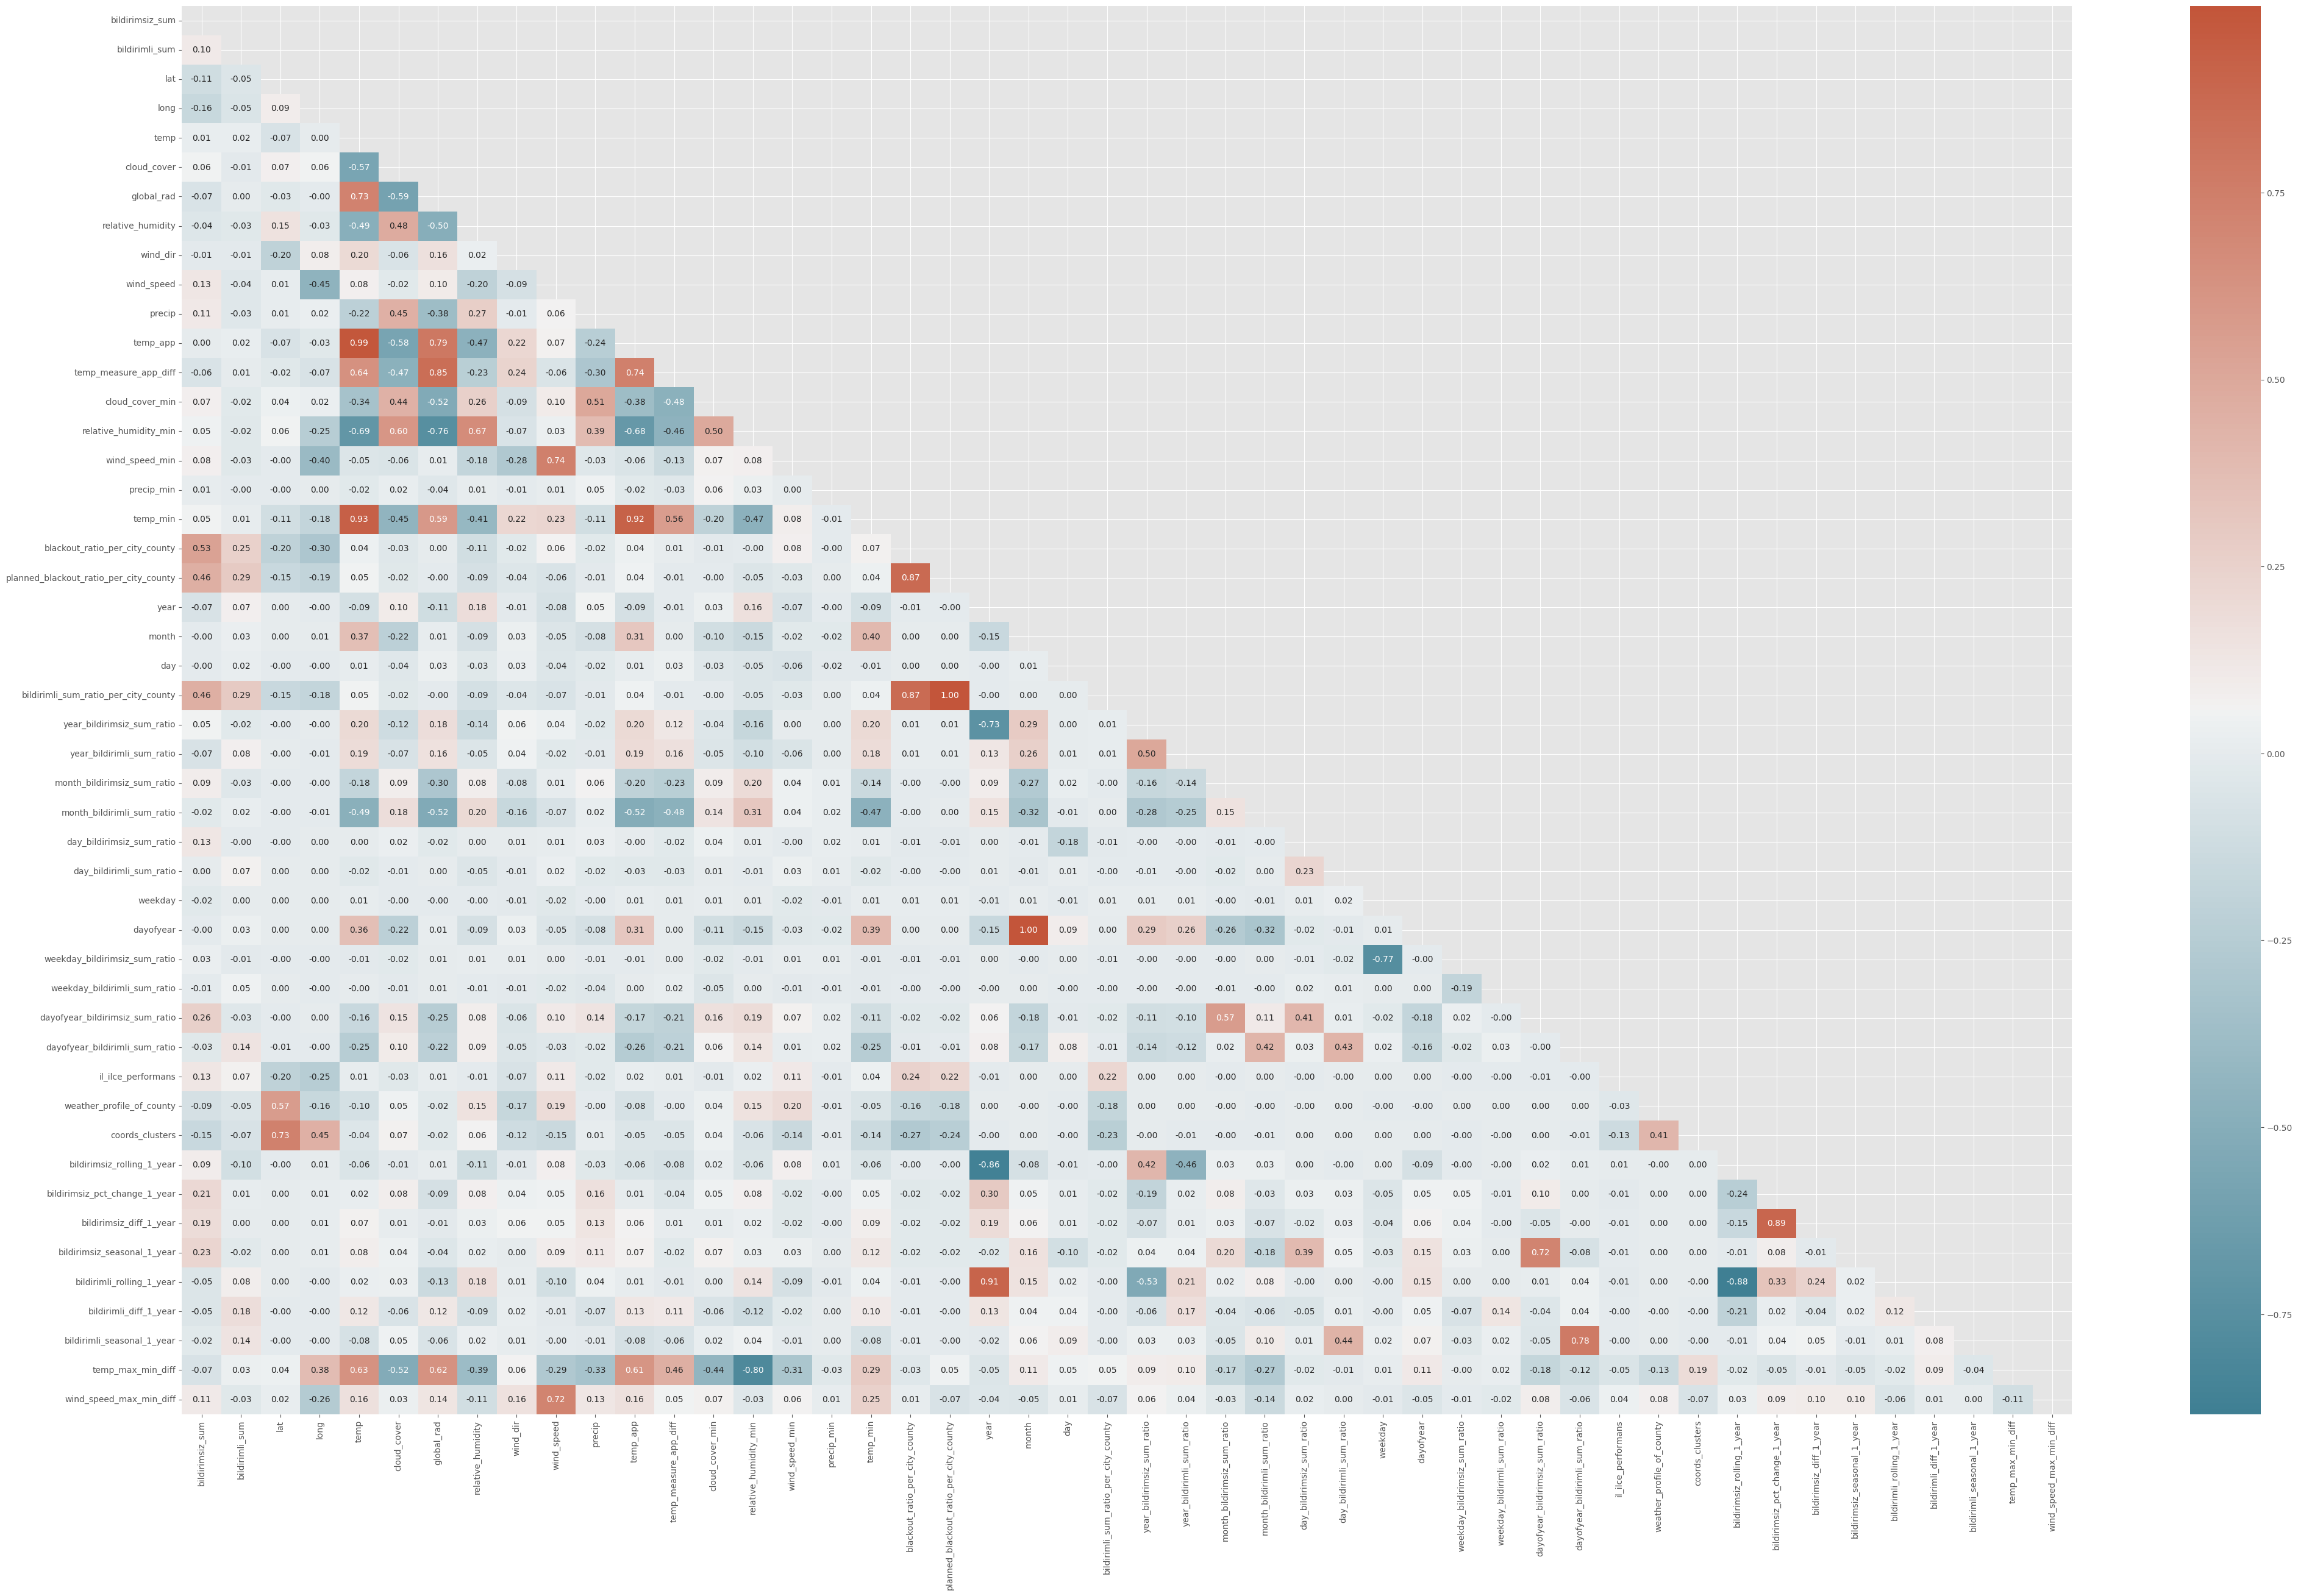

In [1838]:
plt.figure(figsize=(50, 30))
num_variables = train_test_concat.select_dtypes(exclude=["object","category"])
corr_df = num_variables.corr()
mask = np.triu(np.ones_like(corr_df, dtype=bool))
tri_df = corr_df.mask(mask)
cmap = sns.diverging_palette(220, 20, as_cmap=True)
sns.heatmap(tri_df,annot=True,fmt=".2f",cmap = cmap)
plt.show()

**Multicollinearity probleminden dolayı 0.75 üzeri korelasyonlu olan değişkenlerin 1 tanesi overfittinge yol açmaması için veri setinden çıkarılmıştır. Bu değişkenler;**
- temp ve temp_app: 0.99 korelasyon var, temp_app çıkarıldı. 
- global_rad ve temp_measure_app_diff: 0.85 temp_measure_app_diff çıkarıldı.
- planned_blackout_ratio_per_city_county ve blackout_ratio_per_city_county:0.86 planned_blackout_ratio_per_city_county çıkarıldı.

In [1839]:
train_test_concat.drop(["temp_app","temp_measure_app_diff"],axis=1,inplace=True)

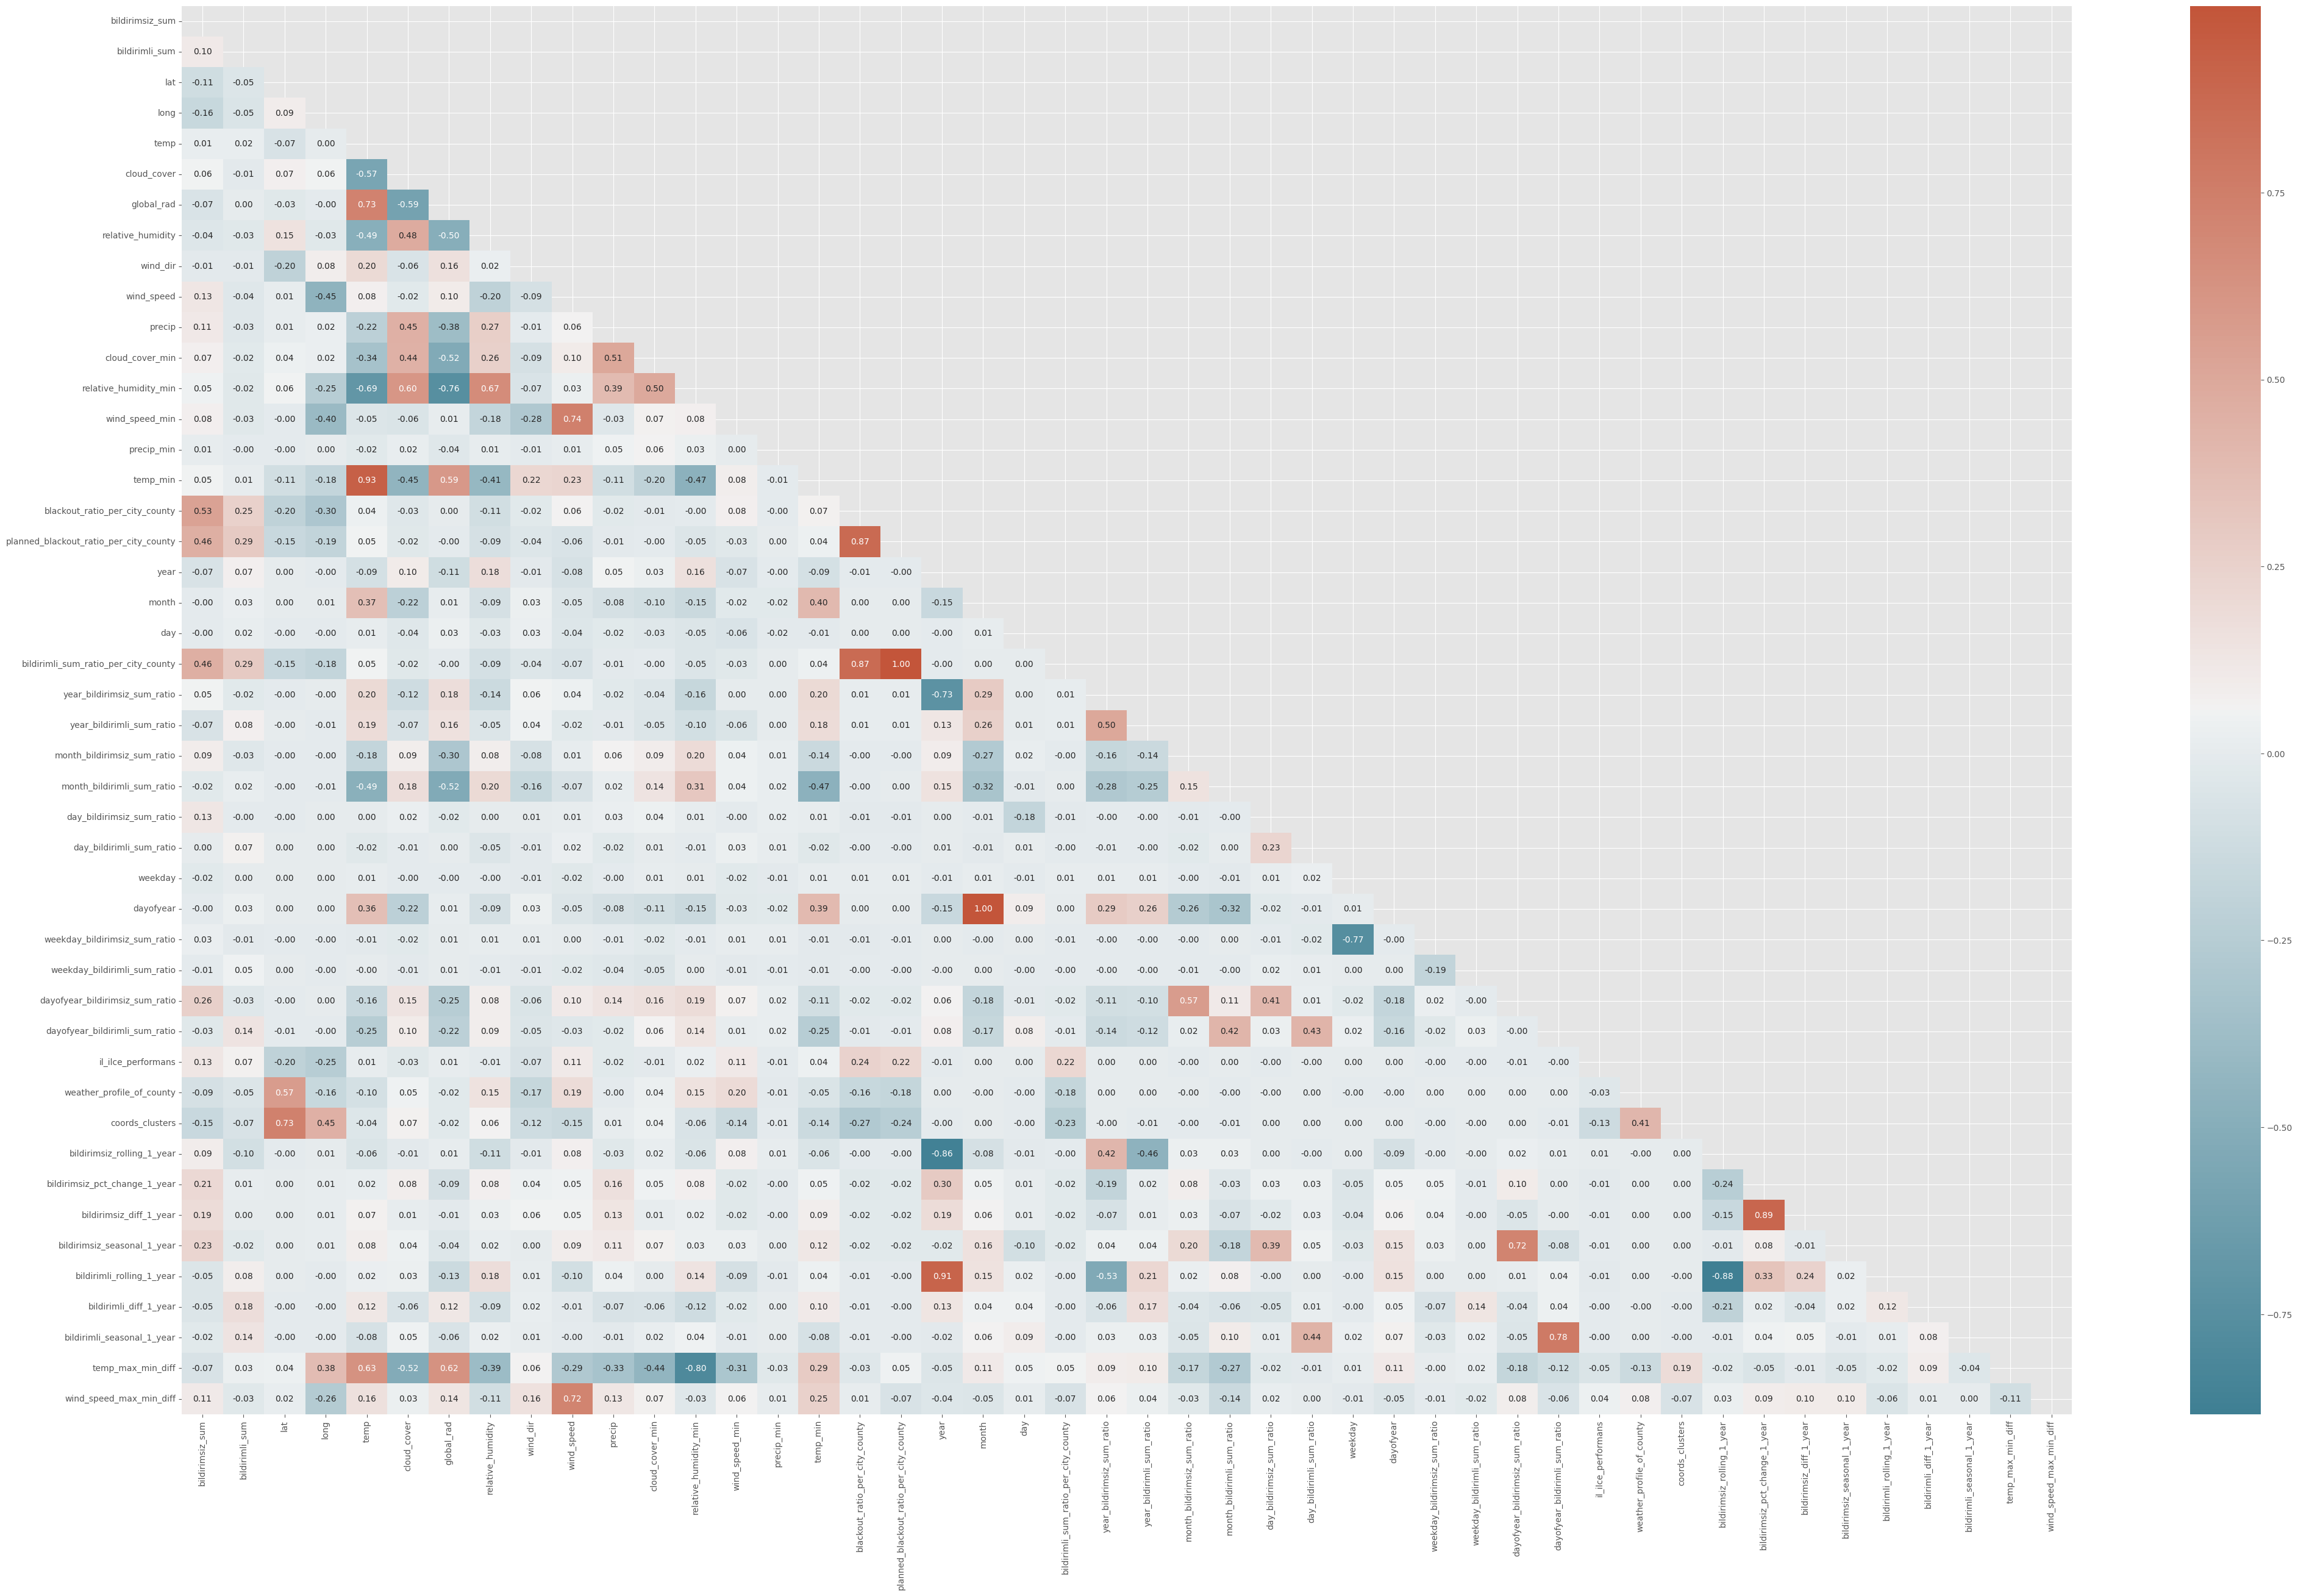

In [1840]:
plt.figure(figsize=(50, 30))
num_variables = train_test_concat.select_dtypes(exclude=["object","category"])
corr_df = num_variables.corr()
mask = np.triu(np.ones_like(corr_df, dtype=bool))
tri_df = corr_df.mask(mask)
cmap = sns.diverging_palette(220, 20, as_cmap=True)
sns.heatmap(tri_df,annot=True,fmt=".2f",cmap = cmap)
plt.show()

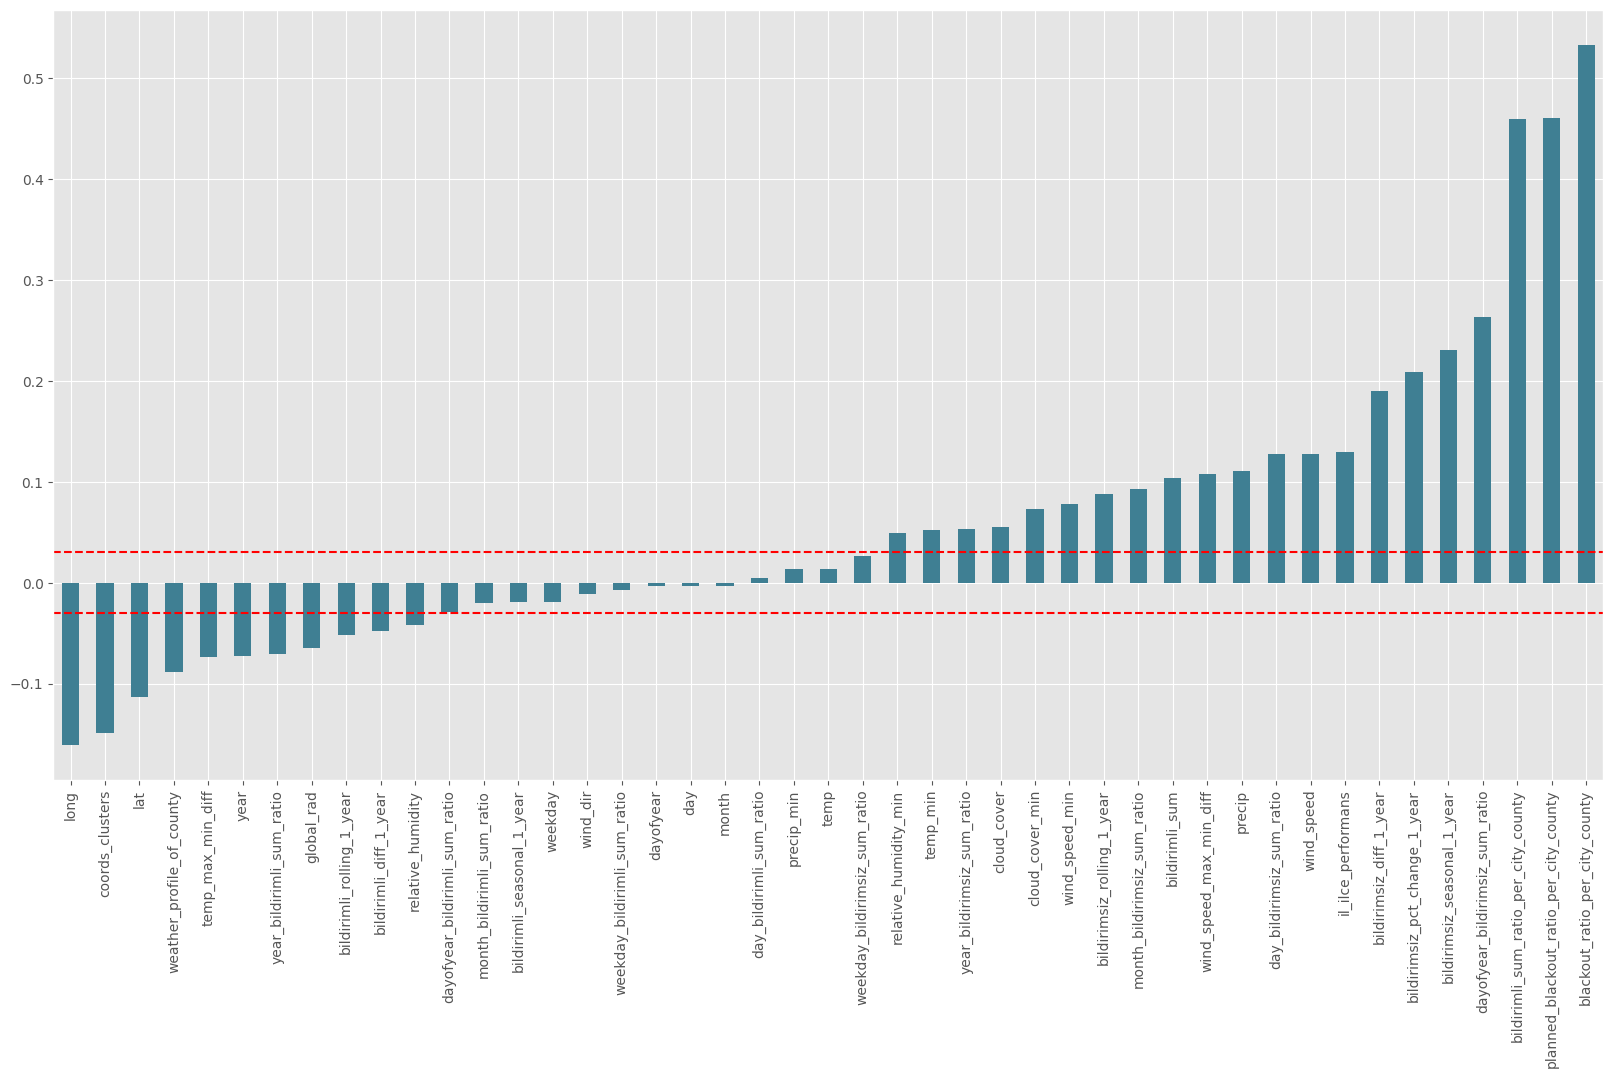

In [1841]:
plt.figure(figsize=(20, 10))
tri_df["bildirimsiz_sum"].drop("bildirimsiz_sum").sort_values().plot(kind="bar")
plt.axhline(0.03, color ="red",linestyle ='--')
plt.axhline(-0.03, color='red',linestyle='--')
plt.show()

In [1842]:
cor_target = abs(tri_df["bildirimsiz_sum"])
cor_target.drop("bildirimsiz_sum",inplace=True,axis=0)
correlated_features  = cor_target[cor_target >=0.03]
print("Toplam sayısal özellik sayısı:",len(train_test_concat.select_dtypes(exclude="object").columns))
print("Korelasyonlu özellik sayısı:",len(correlated_features))

Toplam sayısal özellik sayısı: 52
Korelasyonlu özellik sayısı: 32


**Veri Ön İşleme**
- Bayram flag one hot encoding işlemi

In [1843]:
bayram_one_hot = pd.get_dummies(train_test_concat["flag"],drop_first=True).astype(int)
train_test_concat.drop("flag", axis=1,inplace=True)
train_test_concat=pd.concat([train_test_concat,bayram_one_hot], axis=1)
train_test_concat.head()

tarih        il_ilce  bildirimsiz_sum  bildirimli_sum  \
0  2021-01-01   izmir-aliaga              5.0               0   
1  2021-01-01   izmir-dikili              5.0               0   
2  2021-01-01     izmir-urla             18.0               0   
3  2021-01-01     izmir-foca              8.0               0   
4  2021-01-01  izmir-torbali              5.0               0   

                  unique_id      lat     long  temp  cloud_cover  global_rad  \
0   2021-01-01-izmir-aliaga  38.7996  26.9707  15.8         97.1       338.4   
1   2021-01-01-izmir-dikili  39.0749  26.8892  15.9         99.9       296.0   
2     2021-01-01-izmir-urla  38.3250  26.7668  15.6         99.1       355.9   
3     2021-01-01-izmir-foca  38.6704  26.7579  15.8         93.0       380.9   
4  2021-01-01-izmir-torbali  38.1558  27.3646  15.2         97.2       231.7   

   relative_humidity  wind_dir  wind_speed  precip  cloud_cover_min  \
0               91.8     167.2         6.4     1.0             24.7   
1               93.8     160.2         5.5    12.0             17.1   
2               95.1     172.8         5.7     1.0             33.6   
3               91.8     168.8         7.2    12.8             24.8   
4               94.1     100.3         2.2     6.2             18.1   

   relative_humidity_min  wind_speed_min  precip_min  temp_min     il  \
0                   75.7             1.8         1.0      11.3  izmir   
1                   73.6             1.4         1.0      11.5  izmir   
2                   80.7             2.4         1.0      11.5  izmir   
3                   74.5             3.9         1.0      12.6  izmir   
4                   83.2             1.2         1.0       9.9  izmir   

      ilce  blackout_ratio_per_city_county  \
0   aliaga                        0.021574   
1   dikili                        0.023165   
2     urla                        0.036536   
3     foca                        0.017549   
4  torbali                        0.034582   

   planned_blackout_ratio_per_city_county  year  month  day  \
0                                0.020552  2021      1    1   
1                                0.015801  2021      1    1   
2                                0.032415  2021      1    1   
3                                0.013591  2021      1    1   
4                                0.031806  2021      1    1   

   bildirimli_sum_ratio_per_city_county  year_bildirimsiz_sum_ratio  \
0                              0.020877                    0.369362   
1                              0.015729                    0.369362   
2                              0.032135                    0.369362   
3                              0.013805                    0.369362   
4                              0.032135                    0.369362   

   year_bildirimli_sum_ratio  month_bildirimsiz_sum_ratio  \
0                   0.255514                     0.120049   
1                   0.255514                     0.120049   
2                   0.255514                     0.120049   
3                   0.255514                     0.120049   
4                   0.255514                     0.120049   

   month_bildirimli_sum_ratio  day_bildirimsiz_sum_ratio  \
0                    0.095936                   0.027443   
1                    0.095936                   0.027443   
2                    0.095936                   0.027443   
3                    0.095936                   0.027443   
4                    0.095936                   0.027443   

   day_bildirimli_sum_ratio  weekday  dayofyear  \
0                  0.025873        4          1   
1                  0.025873        4          1   
2                  0.025873        4          1   
3                  0.025873        4          1   
4                  0.025873        4          1   

   weekday_bildirimsiz_sum_ratio  weekday_bildirimli_sum_ratio  \
0                       0.144248                      0.152445   
1                   

- İl İlçe alan büyüklüklerine göre label encoding işlemi

In [1844]:
train_test_concat["il_ilce"].nunique()

47

In [1845]:
data = {
    "ilce": ["izmir-aliaga", "izmir-balcova", "izmir-bayindir", "izmir-bayrakli", "izmir-bergama", "izmir-beydag", "izmir-bornova", "izmir-buca", "izmir-cesme", "izmir-cigli", "izmir-dikili", "izmir-foca", "izmir-gaziemir", "izmir-guzelbahce", "izmir-karabaglar", "izmir-karaburun", "izmir-karsiyaka", "izmir-kemalpasa", "izmir-kinik", "izmir-kiraz", "izmir-konak", "izmir-menderes", "izmir-menemen", "izmir-narlidere", "izmir-odemis", "izmir-seferihisar", "izmir-selcuk", "izmir-tire", "izmir-torbali", "izmir-urla", "manisa-ahmetli", "manisa-akhisar", "manisa-alasehir", "manisa-demirci", "manisa-golmarmara", "manisa-gordes", "manisa-kirkagac", "manisa-koprubasi", "manisa-kula", "manisa-salihli", "manisa-sarigol", "manisa-saruhanli", "manisa-selendi", "manisa-soma", "manisa-sehzadeler", "manisa-turgutlu", "manisa-yunusemre"],
    "alanı_km2": [379, 16, 548, 30, 1544, 172, 220, 178, 285, 139, 534, 251, 70, 77, 89, 421, 51, 681, 479, 573, 24, 777, 573, 50, 1019, 375, 317, 716, 577, 727, 227, 1645, 971, 1321, 310, 902, 541, 447, 981, 1359, 432, 771, 726, 820, 515, 549, 823]
}
il_ilce_df = pd.DataFrame(data).reset_index(drop=True).sort_values("alanı_km2")
il_ilce_df.head()

ilce  alanı_km2
1     izmir-balcova         16
20      izmir-konak         24
3    izmir-bayrakli         30
23  izmir-narlidere         50
16  izmir-karsiyaka         51

In [1846]:
order_cols = il_ilce_df["ilce"].to_list()
train_test_concat["il_ilce_label_enc"] = pd.Categorical(train_test_concat["il_ilce"],categories=order_cols,ordered=True)
train_test_concat["il_ilce_label_enc"] = train_test_concat["il_ilce_label_enc"].cat.codes
train_test_concat["il_ilce_label_enc"].nunique()

47

In [1847]:
train_test_concat.head()

tarih        il_ilce  bildirimsiz_sum  bildirimli_sum  \
0  2021-01-01   izmir-aliaga              5.0               0   
1  2021-01-01   izmir-dikili              5.0               0   
2  2021-01-01     izmir-urla             18.0               0   
3  2021-01-01     izmir-foca              8.0               0   
4  2021-01-01  izmir-torbali              5.0               0   

                  unique_id      lat     long  temp  cloud_cover  global_rad  \
0   2021-01-01-izmir-aliaga  38.7996  26.9707  15.8         97.1       338.4   
1   2021-01-01-izmir-dikili  39.0749  26.8892  15.9         99.9       296.0   
2     2021-01-01-izmir-urla  38.3250  26.7668  15.6         99.1       355.9   
3     2021-01-01-izmir-foca  38.6704  26.7579  15.8         93.0       380.9   
4  2021-01-01-izmir-torbali  38.1558  27.3646  15.2         97.2       231.7   

   relative_humidity  wind_dir  wind_speed  precip  cloud_cover_min  \
0               91.8     167.2         6.4     1.0             24.7   
1               93.8     160.2         5.5    12.0             17.1   
2               95.1     172.8         5.7     1.0             33.6   
3               91.8     168.8         7.2    12.8             24.8   
4               94.1     100.3         2.2     6.2             18.1   

   relative_humidity_min  wind_speed_min  precip_min  temp_min     il  \
0                   75.7             1.8         1.0      11.3  izmir   
1                   73.6             1.4         1.0      11.5  izmir   
2                   80.7             2.4         1.0      11.5  izmir   
3                   74.5             3.9         1.0      12.6  izmir   
4                   83.2             1.2         1.0       9.9  izmir   

      ilce  blackout_ratio_per_city_county  \
0   aliaga                        0.021574   
1   dikili                        0.023165   
2     urla                        0.036536   
3     foca                        0.017549   
4  torbali                        0.034582   

   planned_blackout_ratio_per_city_county  year  month  day  \
0                                0.020552  2021      1    1   
1                                0.015801  2021      1    1   
2                                0.032415  2021      1    1   
3                                0.013591  2021      1    1   
4                                0.031806  2021      1    1   

   bildirimli_sum_ratio_per_city_county  year_bildirimsiz_sum_ratio  \
0                              0.020877                    0.369362   
1                              0.015729                    0.369362   
2                              0.032135                    0.369362   
3                              0.013805                    0.369362   
4                              0.032135                    0.369362   

   year_bildirimli_sum_ratio  month_bildirimsiz_sum_ratio  \
0                   0.255514                     0.120049   
1                   0.255514                     0.120049   
2                   0.255514                     0.120049   
3                   0.255514                     0.120049   
4                   0.255514                     0.120049   

   month_bildirimli_sum_ratio  day_bildirimsiz_sum_ratio  \
0                    0.095936                   0.027443   
1                    0.095936                   0.027443   
2                    0.095936                   0.027443   
3                    0.095936                   0.027443   
4                    0.095936                   0.027443   

   day_bildirimli_sum_ratio  weekday  dayofyear  \
0                  0.025873        4          1   
1                  0.025873        4          1   
2                  0.025873        4          1   
3                  0.025873        4          1   
4                  0.025873        4          1   

   weekday_bildirimsiz_sum_ratio  weekday_bildirimli_sum_ratio  \
0                       0.144248                      0.152445   
1                   

**bildirimsiz_sum_category_2021	bildirimsiz_sum_category_2022	bildirimsiz_sum_category_2023 değişkenleri label encoding**

In [1848]:
for cat in ["bildirimsiz_sum_category_2021","bildirimsiz_sum_category_2022","bildirimsiz_sum_category_2023"]:
    train_test_concat[cat] = train_test_concat[cat].cat.codes
    print(train_test_concat[cat].value_counts())
    print("*************************")

bildirimsiz_sum_category_2021
2    13656
1    10928
3    10370
0     9945
4     4612
Name: count, dtype: int64
*************************
bildirimsiz_sum_category_2022
1    16775
2    14946
0    12023
3     4613
4     1154
Name: count, dtype: int64
*************************
bildirimsiz_sum_category_2023
1    16574
2    13769
0     9945
3     9223
Name: count, dtype: int64
*************************


**temp_category	wind_speed_category	precip_category kategorik değişkenler label encoding**

In [1849]:
for cat in ["temp_category","wind_speed_category","precip_category"]:
    train_test_concat[cat] = train_test_concat[cat].cat.codes
    print(train_test_concat[cat].value_counts())
    print("*************************")

temp_category
4    19937
3    18653
2     7491
1     2871
0      559
Name: count, dtype: int64
*************************
wind_speed_category
3    20649
2    14324
4    10479
5     2438
1     1152
6      412
7       55
8        2
Name: count, dtype: int64
*************************
precip_category
0    35681
4     9090
3     1926
2     1591
1     1223
Name: count, dtype: int64
*************************


In [1850]:
# columns_that_will_not_used = ["tarih","il_ilce","il","ilce","unique_id","day", "weekday","dayofyear",
                              
#                               "blackout_ratio_per_city_county","planned_blackout_ratio_per_city_county", "bildirimli_sum_ratio_per_city_county",
#                               "month_bildirimli_sum_ratio","year_bildirimli_sum_ratio","day_bildirimsiz_sum_ratio","day_bildirimli_sum_ratio", 
#                               "weekday_bildirimsiz_sum_ratio", "weekday_bildirimli_sum_ratio", "dayofyear_bildirimsiz_sum_ratio","dayofyear_bildirimli_sum_ratio",

#                               "temp_category","wind_speed_category","precip_category","weather_profile_of_county","coords_clusters",

#                               "bildirimli_seasonal_3_month","bildirimli_rolling_3_month",
#                               "bildirimsiz_sum_category_2021", "bildirimsiz_sum_category_2022","bildirimsiz_sum_category_2023",  "il_ilce_performans", "bildirimsiz_pct_change_1_year",
#                               "bildirimsiz_rolling_3_month", "bildirimsiz_seasonal_3_month","month_bildirimsiz_sum_ratio",

#                               'cloud_cover', 'global_rad',
#                                "precip",
#                               "cloud_cover_min", "relative_humidity_min", "relative_humidity","wind_dir","temp_min","wind_speed_min"

#                               ] 

In [1851]:
# train_test_concat.drop(columns_that_will_not_used,axis=1,inplace=True)

**Korelasyon Kontrol**

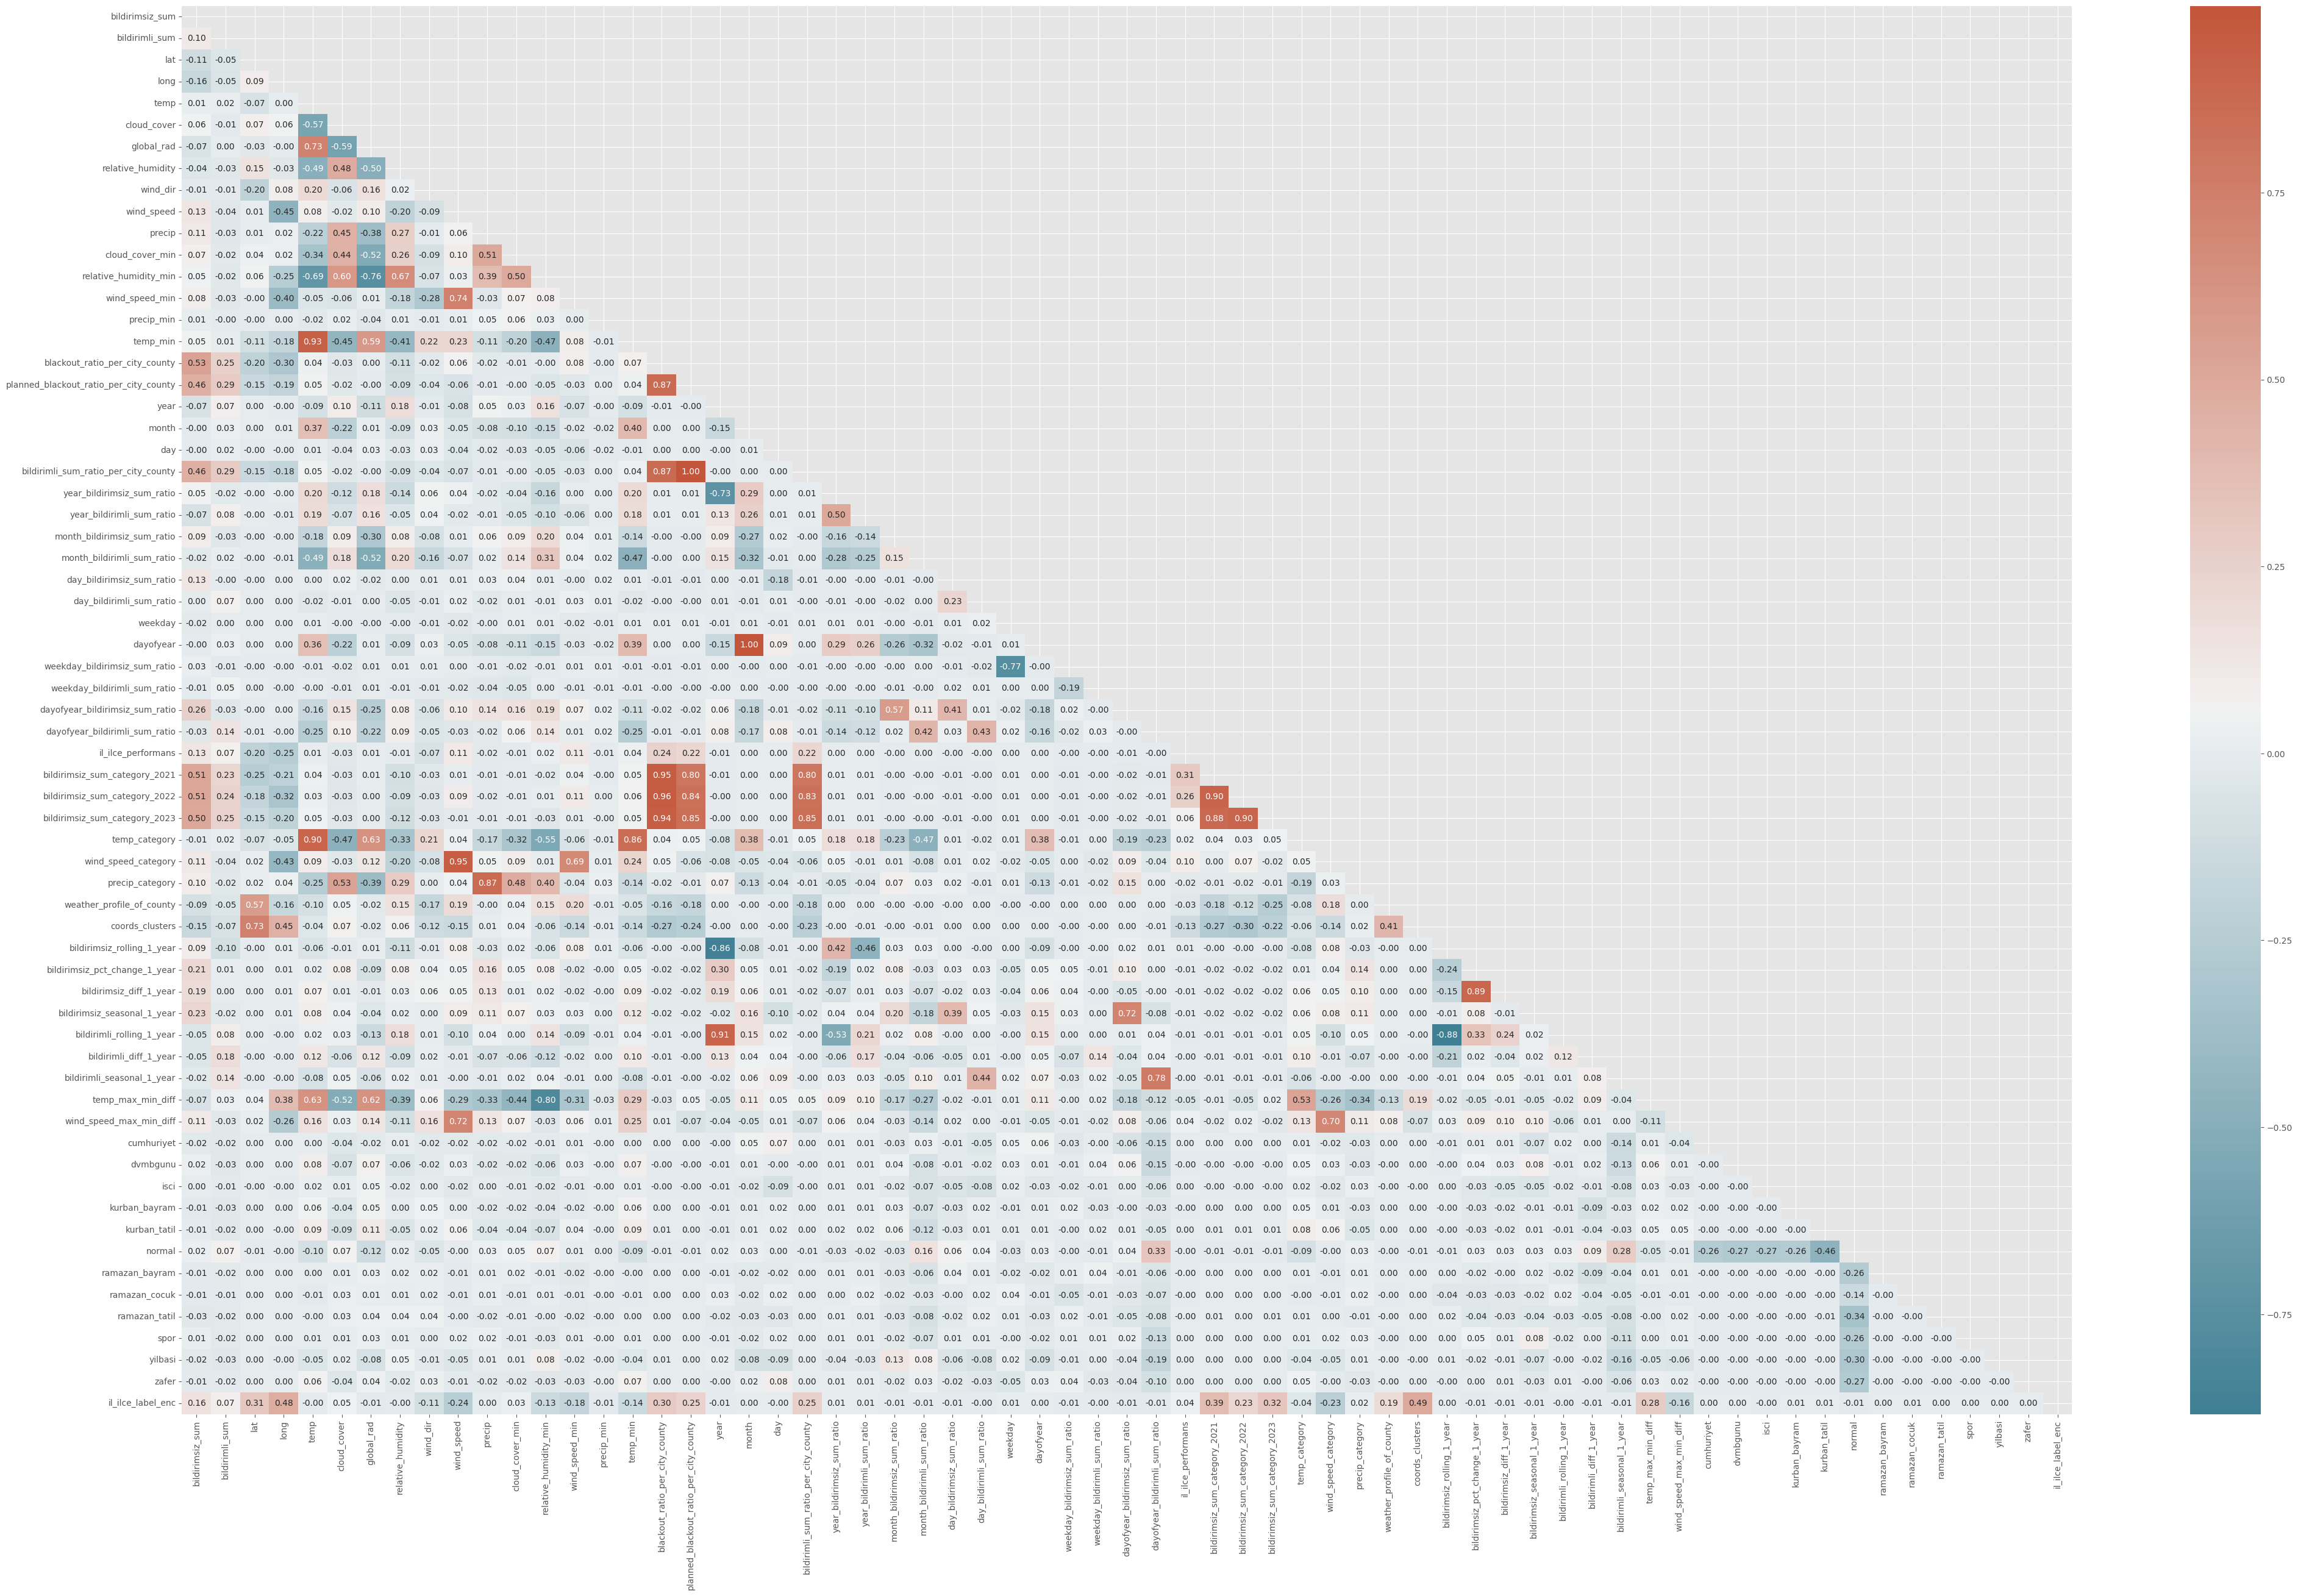

In [1852]:
plt.figure(figsize=(50, 30))
num_variables = train_test_concat.select_dtypes(exclude=["object","category"])
corr_df = num_variables.corr()
mask = np.triu(np.ones_like(corr_df, dtype=bool))
tri_df = corr_df.mask(mask)
cmap = sns.diverging_palette(220, 20, as_cmap=True)
sns.heatmap(tri_df,annot=True,fmt=".2f",cmap = cmap)
plt.show()

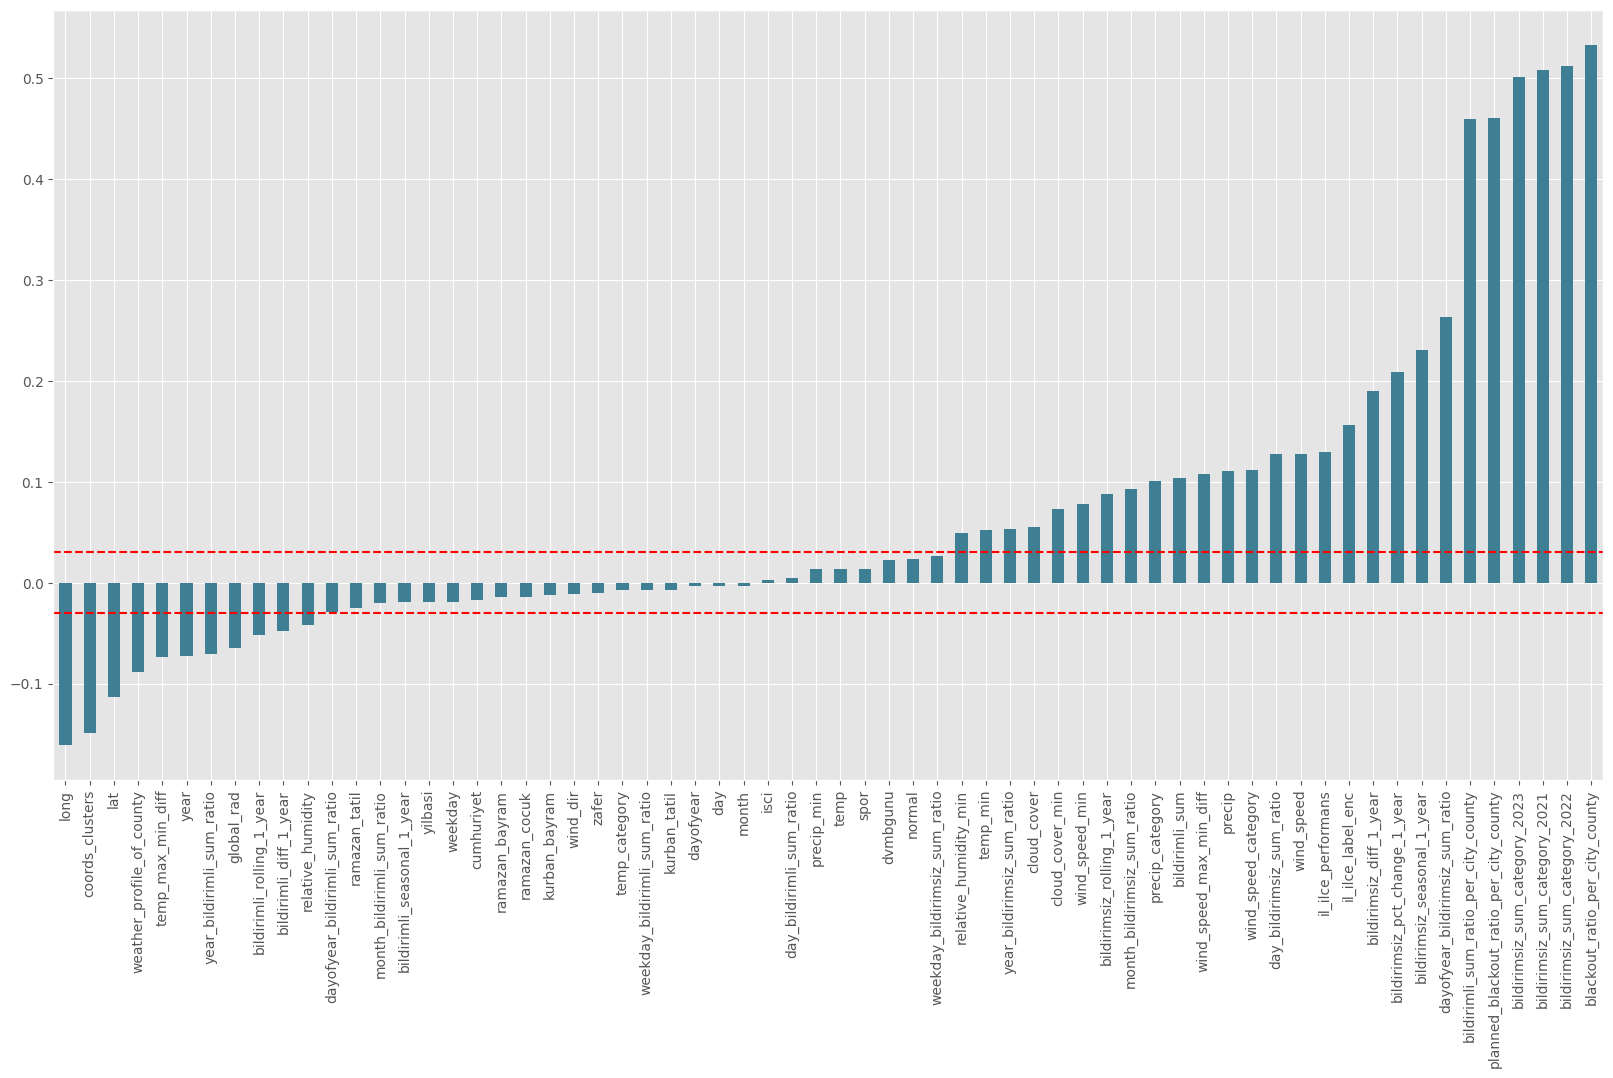

In [1853]:
plt.figure(figsize=(20, 10))
tri_df["bildirimsiz_sum"].drop("bildirimsiz_sum").sort_values().plot(kind="bar")
plt.axhline(0.03, color ="red",linestyle ='--')
plt.axhline(-0.03, color='red',linestyle='--')
plt.show()

In [1854]:
cor_target = abs(tri_df["bildirimsiz_sum"])
cor_target.drop("bildirimsiz_sum",inplace=True,axis=0)
correlated_features  = cor_target[cor_target >=0.03]
print("Toplam sayısal özellik sayısı:",len(train_test_concat.select_dtypes(exclude="object").columns))
print("Korelasyonlu özellik sayısı:",len(correlated_features))

Toplam sayısal özellik sayısı: 65
Korelasyonlu özellik sayısı: 38


**Model Oluşturma ve Değerlendirme**

**Model eğitim ve değerlendirme için kullanılacak fonksiyonun tanımlanması**
- Tüm model eğitimi ve değerlendirme süreci, işleri kolay ve hatasız hale getirmek, zaman kazanmak, denemeler yapmak için fonksiyona dönüştürülmüştür. Bu fonksiyon, modeli, bölünmüş verileri, çapraz doğrulama stratejisini, model değerlendirmede kullanılacak metriği  parametre olarak alır ve eğitilmiş modeli, eğitim ve doğrulama skorlarını içeren dataframe'i, son test skorunu ve test seti üzerindeki tahminleri döndürür. Plot parametresi aynı zamanda True olarak belirtilirse eğitim ve doğrulama sonuçlarını çizer. Eğitim verilerine çapraz doğrulama uygulamak, model değerlendirme aşamasında sıklıkla tercih edilen bir yöntemdir. Bu sayede modelin eğitim, doğrulama ve test seti üzerindeki sonuçlarını karşılaştırarak aşırı uyum ve yetersiz uyum durumlarını daha kolay gözlemleyebilir ve hiperparametreleri bu sonuçlara göre ayarlayabiliriz.

In [1855]:
def train_and_evaluate_model(model, X_train, y_train, X_test, y_test, score_func, cv_type, plot=True, use_rmse=False):
    """
    This function uses cross-validation to evaluate the performance of a model.
    It allows comparison by calculating training score, validation score, and test score separately.
    First, it performs cross-validation, then trains the model with the entire training set from scratch to calculate the test score.
    This enables a better evaluation of model performance and detection of issues such as overfitting or underfitting.

    Parameters:
    model: the model to be trained.
    X_train: pandas.DataFrame, the split training dataset.
    y_train: pandas.Series, the target variable of the training dataset.
    X_test: pandas.DataFrame, the split test dataset.
    y_test: pandas.Series, the target variable of the test dataset.
    score_func: function, evaluation metric. For example, mean_squared_error, mean_absolute_error, etc.
    cv_type: cross-validation strategy. For example, KFold, StratifiedKFold, etc.
    plot: bool, optional (default=True) If True, plots the training and validation scores.
    use_rmse: bool, optional (default=False) If the metric function is mean_squared_error, set to True to calculate Root Mean Squared Error.

    Returns:
    model: trained model.
    final_test_score: float, metric score obtained on the test set.
    scores_df: pandas.DataFrame, dataframe containing calculated training and validation scores.
    y_pred_test: pandas.Series, predictions on the test set.
    """

    
    # score list initialization.
    train_scores = []
    validation_scores = []
    score_per_fold = []
    fold = 1

    # cross validation stage for overfitting , underfitting detection
    for train_index, test_index in cv_type.split(X_train, y_train):
        X_train_cv, X_validation_cv = X_train.iloc[train_index], X_train.iloc[test_index]
        y_train_cv, y_validation_cv = y_train.iloc[train_index], y_train.iloc[test_index]

        # model fitting on train set
        model.fit(X_train_cv, y_train_cv)
        y_pred_train = model.predict(X_train_cv)
        y_pred_validation = model.predict(X_validation_cv)
        
        # evaluation of train score
        train_score = score_func(y_train_cv, y_pred_train)
        # evaluation of validation score
        validation_score = score_func(y_validation_cv, y_pred_validation)

       
       #if mean_squared_error score func use_rmse=True 
        if use_rmse and score_func.__name__ == "mean_squared_error":
            train_score = np.sqrt(train_score)
            validation_score = np.sqrt(validation_score)
            score_name = "root_mean_squared_error"
        else:
            train_score = train_score
            validation_score = validation_score
            score_name = score_func.__name__
        

   
        train_scores.append(train_score)
        validation_scores.append(validation_score)

        # scores per fold
        print(f"{fold}. Fold train_{score_name}: {train_score:.2f}")
        print(f"{fold}. Fold validasyon_{score_name}: {validation_score:.2f}")

        fold += 1
  
        score_per_fold.append(fold)

    print("Cross validation stage has been complated! Model is started to training...")

    # Çapraz doğrulama aşaması tamamlandıktan sonra. Model tüm eğitim seti ile tekrar eğitilir.
    model.fit(X_train, y_train)
    print("*******************************************")
    print("Model training has been complated!")
    print("*******************************************")

    # test seti üzerinden tahmin yapılması.
    y_pred_test = model.predict(X_test)
    
    # use_rmse=True calculate RMSE 
    if use_rmse and score_func.__name__ == "mean_squared_error":
        final_test_score = np.sqrt(score_func(y_test , y_pred_test))
        score_name = "root_mean_squared_error"
    else:
        final_test_score = score_func(y_test , y_pred_test)
        score_name = score_func.__name__


    # saves scores in dictionary.
    scores_dict = {
    "fold": range(1, len(score_per_fold) + 1),
    f"train_{score_name}": train_scores,
    f"validation_{score_name}": validation_scores
    }

    # df for plotting
    scores_df = pd.DataFrame(scores_dict)

    
    # diff % of validation score according to training score 
    percentage_difference_train_valid = ((np.mean(validation_scores) - np.mean(train_scores)) / np.mean(train_scores)) * 100

    # diff % of final score according to training score 
    percentage_difference_train_test = ((final_test_score - np.mean(train_scores)) / np.mean(train_scores)) * 100

  
    print(f"Average train_{score_name} result: {np.mean(train_scores):.2f}")
    print(f"Average validation_{score_name} sonucu: {np.mean(validation_scores):.2f}")
    print(f"Test_{score_name} result: {final_test_score:.2f}")
    print(f'Validation percentage according to train:%{percentage_difference_train_valid:.2f}')
    print(f'Final test percentage according to train:%{percentage_difference_train_test:.2f}')
    print("*******************************************")


    if plot:
        sns.lineplot(data=scores_df, x="fold", y=f"train_{score_name}", marker="o", label=f"train_{score_name}")
        sns.lineplot(data=scores_df, x="fold", y=f"validation_{score_name}", marker="v", label=f"validation_{score_name}")
        plt.xlabel("Katman")
        plt.ylabel(f"{score_name}")
        plt.title(f"Each fold {score_name} score")
        plt.legend()
        plt.show()

    return  model, final_test_score, scores_df, y_pred_test

**Verilerin Ayrılması**

In [1856]:
new_train = train_test_concat[train_test_concat["unique_id"].isin(train["unique_id"])]
new_train["bildirimsiz_sum"] = new_train["bildirimsiz_sum"].astype(int)
new_train["tarih"] = pd.to_datetime(new_train["tarih"])
new_test = train_test_concat[train_test_concat["unique_id"].isin(test["unique_id"])]
new_test["tarih"] = pd.to_datetime(new_test["tarih"])

In [1857]:
new_train.shape

(48148, 70)

In [1858]:
new_test.shape

(1363, 70)

**Verilerin Eğitim ve Test Olarak ayrılması**
- Model aşamasında metriklerimizi hesaplamak için veri setini eğitim ve test diye bölmek yaygın bir uygulamadır. Burada verinin %20'si test seti için ayrılmıştır.

In [1939]:
target = "bildirimsiz_sum"
columns_that_will_not_used = [target,"tarih","il_ilce","il","ilce","unique_id","day","dayofyear",
                              
                            "blackout_ratio_per_city_county","planned_blackout_ratio_per_city_county", "bildirimli_sum_ratio_per_city_county",
                            "month_bildirimli_sum_ratio","year_bildirimli_sum_ratio","day_bildirimsiz_sum_ratio","day_bildirimli_sum_ratio", 
                            "weekday_bildirimsiz_sum_ratio", "weekday_bildirimli_sum_ratio", "dayofyear_bildirimsiz_sum_ratio","dayofyear_bildirimli_sum_ratio","month_bildirimsiz_sum_ratio",

                            "temp_category","wind_speed_category","precip_category","weather_profile_of_county","coords_clusters", "il_ilce_performans",
                            'bildirimsiz_sum_category_2021', 'bildirimsiz_sum_category_2022','bildirimsiz_sum_category_2023', 

                            'bildirimsiz_pct_change_1_year', 'bildirimsiz_diff_1_year','bildirimsiz_seasonal_1_year',
                            'bildirimli_diff_1_year', 'bildirimli_seasonal_1_year',"bildirimli_rolling_1_year",

                            "relative_humidity_min","temp_min","wind_speed_min","temp_max_min_diff","wind_speed_max_min_diff","precip_min","cloud_cover_min","relative_humidity"

                              ] 
feature_columns = [col for col in new_train.columns if col not in columns_that_will_not_used]
X = new_train[feature_columns]
y= new_train[target]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.10, random_state=42)

In [1940]:
X.columns

Index(['bildirimli_sum', 'lat', 'long', 'temp', 'cloud_cover', 'global_rad',
       'wind_dir', 'wind_speed', 'precip', 'year', 'month',
       'year_bildirimsiz_sum_ratio', 'weekday', 'bildirimsiz_rolling_1_year',
       'cumhuriyet', 'dvmbgunu', 'isci', 'kurban_bayram', 'kurban_tatil',
       'normal', 'ramazan_bayram', 'ramazan_cocuk', 'ramazan_tatil', 'spor',
       'yilbasi', 'zafer', 'il_ilce_label_enc'],
      dtype='object')

In [1941]:
X_train.shape

(43333, 27)

In [1924]:
X_test.shape

(4815, 27)

In [1925]:
len(X_train.columns)

27

In [1926]:
y_train.shape

(43333,)

In [1901]:
y_test.shape

(4815,)

**Linear Regression Modeli**
- Modelin daha iyi performans göstermesi için yüksek derecede sağa çarpık verilerin ölçeklendirilmesi gerekebilir. Bunun için pipeline içerisinde RobustScaler kullanılmıştır. 
- RobustScaler, aykırı değerlerin etkisini azaltmak için medyan ve yüzdelik aralıkları kullanarak çalışır. Çarpık değişkenlerin olduğu veri setlerinde iyi performans gösterebilir.

1. Fold train_mean_absolute_error: 3.28
1. Fold validasyon_mean_absolute_error: 3.26
2. Fold train_mean_absolute_error: 3.29
2. Fold validasyon_mean_absolute_error: 3.22
3. Fold train_mean_absolute_error: 3.29
3. Fold validasyon_mean_absolute_error: 3.22
4. Fold train_mean_absolute_error: 3.28
4. Fold validasyon_mean_absolute_error: 3.26
5. Fold train_mean_absolute_error: 3.28
5. Fold validasyon_mean_absolute_error: 3.31
6. Fold train_mean_absolute_error: 3.27
6. Fold validasyon_mean_absolute_error: 3.31
7. Fold train_mean_absolute_error: 3.28
7. Fold validasyon_mean_absolute_error: 3.29
8. Fold train_mean_absolute_error: 3.27
8. Fold validasyon_mean_absolute_error: 3.33
9. Fold train_mean_absolute_error: 3.27
9. Fold validasyon_mean_absolute_error: 3.32
10. Fold train_mean_absolute_error: 3.28
10. Fold validasyon_mean_absolute_error: 3.27
Cross validation stage has been complated! Model is started to training...
*******************************************
Model training has been compl

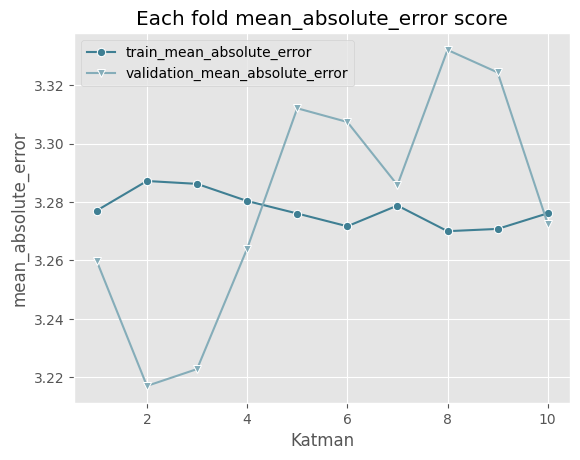

In [1927]:
lr = LinearRegression()

lr_pipeline = Pipeline([
    ("scaler", StandardScaler()),
    ("regressor", lr)
])

kf = KFold(n_splits=10,shuffle=True,random_state=42)
lr_model, lr_final_test_mae_score, lr_mae_scores_df,lr_y_pred_test = train_and_evaluate_model(lr_pipeline, X_train, y_train, X_test, y_test, mean_absolute_error, kf, plot=True, use_rmse=False)

1. Fold train_r2_score: 0.18
1. Fold validasyon_r2_score: 0.18
2. Fold train_r2_score: 0.18
2. Fold validasyon_r2_score: 0.17
3. Fold train_r2_score: 0.17
3. Fold validasyon_r2_score: 0.18
4. Fold train_r2_score: 0.18
4. Fold validasyon_r2_score: 0.17
5. Fold train_r2_score: 0.18
5. Fold validasyon_r2_score: 0.18
6. Fold train_r2_score: 0.18
6. Fold validasyon_r2_score: 0.18
7. Fold train_r2_score: 0.17
7. Fold validasyon_r2_score: 0.18
8. Fold train_r2_score: 0.18
8. Fold validasyon_r2_score: 0.17
9. Fold train_r2_score: 0.18
9. Fold validasyon_r2_score: 0.17
10. Fold train_r2_score: 0.18
10. Fold validasyon_r2_score: 0.16
Cross validation stage has been complated! Model is started to training...
*******************************************
Model training has been complated!
*******************************************
Average train_r2_score result: 0.18
Average validation_r2_score sonucu: 0.17
Test_r2_score result: 0.18
Validation percentage according to train:%-0.71
Final test percent

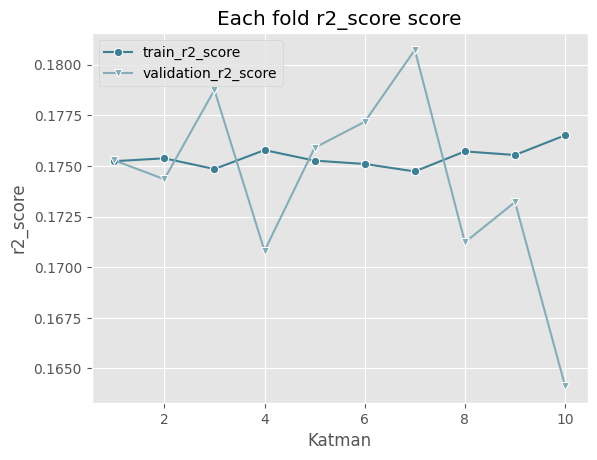

In [1928]:
lr = LinearRegression()

lr_pipeline = Pipeline([
    ("scaler", StandardScaler()),
    ("regressor", lr)
])

kf = KFold(n_splits=10,shuffle=True,random_state=42)
_ , lr_final_test_r2_score, lr_r2_scores_df,lr_y_pred_test = train_and_evaluate_model(lr_pipeline, X_train, y_train, X_test, y_test, r2_score, kf, plot=True, use_rmse=False)

**Linear Regression Özellik Seçimi**


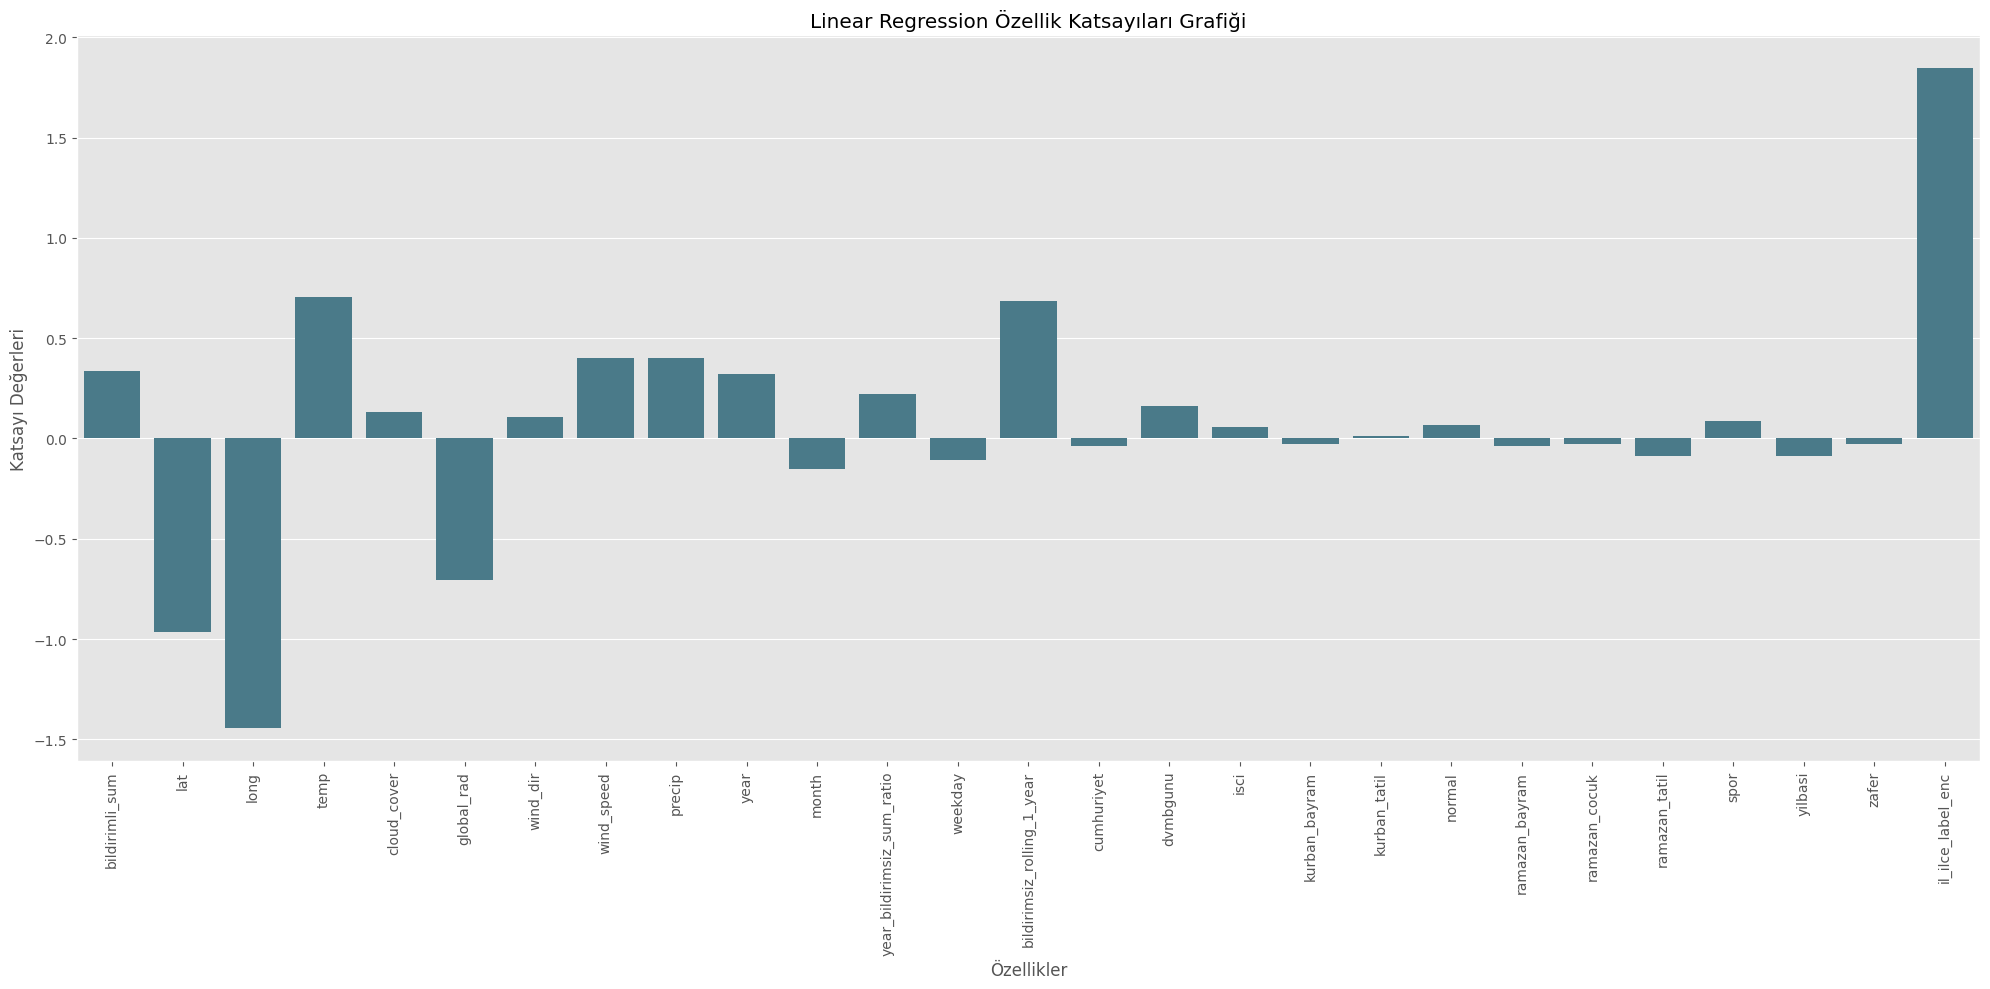

In [1929]:
coef_values = lr_model.named_steps["regressor"].coef_
columns = X_train.columns
plt.figure(figsize=(20,10))
sns.barplot(x=columns, y=coef_values)
plt.xlabel("Özellikler")
plt.ylabel("Katsayı Değerleri")
plt.title("Linear Regression Özellik Katsayıları Grafiği")
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

**XgBoostRegressor Modeli**
- Model ağaç tabanlı olduğundan karmaşık ve çarpık verilerde iyi performans gösterir bu nedenle ölçekleme uygulanmamıştır.

**Hiperparametre Optimizasyonu**
- Bayesyen hiperparametre ayarlama, makine öğrenimi modellerindeki hiperparametreleri optimize etmek için bayesyen istatistiklerini kullanır. 
Bu yöntem, en iyi hiperparametre değerlerini tahmin etmek için bir olasılık dağılımını günceller ve modelin performansını artırmayı amaçlar.

In [713]:
# space = {
#     'learning_rate': hp.loguniform('learning_rate', -5, 0),  
#     'n_estimators': hp.quniform('n_estimators', 95, 500, 1),
#     'max_depth': hp.choice('max_depth', range(3, 15)),  
#     'min_child_weight': hp.quniform('min_child_weight', 1, 10, 1), 
#     'subsample': hp.uniform('subsample', 0.2, 1), 
#     'gamma': hp.uniform('gamma', 0, 1), 
#     'colsample_bytree': hp.uniform('colsample_bytree', 0.5, 1), 
#     'reg_alpha': hp.quniform('reg_alpha', 0, 80, 1), 
#     'reg_lambda': hp.uniform('reg_lambda', 0, 1),
#     'scale_pos_weight': hp.quniform('scale_pos_weight', 1, 10, 1), 
#     'booster': hp.choice('booster', ['gbtree']), 
#     'seed': 0
# }
# def objective(params,X,y):
#     xg_reg = XGBRegressor(
#         colsample_bytree=params['colsample_bytree'],
#         gamma=params['gamma'],
#         n_estimators=int(params['n_estimators']),
#         max_depth=int(params['max_depth']),
#         learning_rate=params['learning_rate'],
#         subsample=params['subsample'],
#         min_child_weight=int(params['min_child_weight']),
#         reg_alpha=int(params['reg_alpha']),
#         reg_lambda=params['reg_lambda'],
#         seed=params['seed'],
#     )
    
#     kf = KFold(n_splits=10,shuffle=True,random_state=42)
#     mae_scores = []

#     for train_index, test_index in kf.split(X):
#         X_train, X_test = X.iloc[train_index], X.iloc[test_index]
#         y_train, y_test = y.iloc[train_index], y.iloc[test_index]

#         xg_reg.fit(X_train, y_train)
#         predictions = xg_reg.predict(X_test)

#         mae_score = mean_absolute_error(np.expm1(y_test), np.expm1(predictions))
#         mae_scores.append(mae_score)


#     average_mae = sum(mae_scores) / len(mae_scores)
#     return average_mae


# trials = Trials()
# best = fmin(fn=lambda params:objective(params,X=X,y=y), space=space, algo=tpe.suggest, max_evals=100, trials=trials)

# print("Best Hyperparameters:", best)
# print("Best score (MAE):", trials.best_trial['result']['loss'])

In [1946]:
#bayesian_xgb_params = {'booster': 'gbtree', 'colsample_bytree': 0.9059713199918993, 'gamma': 0.7654256130970506, 'learning_rate': 0.05680557986964648, 'max_depth': 5, 'min_child_weight': 7, 'n_estimators': 110, 'reg_alpha': 25, 'reg_lambda': 0.06579951812119596, 'scale_pos_weight': 7, 'subsample': 0.7735762314600151}
bayesian_xgb_params = {'booster': 'gbtree', 'colsample_bytree': 0.9092940475616561, 'gamma': 0.8100115391981325, 'learning_rate': 0.0722209725309728, 'max_depth': 4, 'min_child_weight': 7, 'n_estimators': 80, 'reg_alpha': 25, 'reg_lambda': 0.5722436973737604, 'scale_pos_weight': 7, 'subsample': 0.8884445883672576}#sub3
#bayesian_xgb_params = {'booster': 'gbtree', 'colsample_bytree': 0.7416008519645787, 'gamma': 0.3525904412919533, 'learning_rate': 0.03607997073518614, 'max_depth': 5, 'min_child_weight': 5, 'n_estimators': 250, 'reg_alpha': 5, 'reg_lambda': 0.7651894483502046, 'scale_pos_weight': 2, 'subsample': 0.8180822607703974}

In [1947]:
xgb = XGBRegressor(**bayesian_xgb_params,n_jobs=-1)
xgb.get_params()

{'objective': 'reg:squarederror',
 'base_score': None,
 'booster': 'gbtree',
 'callbacks': None,
 'colsample_bylevel': None,
 'colsample_bynode': None,
 'colsample_bytree': 0.9092940475616561,
 'device': None,
 'early_stopping_rounds': None,
 'enable_categorical': False,
 'eval_metric': None,
 'feature_types': None,
 'gamma': 0.8100115391981325,
 'grow_policy': None,
 'importance_type': None,
 'interaction_constraints': None,
 'learning_rate': 0.0722209725309728,
 'max_bin': None,
 'max_cat_threshold': None,
 'max_cat_to_onehot': None,
 'max_delta_step': None,
 'max_depth': 4,
 'max_leaves': None,
 'min_child_weight': 7,
 'missing': nan,
 'monotone_constraints': None,
 'multi_strategy': None,
 'n_estimators': 80,
 'n_jobs': -1,
 'num_parallel_tree': None,
 'random_state': None,
 'reg_alpha': 25,
 'reg_lambda': 0.5722436973737604,
 'sampling_method': None,
 'scale_pos_weight': 7,
 'subsample': 0.8884445883672576,
 'tree_method': None,
 'validate_parameters': None,
 'verbosity': None}

In [716]:
# n_trees = range(115, 150)
# train_maes = []
# validation_maes = []
# test_maes = []

# for n_tree in n_trees:
#     kf_ = KFold(n_splits=10,shuffle=True,random_state=42)
#     control_params = {'booster': 'gbtree', 'colsample_bytree': 0.9092940475616561, 'gamma': 0.8100115391981325, 'learning_rate': 0.0722209725309728, 'max_depth': 5, 'min_child_weight': 7, 'n_estimators': n_tree, 'reg_alpha': 25, 'reg_lambda': 0.5722436973737604, 'scale_pos_weight': 7, 'subsample': 0.8884445883672576}#sub3
#     xg_reg_control = XGBRegressor(**control_params,n_jobs=-1)
    
#     xgb_model, xgb_final_test_mae_score, xgb_mae_scores_df,xgb_y_pred_test = train_and_evaluate_model(xg_reg_control, X_train, y_train, X_test, y_test, mean_absolute_error, kf_, plot=False, use_rmse=False)
    
#     # Her ağaç sayısı için eğitim, doğrulama ve test MAE değerlerini kaydetme
#     train_maes.append(np.mean(xgb_mae_scores_df["train_mean_absolute_error"]))
#     validation_maes.append(np.mean(xgb_mae_scores_df["validation_mean_absolute_error"]))
#     test_maes.append(xgb_final_test_mae_score)
#     print(f'Tree number: {n_tree}')
#     print("*******************************************")

# # Eğitim, doğrulama ve test MAE farklarını hesaplama
# train_diffs = np.array(train_maes) - np.array(validation_maes)
# test_diffs = np.array(train_maes) - np.array(test_maes)

In [717]:
# # Tek grafik oluşturma
# plt.plot(n_trees, test_diffs, marker='o', c="blue", label='Train - Test')
# #plt.plot(n_trees, train_diffs, marker='x', c="red", label='Train - Validation')
# plt.xlabel('Number of Trees')
# plt.ylabel('MAE Difference (Train - Validation)')
# plt.title('MAE Differences for Train-Validation and Train-Test Sets')
# plt.legend()
# plt.grid(True)
# plt.show()

1. Fold train_mean_absolute_error: 2.69
1. Fold validasyon_mean_absolute_error: 2.76
2. Fold train_mean_absolute_error: 2.70
2. Fold validasyon_mean_absolute_error: 2.67
3. Fold train_mean_absolute_error: 2.69
3. Fold validasyon_mean_absolute_error: 2.69
4. Fold train_mean_absolute_error: 2.69
4. Fold validasyon_mean_absolute_error: 2.70
5. Fold train_mean_absolute_error: 2.69
5. Fold validasyon_mean_absolute_error: 2.72
6. Fold train_mean_absolute_error: 2.69
6. Fold validasyon_mean_absolute_error: 2.77
7. Fold train_mean_absolute_error: 2.69
7. Fold validasyon_mean_absolute_error: 2.69
8. Fold train_mean_absolute_error: 2.68
8. Fold validasyon_mean_absolute_error: 2.75
9. Fold train_mean_absolute_error: 2.69
9. Fold validasyon_mean_absolute_error: 2.76
10. Fold train_mean_absolute_error: 2.69
10. Fold validasyon_mean_absolute_error: 2.71
Cross validation stage has been complated! Model is started to training...
*******************************************
Model training has been compl

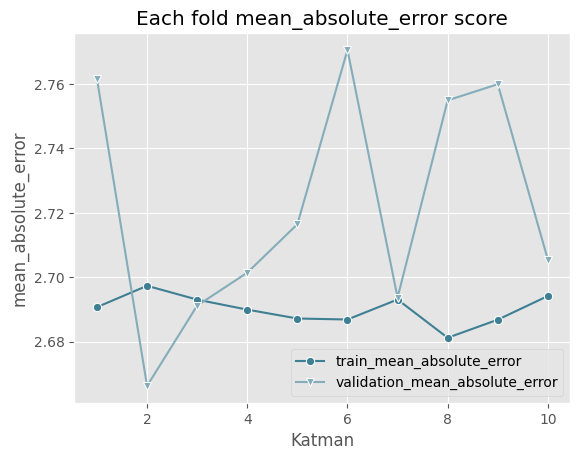

In [1948]:
# Metrik MAE
kf = KFold(n_splits=10,shuffle=True,random_state=42)
tscv=TimeSeriesSplit(n_splits=10)
xgb_model, xgb_final_test_mae_score, xgb_mae_scores_df,xgb_y_pred_test = train_and_evaluate_model(xgb, X_train, y_train, X_test, y_test, mean_absolute_error, kf, plot=True, use_rmse=False)

1. Fold train_r2_score: 0.33
1. Fold validasyon_r2_score: 0.31
2. Fold train_r2_score: 0.34
2. Fold validasyon_r2_score: 0.31
3. Fold train_r2_score: 0.34
3. Fold validasyon_r2_score: 0.32
4. Fold train_r2_score: 0.34
4. Fold validasyon_r2_score: 0.32
5. Fold train_r2_score: 0.34
5. Fold validasyon_r2_score: 0.33
6. Fold train_r2_score: 0.33
6. Fold validasyon_r2_score: 0.32
7. Fold train_r2_score: 0.33
7. Fold validasyon_r2_score: 0.33
8. Fold train_r2_score: 0.34
8. Fold validasyon_r2_score: 0.32
9. Fold train_r2_score: 0.34
9. Fold validasyon_r2_score: 0.31
10. Fold train_r2_score: 0.33
10. Fold validasyon_r2_score: 0.32
Cross validation stage has been complated! Model is started to training...
*******************************************
Model training has been complated!
*******************************************
Average train_r2_score result: 0.34
Average validation_r2_score sonucu: 0.32
Test_r2_score result: 0.31
Validation percentage according to train:%-5.09
Final test percent

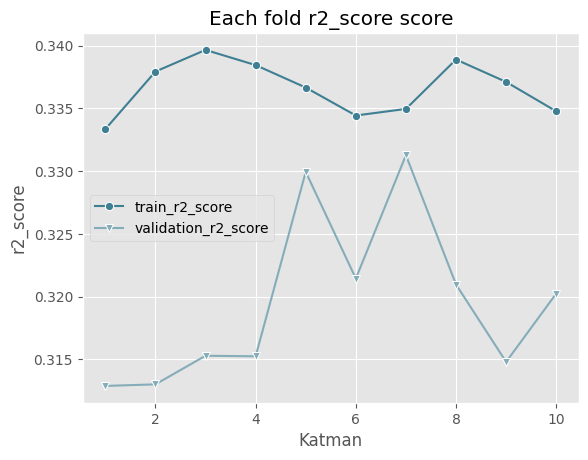

In [1949]:
# Metrik R2

kf = KFold(n_splits=10,shuffle=True,random_state=42)
xgb_model, xgb_final_test_r2_score, xgb_r2_scores_df,xgb_y_pred_test = train_and_evaluate_model(xgb, X_train, y_train, X_test, y_test, r2_score, kf, plot=True, use_rmse=True)

**XGBoost Regressor Regression Özellik Seçimi**

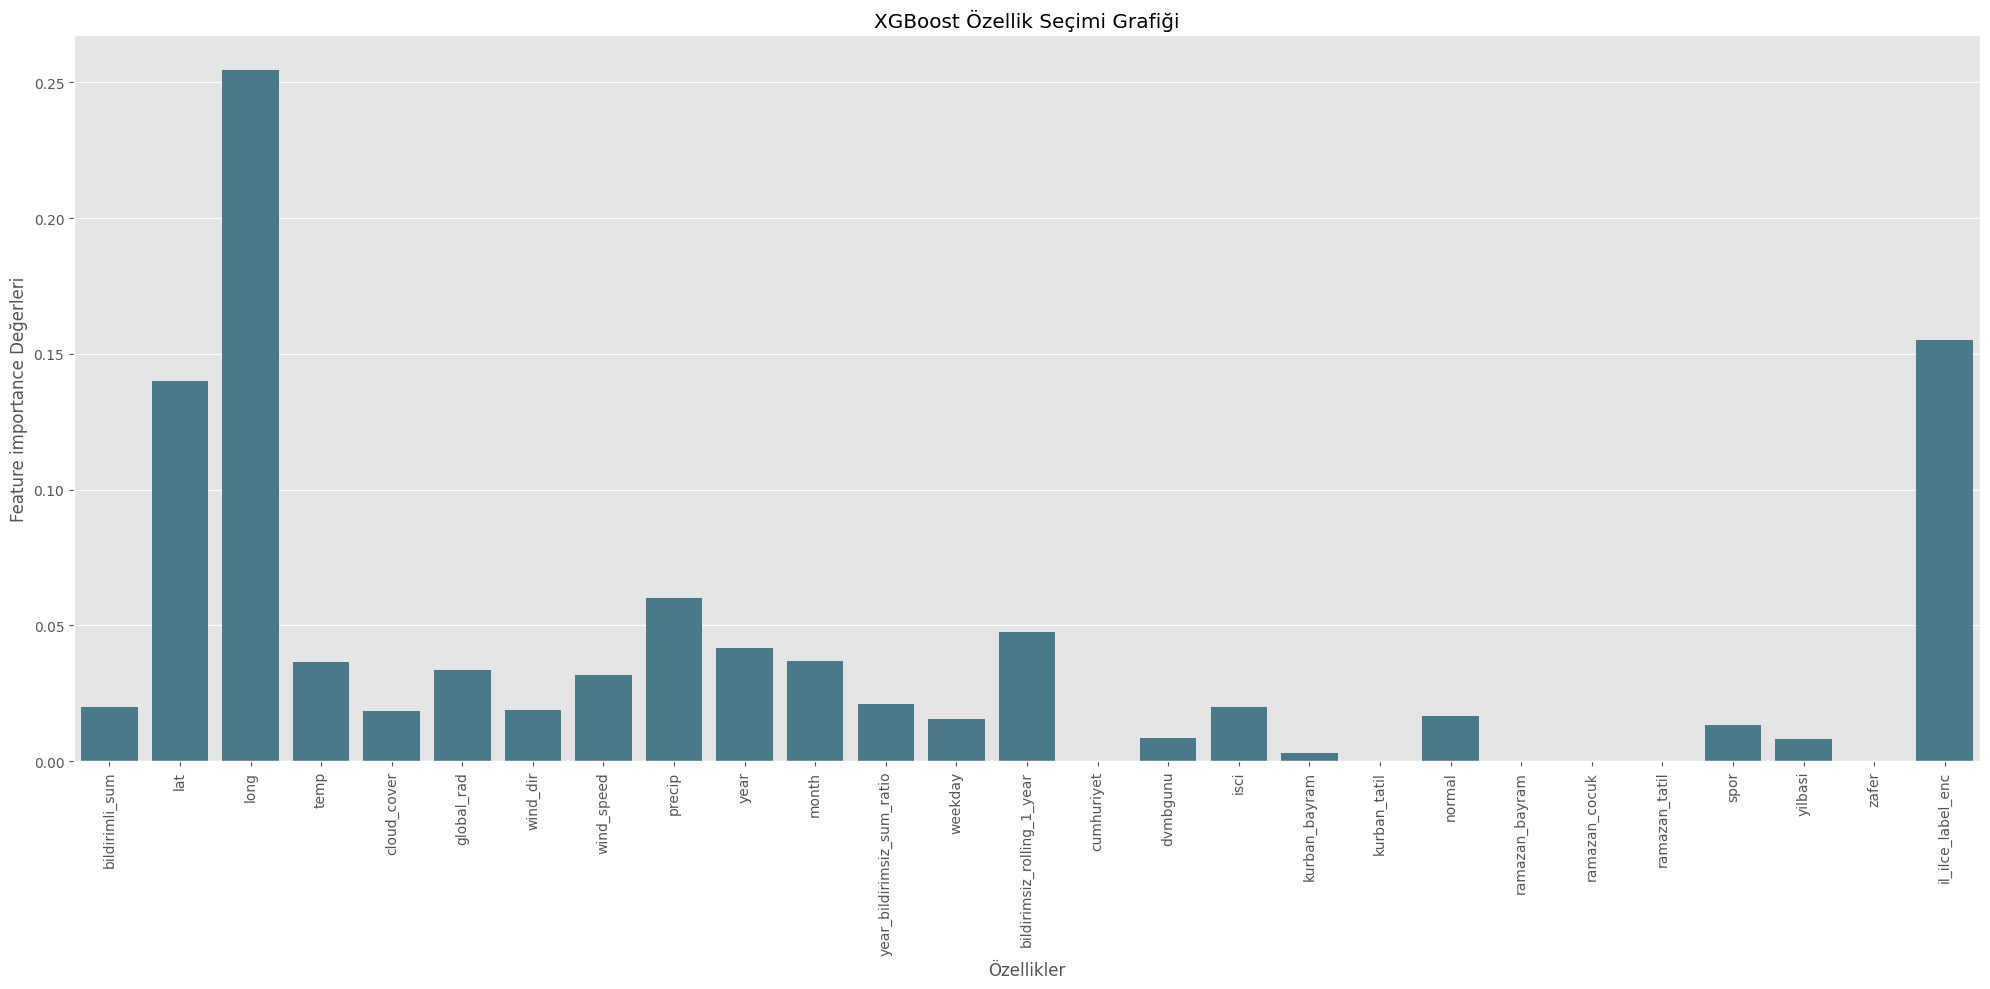

In [1950]:
feature_importances = xgb_model.feature_importances_
columns = X_train.columns
plt.figure(figsize=(20,10))
sns.barplot(x=columns, y=feature_importances)
plt.xlabel("Özellikler")
plt.ylabel("Feature importance Değerleri")
plt.title("XGBoost Özellik Seçimi Grafiği")
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

**RandomForestRegressor Modeli**

In [500]:
# rf_params = {"n_estimators":350,"max_depth":7,"min_samples_split":2,"min_samples_leaf":2,"max_features":0.6}

In [501]:
# rf = RandomForestRegressor(**rf_params,n_jobs=-1)
# rf.get_params()

In [502]:
# # Metrik MAE
# kf = KFold(n_splits=10,shuffle=True,random_state=42)
# rf_model, rf_final_test_mae_score, rf_mae_scores_df,rf_y_pred_test = train_and_evaluate_model(rf, X_train, y_train, X_test, y_test, mean_absolute_error, kf, plot=True, use_rmse=False)

In [503]:
# # Metrik R2

# kf = KFold(n_splits=10,shuffle=True,random_state=42)
# rf_model, rf_final_test_r2_score, rf_r2_scores_df,rf_y_pred_test = train_and_evaluate_model(rf, X_train, y_train, X_test, y_test, r2_score, kf, plot=True, use_rmse=False)

**Random Forest Regressor Regression Özellik Seçimi**

In [504]:
# feature_importances = rf_model.feature_importances_
# columns = X_train.columns
# plt.figure(figsize=(20,10))
# sns.barplot(x=columns, y=feature_importances)
# plt.xlabel("Özellikler")
# plt.ylabel("Feature importance Değerleri")
# plt.title("Random Forest Özellik Seçimi Grafiği")
# plt.xticks(rotation=90)
# plt.tight_layout()
# plt.show()

**Model Stacking**

In [505]:
# regressors = [("rf", rf),("xgb",xgb)]
# reg_meta = lr
# reg_stack = StackingRegressor(estimators=regressors,final_estimator=reg_meta)

In [506]:
# # Metrik MAE
# kf = KFold(n_splits=10,shuffle=True,random_state=42)
# stack_model, stack_final_test_mae_score, stack_mae_scores_df,stack_y_pred_test = train_and_evaluate_model(reg_stack, X_train, y_train, X_test, y_test, mean_absolute_error, kf, plot=True, use_rmse=False)

In [507]:
# # Metrik R2

# kf = KFold(n_splits=10,shuffle=True,random_state=42)
# stack_model, stack_final_test_r2_score, stack_r2_scores_df,stack_y_pred_test = train_and_evaluate_model(reg_stack, X_train, y_train, X_test, y_test, r2_score, kf, plot=True, use_rmse=False)

In [508]:
# scores_data = {
#     "Model": ["Linear Regression"] * 2 + ["Stack Regressor"] * 2,
#     "Metrik": ["RMSE Score", "R2 Score"] * 2,
#     "Skor": [lr_final_test_mae_score, lr_final_test_r2_score, stack_final_test_mae_score, stack_final_test_r2_score]
# }
# scores_df = pd.DataFrame(scores_data)

# plt.figure(figsize=(10, 6))
# ax = sns.barplot(x="Model", y="Skor", hue="Metrik", data=scores_df)
# for container in ax.containers:
#     ax.bar_label(container, fmt='%0.2f', label_type="edge")
# plt.title("Model Karşılaştırması")
# plt.ylabel("Skor")
# plt.xlabel("Model")
# plt.legend(loc="upper center")
# plt.show()

**LSTM Model**

In [509]:
# X_lstm = new_train[feature_columns]
# y_lstm= new_train[target]

# test_lstm = new_test[feature_columns]


In [510]:

# early_stopping = EarlyStopping(monitor='loss', patience=5, verbose=1)
# scaler = MinMaxScaler()
# train_features_scaled = scaler.fit_transform(X_lstm)

# X_train, X_val, y_train, y_val = train_test_split(train_features_scaled, y_lstm, test_size=0.2, shuffle=False)

# X_train_reshaped = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
# X_val_reshaped = X_val.reshape((X_val.shape[0], X_val.shape[1], 1))

# model = Sequential([
#     LSTM(units=100, return_sequences=True, input_shape=(X_train.shape[1], 1)),
#     Dropout(0.2),
#     LSTM(units=50),
#     Dropout(0.2),
#     Dense(units=1)
# ])

# model.compile(optimizer=rmsprop_v2.RMSProp(), loss='mean_absolute_error')

# history = model.fit(X_train_reshaped, y_train, epochs=1, verbose=1, callbacks=[early_stopping], validation_data=(X_val_reshaped, y_val))

# train_predictions = model.predict(X_train_reshaped)
# train_predictions_reshaped = train_predictions.squeeze()
# train_score = mean_absolute_error(scaler.inverse_transform(y_train.values.reshape(-1, 1)), scaler.inverse_transform(train_predictions_reshaped.reshape(-1, 1)))

# test_predictions = model.predict(X_val_reshaped)
# test_predictions_reshaped = test_predictions.squeeze()
# test_score = mean_absolute_error(scaler.inverse_transform(y_val.values.reshape(-1, 1)), scaler.inverse_transform(test_predictions_reshaped.reshape(-1, 1)))

# print(f'Train Score (MAE): {train_score}')
# print(f'Test Score (MAE): {test_score}')

# test_lstm_reshaped = test_lstm.values.reshape((test_lstm.shape[0], test_lstm.shape[1], 1))
# predicted_values = model.predict(test_lstm_reshaped)
# predicted_values_reshaped = predicted_values.squeeze()

# new_test.loc[:,'bildirimsiz_sum'] = predicted_values_reshaped

# # Tahmin edilen değerleri yazdır
# print(new_test[['unique_id', 'bildirimsiz_sum']])


In [511]:
# train_loss = history.history['loss']
# val_loss = history.history['val_loss']

# # Eğitim ve doğrulama kayıplarının grafiğini çiz
# plt.plot(train_loss, label='Training Loss')
# plt.plot(val_loss, label='Validation Loss')
# plt.xlabel('Epoch')
# plt.ylabel('Loss')
# plt.title('Training and Validation Loss')
# plt.legend()
# plt.show()

**!!BURAYI DÜZENLE Modellerin Karşılaştırılması**
- Linear regresyon modeli gecikmeleri 10.49 dakika hata payı (RMSE) ile tahmin etmiştir. R2 0.88 çıkmasıda modelin veriye çok iyi bir şekilde uyduğunu gösterir. Linear regresyon modeli bu veri setinde iyi performans göstermiştir diyebiliriz. 2 metrik içinde eğitim, doğrulama ve test verilerinin birbirine yakın olmasıda modelin dengeli ve genelleştirilebilir olduğunu herhangi bir overfitting underfitting durumu olmadığını gösterebilir.
  
- XGBoost Regressor modeli gecikmeleri 8.77 dakika hata payı (RMSE) ile tahmin etmiştir. R2 0.92 çıkmasıda modelin veriye mükemmele yakın bir şekilde uyduğunu gösterir. XGBoost Regressor modeli bu veri setinde çok iyi performans göstermiştir. 2 metrik içinde eğitim, doğrulama ve test verilerini incelediğimizde yine dengeli görünmektedir. Test sonucunun eğitim sonucundan biraz yüksek olması beklenen bir durumdur. Xgboostun parametrelerinin ayarlanmasına biraz daha vakit harcanıp daha da iyi sonuçlar elde edilebilir.
- Modellerin metriklere göre karşılaştırılması görseli aşağıda sunulmuştur.

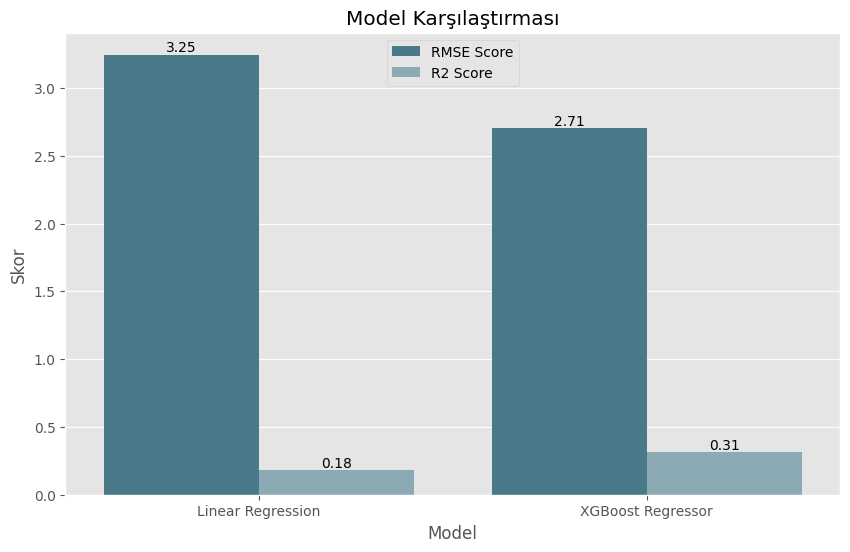

In [1951]:
scores_data = {
    "Model": ["Linear Regression"] * 2 + ["XGBoost Regressor"] * 2,
    "Metrik": ["RMSE Score", "R2 Score"] * 2,
    "Skor": [lr_final_test_mae_score, lr_final_test_r2_score, xgb_final_test_mae_score, xgb_final_test_r2_score]
}
scores_df = pd.DataFrame(scores_data)

plt.figure(figsize=(10, 6))
ax = sns.barplot(x="Model", y="Skor", hue="Metrik", data=scores_df)
for container in ax.containers:
    ax.bar_label(container, fmt='%0.2f', label_type="edge")
plt.title("Model Karşılaştırması")
plt.ylabel("Skor")
plt.xlabel("Model")
plt.legend(loc="upper center")
plt.show()

**Son Tahmin ve Submission Oluşturulması**

In [1952]:
final_test = new_test[X_train.columns]
new_test.loc[:, "bildirimsiz_sum"] = xgb_model.predict(final_test)
#new_test["bildirimsiz_sum"] = np.expm1(new_test["bildirimsiz_sum"])
new_test["bildirimsiz_sum"] = round(new_test["bildirimsiz_sum"]).astype(int)
new_test[["unique_id","bildirimsiz_sum"]].head()

unique_id  bildirimsiz_sum
0       2024-02-01-izmir-aliaga                3
1     2024-02-01-manisa-akhisar                6
2    2024-02-01-manisa-alasehir                5
3     2024-02-01-manisa-demirci                1
4  2024-02-01-manisa-golmarmara                1

In [1953]:
new_test.groupby("month")["bildirimsiz_sum"].sum().reset_index()

month  bildirimsiz_sum
0      2             5349

In [1954]:
#new_train["bildirimsiz_sum"] = np.expm1(new_train["bildirimsiz_sum"])
new_train[(new_train["month"]==2)&(new_train["year"]==2023)].groupby("month")["bildirimsiz_sum"].sum().reset_index()

month  bildirimsiz_sum
0      2             5164

In [1958]:
new_test[["unique_id","bildirimsiz_sum"]].to_csv('submissions/submission52.csv',index=False)

**il ilce bazlı tahmin kontrolü**

In [1955]:
from tqdm import tqdm
def predict_for_each_county(model, new_test, columns):

    for il_ilce in tqdm(new_test['il_ilce'].unique()):
        il_ilce_data = new_test[new_test['il_ilce'] == il_ilce]
        predictions = model.predict(il_ilce_data[columns])
        new_test.loc[new_test['il_ilce'] == il_ilce, 'bildirimsiz_sum'] = predictions
        new_test["bildirimsiz_sum"] = round(new_test["bildirimsiz_sum"]).astype(int)
    print("Process succesfully complated!")
    return new_test

In [1956]:
final_test = predict_for_each_county(xgb_model, new_test, X_train.columns)

100%|██████████| 47/47 [00:00<00:00, 58.49it/s]

Process succesfully complated!


In [1957]:
final_test.groupby("month")["bildirimsiz_sum"].sum().reset_index()

month  bildirimsiz_sum
0      2             5349